## Federated Learning for Melanoma Classification

## FedProx testing on real case scenario splits

### Objective 3: Exploration of data distribution assumptions and novel application of federated learning aggregation strategies for our melanoma classification. 


#### Important notes:

- We test FedProx Algorithm on data splits by patient_id to simulate real case scenarios where the images belonging to the same patient will be stored is same institution or device.
- We generate imbalanced split per age for 96 clients according to the scenario splits presented in Objective 2.   
- We test the effect of FedProx regularization parameter and compare it to previous results we had in non iid testing where the split was done per image. 


### Import Modules & Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import time
import pickle
import random
import sklearn


from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import  confusion_matrix, roc_curve
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as tf
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations as A
from torch.cuda import amp
from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from utils import *
from Visualise import *
from ResizeImages import *
from MelanomaDataset import *
from MelanomaEfficientNet import *
from TrainVal import *
from Test import *
from Plot import *
from FLWorker import *
from FLScenario import *
from FedAvg import *
from FLutils import *
from FLTrainVal import *
from FocalLoss import *

### Package Versions

In [2]:
print(f"Python: {sys.version}")
print(f"Numpy Version: {np.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"sklearn: {sklearn.__version__}")
print(f"Torch: {torch.__version__}")

Python: 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Numpy Version: 1.21.2
matplotlib: 3.4.3
sklearn: 0.24.2
Torch: 1.8.0+cu111


In [3]:
# Working directory
os.getcwd()

'C:\\Users\\sarah\\Documents\\MSc AI 2020_2021\\Research Project\\Federated-Learning-Melanoma'

In [4]:
# Seed everything
set_seed(random_seed=5)

In [5]:
# Set device to GPU if available
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0



Federated learning parameters 
- Local learning rate: 1e-3
- Local Epochs: 80
- Local Batch Size 256
- FL rounds: 5
- No learning rate decay.

Regularization parameter values: 1e-3,1e-4,1e-5 and 1e-6. 

Imbalanced split per age for 96 clients, split was done per patient_id which means each client will have the same number of patiend but not necessary the same number of image. 



###### Note: (mu=1e-5 was run with 15 FL rounds)

In [8]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 96
local_epochs = 5*int(n_workers/6)
local_batch = 256
client_ratio = 1
fl_rounds = 15

age_split_image = FeatureLabelUnbalancedScenarioFL(split_by='patient_id',feature_name='age_approx',f_unbal_ratio=1)
age_workers_split = create_flworker_set(train_loader,n_workers,age_split_image,local_batch)

# FedAvg aggregator object
mu=1e-5
fedavg=FedProx(fl_rounds,client_ratio,mu,client_sampling = 'DataSetWeightedSampling',lr_decay =0)

t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [9]:
fl_train_val(t_model, age_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_AgeSplit_FedProx1e5_96W_FLR15_LB256_E5R_C1',display_worker_output=False)

 round:0, worker: 64 Training
 round:0, worker: 64 Validation



 val loss: 0.023981, val acc: 0.9830, val roc:0.5511
 round:0, worker: 30 Training
 round:0, worker: 30 Validation



 val loss: 0.021264, val acc: 0.9828, val roc:0.6877
 round:0, worker: 6 Training
 round:0, worker: 6 Validation



 val loss: 0.024064, val acc: 0.9804, val roc:0.5195
 round:0, worker: 2 Training
 round:0, worker: 2 Validation



 val loss: 0.019511, val acc: 0.9744, val roc:0.6725
 round:0, worker: 79 Training
 round:0, worker: 79 Validation



 val loss: 0.069428, val acc: 0.9830, val roc:0.6471
 round:0, worker: 88 Training
 round:0, worker: 88 Validation



 val loss: 0.069379, val acc: 0.9830, val roc:0.6758
 round:0, worker: 60 Training
 round:0, worker: 60 Validation



 val loss: 0.025561, val acc: 0.9824, val roc:0.5923
 round:0, worker: 71 Training
 round:0, worker: 71 Validation



 val loss: 0.033522, val acc: 0.9830, val roc:0.5602
 round:0, worker: 55 Training
 round:0, worker: 55 Validation



 val loss: 0.022192, val acc: 0.9822, val roc:0.6959
 round:0, worker: 90 Training
 round:0, worker: 90 Validation



 val loss: 0.033331, val acc: 0.9830, val roc:0.5603
 round:0, worker: 0 Training
 round:0, worker: 0 Validation



 val loss: 0.028887, val acc: 0.9709, val roc:0.6031
 round:0, worker: 83 Training
 round:0, worker: 83 Validation



 val loss: 0.020178, val acc: 0.9824, val roc:0.6470
 round:0, worker: 5 Training
 round:0, worker: 5 Validation



 val loss: 0.024082, val acc: 0.9808, val roc:0.6654
 round:0, worker: 21 Training
 round:0, worker: 21 Validation



 val loss: 0.022241, val acc: 0.9822, val roc:0.6370
 round:0, worker: 84 Training
 round:0, worker: 84 Validation



 val loss: 0.024881, val acc: 0.9824, val roc:0.6453
 round:0, worker: 33 Training
 round:0, worker: 33 Validation



 val loss: 0.019201, val acc: 0.9822, val roc:0.6038
 round:0, worker: 44 Training
 round:0, worker: 44 Validation



 val loss: 0.024061, val acc: 0.9787, val roc:0.6552
 round:0, worker: 4 Training
 round:0, worker: 4 Validation



 val loss: 0.030239, val acc: 0.9594, val roc:0.6468
 round:0, worker: 16 Training
 round:0, worker: 16 Validation



 val loss: 0.022806, val acc: 0.9799, val roc:0.6928
 round:0, worker: 67 Training
 round:0, worker: 67 Validation



 val loss: 0.069553, val acc: 0.9830, val roc:0.6296
 round:0, worker: 66 Training
 round:0, worker: 66 Validation



 val loss: 0.026827, val acc: 0.9830, val roc:0.5731
 round:0, worker: 62 Training
 round:0, worker: 62 Validation



 val loss: 0.027110, val acc: 0.9737, val roc:0.5263
 round:0, worker: 41 Training
 round:0, worker: 41 Validation



 val loss: 0.069529, val acc: 0.9830, val roc:0.6251
 round:0, worker: 95 Training
 round:0, worker: 95 Validation



 val loss: 0.023816, val acc: 0.9761, val roc:0.6205
 round:0, worker: 94 Training
 round:0, worker: 94 Validation



 val loss: 0.069408, val acc: 0.9830, val roc:0.6225
 round:0, worker: 18 Training
 round:0, worker: 18 Validation



 val loss: 0.025780, val acc: 0.9649, val roc:0.5553
 round:0, worker: 70 Training
 round:0, worker: 70 Validation



 val loss: 0.025838, val acc: 0.9798, val roc:0.5804
 round:0, worker: 54 Training
 round:0, worker: 54 Validation



 val loss: 0.034122, val acc: 0.9830, val roc:0.6182
 round:0, worker: 34 Training
 round:0, worker: 34 Validation



 val loss: 0.023047, val acc: 0.9828, val roc:0.5615
 round:0, worker: 52 Training
 round:0, worker: 52 Validation



 val loss: 0.022365, val acc: 0.9830, val roc:0.6825
 round:0, worker: 87 Training
 round:0, worker: 87 Validation



 val loss: 0.022760, val acc: 0.9821, val roc:0.6051
 round:0, worker: 39 Training
 round:0, worker: 39 Validation



 val loss: 0.020743, val acc: 0.9814, val roc:0.7630
 round:0, worker: 57 Training
 round:0, worker: 57 Validation



 val loss: 0.030134, val acc: 0.9830, val roc:0.5691
 round:0, worker: 35 Training
 round:0, worker: 35 Validation



 val loss: 0.021572, val acc: 0.9793, val roc:0.7130
 round:0, worker: 59 Training
 round:0, worker: 59 Validation



 val loss: 0.020328, val acc: 0.9828, val roc:0.6116
 round:0, worker: 37 Training
 round:0, worker: 37 Validation



 val loss: 0.025155, val acc: 0.9814, val roc:0.6081
 round:0, worker: 27 Training
 round:0, worker: 27 Validation



 val loss: 0.026036, val acc: 0.9668, val roc:0.6527
 round:0, worker: 63 Training
 round:0, worker: 63 Validation



 val loss: 0.029664, val acc: 0.9830, val roc:0.4524
 round:0, worker: 11 Training
 round:0, worker: 11 Validation



 val loss: 0.030680, val acc: 0.9830, val roc:0.6267
 round:0, worker: 81 Training
 round:0, worker: 81 Validation



 val loss: 0.025202, val acc: 0.9830, val roc:0.7122
 round:0, worker: 78 Training
 round:0, worker: 78 Validation



 val loss: 0.031347, val acc: 0.9830, val roc:0.4597
 round:0, worker: 28 Training
 round:0, worker: 28 Validation



 val loss: 0.025836, val acc: 0.9811, val roc:0.6457
 round:0, worker: 85 Training
 round:0, worker: 85 Validation



 val loss: 0.029300, val acc: 0.9828, val roc:0.5016
 round:0, worker: 8 Training
 round:0, worker: 8 Validation



 val loss: 0.034982, val acc: 0.9566, val roc:0.5866
 round:0, worker: 19 Training
 round:0, worker: 19 Validation



 val loss: 0.022688, val acc: 0.9827, val roc:0.6690
 round:0, worker: 48 Training
 round:0, worker: 48 Validation



 val loss: 0.030390, val acc: 0.9830, val roc:0.6719
 round:0, worker: 7 Training
 round:0, worker: 7 Validation



 val loss: 0.024484, val acc: 0.9799, val roc:0.7214
 round:0, worker: 42 Training
 round:0, worker: 42 Validation



 val loss: 0.030616, val acc: 0.9819, val roc:0.5071
 round:0, worker: 23 Training
 round:0, worker: 23 Validation



 val loss: 0.023098, val acc: 0.9828, val roc:0.6663
 round:0, worker: 12 Training
 round:0, worker: 12 Validation



 val loss: 0.019629, val acc: 0.9717, val roc:0.7516
 round:0, worker: 58 Training
 round:0, worker: 58 Validation



 val loss: 0.019112, val acc: 0.9790, val roc:0.7108
 round:0, worker: 91 Training
 round:0, worker: 91 Validation



 val loss: 0.026075, val acc: 0.9828, val roc:0.6182
 round:0, worker: 40 Training
 round:0, worker: 40 Validation



 val loss: 0.024369, val acc: 0.9821, val roc:0.6380
 round:0, worker: 13 Training
 round:0, worker: 13 Validation



 val loss: 0.024793, val acc: 0.9830, val roc:0.6232
 round:0, worker: 89 Training
 round:0, worker: 89 Validation



 val loss: 0.024841, val acc: 0.9830, val roc:0.5580
 round:0, worker: 46 Training
 round:0, worker: 46 Validation



 val loss: 0.030140, val acc: 0.9761, val roc:0.5960
 round:0, worker: 93 Training
 round:0, worker: 93 Validation



 val loss: 0.023068, val acc: 0.9828, val roc:0.6747
 round:0, worker: 92 Training
 round:0, worker: 92 Validation



 val loss: 0.071584, val acc: 0.9830, val roc:0.5971
 round:0, worker: 49 Training
 round:0, worker: 49 Validation



 val loss: 0.029493, val acc: 0.9830, val roc:0.5128
 round:0, worker: 73 Training
 round:0, worker: 73 Validation



 val loss: 0.071555, val acc: 0.9830, val roc:0.5755
 round:0, worker: 43 Training
 round:0, worker: 43 Validation



 val loss: 0.018801, val acc: 0.9822, val roc:0.6448
 round:0, worker: 69 Training
 round:0, worker: 69 Validation



 val loss: 0.023705, val acc: 0.9830, val roc:0.6142
 round:0, worker: 14 Training
 round:0, worker: 14 Validation



 val loss: 0.022867, val acc: 0.9821, val roc:0.7360
 round:0, worker: 20 Training
 round:0, worker: 20 Validation



 val loss: 0.033506, val acc: 0.9830, val roc:0.4897
 round:0, worker: 82 Training
 round:0, worker: 82 Validation



 val loss: 0.030510, val acc: 0.9830, val roc:0.5873
 round:0, worker: 77 Training
 round:0, worker: 77 Validation



 val loss: 0.025806, val acc: 0.9827, val roc:0.4782
 round:0, worker: 74 Training
 round:0, worker: 74 Validation



 val loss: 0.024334, val acc: 0.9830, val roc:0.6400
 round:0, worker: 45 Training
 round:0, worker: 45 Validation



 val loss: 0.024862, val acc: 0.9816, val roc:0.5986
 round:0, worker: 24 Training
 round:0, worker: 24 Validation



 val loss: 0.026334, val acc: 0.9697, val roc:0.5258
 round:0, worker: 72 Training
 round:0, worker: 72 Validation



 val loss: 0.025568, val acc: 0.9830, val roc:0.5459
 round:0, worker: 80 Training
 round:0, worker: 80 Validation



 val loss: 0.027249, val acc: 0.9824, val roc:0.6559
 round:0, worker: 26 Training
 round:0, worker: 26 Validation



 val loss: 0.024484, val acc: 0.9825, val roc:0.6382
 round:0, worker: 50 Training
 round:0, worker: 50 Validation



 val loss: 0.029906, val acc: 0.9830, val roc:0.5241
 round:0, worker: 36 Training
 round:0, worker: 36 Validation



 val loss: 0.022456, val acc: 0.9828, val roc:0.6601
 round:0, worker: 3 Training
 round:0, worker: 3 Validation



 val loss: 0.025630, val acc: 0.9734, val roc:0.5385
 round:0, worker: 68 Training
 round:0, worker: 68 Validation



 val loss: 0.024018, val acc: 0.9830, val roc:0.6604
 round:0, worker: 53 Training
 round:0, worker: 53 Validation



 val loss: 0.026123, val acc: 0.9830, val roc:0.6670
 round:0, worker: 65 Training
 round:0, worker: 65 Validation



 val loss: 0.021826, val acc: 0.9824, val roc:0.6329
 round:0, worker: 1 Training
 round:0, worker: 1 Validation



 val loss: 0.023235, val acc: 0.9798, val roc:0.5502
 round:0, worker: 47 Training
 round:0, worker: 47 Validation



 val loss: 0.024170, val acc: 0.9830, val roc:0.6791
 round:0, worker: 9 Training
 round:0, worker: 9 Validation



 val loss: 0.022702, val acc: 0.9784, val roc:0.6568
 round:0, worker: 29 Training
 round:0, worker: 29 Validation



 val loss: 0.030387, val acc: 0.9830, val roc:0.4150
 round:0, worker: 32 Training
 round:0, worker: 32 Validation



 val loss: 0.022614, val acc: 0.9830, val roc:0.6350
 round:0, worker: 51 Training
 round:0, worker: 51 Validation



 val loss: 0.033533, val acc: 0.9830, val roc:0.4355
 round:0, worker: 25 Training
 round:0, worker: 25 Validation



 val loss: 0.020316, val acc: 0.9822, val roc:0.6906
 round:0, worker: 22 Training
 round:0, worker: 22 Validation



 val loss: 0.023797, val acc: 0.9828, val roc:0.5549
 round:0, worker: 56 Training
 round:0, worker: 56 Validation



 val loss: 0.019302, val acc: 0.9822, val roc:0.6288
 round:0, worker: 38 Training
 round:0, worker: 38 Validation



 val loss: 0.023789, val acc: 0.9790, val roc:0.7128
 round:0, worker: 75 Training
 round:0, worker: 75 Validation



 val loss: 0.023960, val acc: 0.9725, val roc:0.6820
 round:0, worker: 31 Training
 round:0, worker: 31 Validation



 val loss: 0.027049, val acc: 0.9830, val roc:0.5316
 round:0, worker: 86 Training
 round:0, worker: 86 Validation



 val loss: 0.028355, val acc: 0.9830, val roc:0.5575
 round:0, worker: 61 Training
 round:0, worker: 61 Validation



 val loss: 0.024921, val acc: 0.9828, val roc:0.4197
 round:0, worker: 76 Training
 round:0, worker: 76 Validation



 val loss: 0.034613, val acc: 0.9769, val roc:0.5830
 round:0, worker: 10 Training
 round:0, worker: 10 Validation



 val loss: 0.024392, val acc: 0.9775, val roc:0.6327
 round:0, worker: 17 Training
 round:0, worker: 17 Validation



 val loss: 0.031788, val acc: 0.9817, val roc:0.4111
 round:0, worker: 15 Training
 round:0, worker: 15 Validation



 val loss: 0.033406, val acc: 0.9571, val roc:0.5877
 round: 0, avg train loss: 0.002215, avg train acc: 0.9968
 round: 0, avg val loss: 0.028919, avg val acc: 0.9802, avg val roc:0.6079
 round:0, Center Validation



 val loss: 0.028854, val acc: 0.9830, val roc:0.8277
 round:1, worker: 6 Training
 round:1, worker: 6 Validation



 val loss: 0.031995, val acc: 0.9761, val roc:0.5654
 round:1, worker: 80 Training
 round:1, worker: 80 Validation



 val loss: 0.029092, val acc: 0.9821, val roc:0.7069
 round:1, worker: 43 Training
 round:1, worker: 43 Validation



 val loss: 0.028438, val acc: 0.9786, val roc:0.6470
 round:1, worker: 1 Training
 round:1, worker: 1 Validation



 val loss: 0.026434, val acc: 0.9807, val roc:0.6036
 round:1, worker: 40 Training
 round:1, worker: 40 Validation



 val loss: 0.030707, val acc: 0.9814, val roc:0.7077
 round:1, worker: 11 Training
 round:1, worker: 11 Validation



 val loss: 0.041466, val acc: 0.9830, val roc:0.7136
 round:1, worker: 66 Training
 round:1, worker: 66 Validation



 val loss: 0.037900, val acc: 0.9831, val roc:0.6463
 round:1, worker: 30 Training
 round:1, worker: 30 Validation



 val loss: 0.028966, val acc: 0.9793, val roc:0.7318
 round:1, worker: 69 Training
 round:1, worker: 69 Validation



 val loss: 0.033984, val acc: 0.9825, val roc:0.6700
 round:1, worker: 91 Training
 round:1, worker: 91 Validation



 val loss: 0.037655, val acc: 0.9817, val roc:0.6530
 round:1, worker: 16 Training
 round:1, worker: 16 Validation



 val loss: 0.025773, val acc: 0.9776, val roc:0.7172
 round:1, worker: 84 Training
 round:1, worker: 84 Validation



 val loss: 0.035910, val acc: 0.9751, val roc:0.7145
 round:1, worker: 8 Training
 round:1, worker: 8 Validation



 val loss: 0.026412, val acc: 0.9626, val roc:0.6283
 round:1, worker: 44 Training
 round:1, worker: 44 Validation



 val loss: 0.033780, val acc: 0.9773, val roc:0.6785
 round:1, worker: 52 Training
 round:1, worker: 52 Validation



 val loss: 0.030725, val acc: 0.9798, val roc:0.7289
 round:1, worker: 94 Training
 round:1, worker: 94 Validation



 val loss: 0.061149, val acc: 0.9830, val roc:0.8276
 round:1, worker: 76 Training
 round:1, worker: 76 Validation



 val loss: 0.044537, val acc: 0.9799, val roc:0.6453
 round:1, worker: 33 Training
 round:1, worker: 33 Validation



 val loss: 0.030379, val acc: 0.9807, val roc:0.6344
 round:1, worker: 86 Training
 round:1, worker: 86 Validation



 val loss: 0.034570, val acc: 0.9821, val roc:0.6198
 round:1, worker: 53 Training
 round:1, worker: 53 Validation



 val loss: 0.036262, val acc: 0.9828, val roc:0.7176
 round:1, worker: 38 Training
 round:1, worker: 38 Validation



 val loss: 0.022999, val acc: 0.9792, val roc:0.7492
 round:1, worker: 95 Training
 round:1, worker: 95 Validation



 val loss: 0.029418, val acc: 0.9732, val roc:0.6616
 round:1, worker: 34 Training
 round:1, worker: 34 Validation



 val loss: 0.034460, val acc: 0.9807, val roc:0.5778
 round:1, worker: 21 Training
 round:1, worker: 21 Validation



 val loss: 0.031101, val acc: 0.9819, val roc:0.6563
 round:1, worker: 79 Training
 round:1, worker: 79 Validation



 val loss: 0.061019, val acc: 0.9830, val roc:0.8275
 round:1, worker: 67 Training
 round:1, worker: 67 Validation



 val loss: 0.061209, val acc: 0.9830, val roc:0.8275
 round:1, worker: 93 Training
 round:1, worker: 93 Validation



 val loss: 0.031262, val acc: 0.9808, val roc:0.7171
 round:1, worker: 89 Training
 round:1, worker: 89 Validation



 val loss: 0.035115, val acc: 0.9814, val roc:0.6286
 round:1, worker: 72 Training
 round:1, worker: 72 Validation



 val loss: 0.037776, val acc: 0.9824, val roc:0.5986
 round:1, worker: 29 Training
 round:1, worker: 29 Validation



 val loss: 0.040658, val acc: 0.9830, val roc:0.5639
 round:1, worker: 19 Training
 round:1, worker: 19 Validation



 val loss: 0.030498, val acc: 0.9817, val roc:0.7070
 round:1, worker: 20 Training
 round:1, worker: 20 Validation



 val loss: 0.046914, val acc: 0.9830, val roc:0.6634
 round:1, worker: 42 Training
 round:1, worker: 42 Validation



 val loss: 0.038840, val acc: 0.9808, val roc:0.5724
 round:1, worker: 88 Training
 round:1, worker: 88 Validation



 val loss: 0.060855, val acc: 0.9830, val roc:0.8275
 round:1, worker: 56 Training
 round:1, worker: 56 Validation



 val loss: 0.029987, val acc: 0.9781, val roc:0.6153
 round:1, worker: 57 Training
 round:1, worker: 57 Validation



 val loss: 0.039187, val acc: 0.9830, val roc:0.7009
 round:1, worker: 22 Training
 round:1, worker: 22 Validation



 val loss: 0.033641, val acc: 0.9814, val roc:0.5916
 round:1, worker: 54 Training
 round:1, worker: 54 Validation



 val loss: 0.041948, val acc: 0.9830, val roc:0.7538
 round:1, worker: 12 Training
 round:1, worker: 12 Validation



 val loss: 0.021771, val acc: 0.9709, val roc:0.7617
 round:1, worker: 75 Training
 round:1, worker: 75 Validation



 val loss: 0.025687, val acc: 0.9714, val roc:0.7087
 round:1, worker: 59 Training
 round:1, worker: 59 Validation



 val loss: 0.029494, val acc: 0.9824, val roc:0.6607
 round:1, worker: 35 Training
 round:1, worker: 35 Validation



 val loss: 0.025741, val acc: 0.9784, val roc:0.7333
 round:1, worker: 23 Training
 round:1, worker: 23 Validation



 val loss: 0.031793, val acc: 0.9811, val roc:0.7188
 round:1, worker: 60 Training
 round:1, worker: 60 Validation



 val loss: 0.035897, val acc: 0.9795, val roc:0.6757
 round:1, worker: 10 Training
 round:1, worker: 10 Validation



 val loss: 0.022986, val acc: 0.9790, val roc:0.6785
 round:1, worker: 41 Training
 round:1, worker: 41 Validation



 val loss: 0.061487, val acc: 0.9830, val roc:0.8275
 round:1, worker: 9 Training
 round:1, worker: 9 Validation



 val loss: 0.023033, val acc: 0.9793, val roc:0.6761
 round:1, worker: 70 Training
 round:1, worker: 70 Validation



 val loss: 0.037019, val acc: 0.9758, val roc:0.6188
 round:1, worker: 85 Training
 round:1, worker: 85 Validation



 val loss: 0.041498, val acc: 0.9825, val roc:0.5999
 round:1, worker: 51 Training
 round:1, worker: 51 Validation



 val loss: 0.047442, val acc: 0.9830, val roc:0.5741
 round:1, worker: 74 Training
 round:1, worker: 74 Validation



 val loss: 0.037227, val acc: 0.9808, val roc:0.7032
 round:1, worker: 64 Training
 round:1, worker: 64 Validation



 val loss: 0.035479, val acc: 0.9828, val roc:0.6006
 round:1, worker: 49 Training
 round:1, worker: 49 Validation



 val loss: 0.046386, val acc: 0.9824, val roc:0.5945
 round:1, worker: 78 Training
 round:1, worker: 78 Validation



 val loss: 0.040077, val acc: 0.9810, val roc:0.6050
 round:1, worker: 73 Training
 round:1, worker: 73 Validation



 val loss: 0.057175, val acc: 0.9830, val roc:0.8273
 round:1, worker: 45 Training
 round:1, worker: 45 Validation



 val loss: 0.030376, val acc: 0.9807, val roc:0.6425
 round:1, worker: 77 Training
 round:1, worker: 77 Validation



 val loss: 0.031403, val acc: 0.9816, val roc:0.5651
 round:1, worker: 55 Training
 round:1, worker: 55 Validation



 val loss: 0.028170, val acc: 0.9801, val roc:0.7360
 round:1, worker: 61 Training
 round:1, worker: 61 Validation



 val loss: 0.036137, val acc: 0.9816, val roc:0.5232
 round:1, worker: 87 Training
 round:1, worker: 87 Validation



 val loss: 0.030701, val acc: 0.9801, val roc:0.6559
 round:1, worker: 5 Training
 round:1, worker: 5 Validation



 val loss: 0.029517, val acc: 0.9799, val roc:0.6918
 round:1, worker: 81 Training
 round:1, worker: 81 Validation



 val loss: 0.032153, val acc: 0.9828, val roc:0.7625
 round:1, worker: 36 Training
 round:1, worker: 36 Validation



 val loss: 0.031840, val acc: 0.9821, val roc:0.6945
 round:1, worker: 31 Training
 round:1, worker: 31 Validation



 val loss: 0.036764, val acc: 0.9817, val roc:0.6183
 round:1, worker: 92 Training
 round:1, worker: 92 Validation



 val loss: 0.057179, val acc: 0.9830, val roc:0.8273
 round:1, worker: 71 Training
 round:1, worker: 71 Validation



 val loss: 0.043633, val acc: 0.9830, val roc:0.7445
 round:1, worker: 46 Training
 round:1, worker: 46 Validation



 val loss: 0.034252, val acc: 0.9773, val roc:0.6494
 round:1, worker: 39 Training
 round:1, worker: 39 Validation



 val loss: 0.025218, val acc: 0.9801, val roc:0.7850
 round:1, worker: 83 Training
 round:1, worker: 83 Validation



 val loss: 0.030301, val acc: 0.9764, val roc:0.6769
 round:1, worker: 65 Training
 round:1, worker: 65 Validation



 val loss: 0.027728, val acc: 0.9798, val roc:0.7022
 round:1, worker: 24 Training
 round:1, worker: 24 Validation



 val loss: 0.028720, val acc: 0.9644, val roc:0.5475
 round:1, worker: 32 Training
 round:1, worker: 32 Validation



 val loss: 0.034388, val acc: 0.9833, val roc:0.6838
 round:1, worker: 37 Training
 round:1, worker: 37 Validation



 val loss: 0.033577, val acc: 0.9811, val roc:0.6500
 round:1, worker: 48 Training
 round:1, worker: 48 Validation



 val loss: 0.044474, val acc: 0.9830, val roc:0.7439
 round:1, worker: 13 Training
 round:1, worker: 13 Validation



 val loss: 0.034892, val acc: 0.9825, val roc:0.6926
 round:1, worker: 0 Training
 round:1, worker: 0 Validation



 val loss: 0.018953, val acc: 0.9778, val roc:0.6715
 round:1, worker: 68 Training
 round:1, worker: 68 Validation



 val loss: 0.031759, val acc: 0.9825, val roc:0.7444
 round:1, worker: 82 Training
 round:1, worker: 82 Validation



 val loss: 0.042701, val acc: 0.9830, val roc:0.6864
 round:1, worker: 90 Training
 round:1, worker: 90 Validation



 val loss: 0.043386, val acc: 0.9830, val roc:0.6433
 round:1, worker: 47 Training
 round:1, worker: 47 Validation



 val loss: 0.035626, val acc: 0.9825, val roc:0.7332
 round:1, worker: 58 Training
 round:1, worker: 58 Validation



 val loss: 0.026871, val acc: 0.9708, val roc:0.7359
 round:1, worker: 28 Training
 round:1, worker: 28 Validation



 val loss: 0.029223, val acc: 0.9807, val roc:0.6791
 round:1, worker: 14 Training
 round:1, worker: 14 Validation



 val loss: 0.029420, val acc: 0.9810, val roc:0.7618
 round:1, worker: 50 Training
 round:1, worker: 50 Validation



 val loss: 0.041959, val acc: 0.9827, val roc:0.6152
 round:1, worker: 27 Training
 round:1, worker: 27 Validation



 val loss: 0.025428, val acc: 0.9679, val roc:0.6799
 round:1, worker: 3 Training
 round:1, worker: 3 Validation



 val loss: 0.019236, val acc: 0.9801, val roc:0.6166
 round:1, worker: 17 Training
 round:1, worker: 17 Validation



 val loss: 0.031230, val acc: 0.9819, val roc:0.4891
 round:1, worker: 2 Training
 round:1, worker: 2 Validation



 val loss: 0.016608, val acc: 0.9766, val roc:0.7027
 round:1, worker: 25 Training
 round:1, worker: 25 Validation



 val loss: 0.025223, val acc: 0.9817, val roc:0.7245
 round:1, worker: 18 Training
 round:1, worker: 18 Validation



 val loss: 0.024024, val acc: 0.9674, val roc:0.5822
 round:1, worker: 62 Training
 round:1, worker: 62 Validation



 val loss: 0.026882, val acc: 0.9758, val roc:0.5629
 round:1, worker: 63 Training
 round:1, worker: 63 Validation



 val loss: 0.043153, val acc: 0.9830, val roc:0.5858
 round:1, worker: 15 Training
 round:1, worker: 15 Validation



 val loss: 0.023904, val acc: 0.9639, val roc:0.6290
 round:1, worker: 4 Training
 round:1, worker: 4 Validation



 val loss: 0.021392, val acc: 0.9685, val roc:0.6808
 round:1, worker: 26 Training
 round:1, worker: 26 Validation



 val loss: 0.026779, val acc: 0.9824, val roc:0.6762
 round:1, worker: 7 Training
 round:1, worker: 7 Validation



 val loss: 0.026190, val acc: 0.9801, val roc:0.7477
 round: 1, avg train loss: 0.001127, avg train acc: 0.9998
 round: 1, avg val loss: 0.034423, avg val acc: 0.9796, avg val roc:0.6761
 round:1, Center Validation



 val loss: 0.033697, val acc: 0.9830, val roc:0.8378
 round:2, worker: 54 Training
 round:2, worker: 54 Validation



 val loss: 0.042242, val acc: 0.9830, val roc:0.7872
 round:2, worker: 79 Training
 round:2, worker: 79 Validation



 val loss: 0.061175, val acc: 0.9830, val roc:0.8378
 round:2, worker: 95 Training
 round:2, worker: 95 Validation



 val loss: 0.028650, val acc: 0.9722, val roc:0.6774
 round:2, worker: 39 Training
 round:2, worker: 39 Validation



 val loss: 0.025219, val acc: 0.9805, val roc:0.7964
 round:2, worker: 20 Training
 round:2, worker: 20 Validation



 val loss: 0.046140, val acc: 0.9830, val roc:0.6954
 round:2, worker: 41 Training
 round:2, worker: 41 Validation



 val loss: 0.062757, val acc: 0.9830, val roc:0.8378
 round:2, worker: 73 Training
 round:2, worker: 73 Validation



 val loss: 0.062035, val acc: 0.9830, val roc:0.8378
 round:2, worker: 46 Training
 round:2, worker: 46 Validation



 val loss: 0.034385, val acc: 0.9779, val roc:0.6748
 round:2, worker: 58 Training
 round:2, worker: 58 Validation



 val loss: 0.025373, val acc: 0.9723, val roc:0.7499
 round:2, worker: 16 Training
 round:2, worker: 16 Validation



 val loss: 0.023753, val acc: 0.9772, val roc:0.7347
 round:2, worker: 70 Training
 round:2, worker: 70 Validation



 val loss: 0.036595, val acc: 0.9758, val roc:0.6544
 round:2, worker: 31 Training
 round:2, worker: 31 Validation



 val loss: 0.036990, val acc: 0.9821, val roc:0.6525
 round:2, worker: 22 Training
 round:2, worker: 22 Validation



 val loss: 0.031854, val acc: 0.9821, val roc:0.6446
 round:2, worker: 84 Training
 round:2, worker: 84 Validation



 val loss: 0.038481, val acc: 0.9754, val roc:0.7425
 round:2, worker: 56 Training
 round:2, worker: 56 Validation



 val loss: 0.028293, val acc: 0.9781, val roc:0.6347
 round:2, worker: 52 Training
 round:2, worker: 52 Validation



 val loss: 0.031046, val acc: 0.9801, val roc:0.7536
 round:2, worker: 87 Training
 round:2, worker: 87 Validation



 val loss: 0.031392, val acc: 0.9796, val roc:0.6695
 round:2, worker: 11 Training
 round:2, worker: 11 Validation



 val loss: 0.042440, val acc: 0.9830, val roc:0.7336
 round:2, worker: 68 Training
 round:2, worker: 68 Validation



 val loss: 0.031652, val acc: 0.9825, val roc:0.7675
 round:2, worker: 36 Training
 round:2, worker: 36 Validation



 val loss: 0.031670, val acc: 0.9822, val roc:0.7163
 round:2, worker: 21 Training
 round:2, worker: 21 Validation



 val loss: 0.029388, val acc: 0.9819, val roc:0.6789
 round:2, worker: 67 Training
 round:2, worker: 67 Validation



 val loss: 0.062110, val acc: 0.9830, val roc:0.8378
 round:2, worker: 40 Training
 round:2, worker: 40 Validation



 val loss: 0.031035, val acc: 0.9814, val roc:0.7313
 round:2, worker: 91 Training
 round:2, worker: 91 Validation



 val loss: 0.036467, val acc: 0.9821, val roc:0.6704
 round:2, worker: 23 Training
 round:2, worker: 23 Validation



 val loss: 0.032409, val acc: 0.9816, val roc:0.7346
 round:2, worker: 53 Training
 round:2, worker: 53 Validation



 val loss: 0.035726, val acc: 0.9828, val roc:0.7388
 round:2, worker: 3 Training
 round:2, worker: 3 Validation



 val loss: 0.019937, val acc: 0.9790, val roc:0.6515
 round:2, worker: 78 Training
 round:2, worker: 78 Validation



 val loss: 0.039935, val acc: 0.9817, val roc:0.6436
 round:2, worker: 26 Training
 round:2, worker: 26 Validation



 val loss: 0.026210, val acc: 0.9824, val roc:0.6921
 round:2, worker: 2 Training
 round:2, worker: 2 Validation



 val loss: 0.017873, val acc: 0.9751, val roc:0.6977
 round:2, worker: 69 Training
 round:2, worker: 69 Validation



 val loss: 0.032745, val acc: 0.9821, val roc:0.6891
 round:2, worker: 65 Training
 round:2, worker: 65 Validation



 val loss: 0.026391, val acc: 0.9795, val roc:0.7174
 round:2, worker: 61 Training
 round:2, worker: 61 Validation



 val loss: 0.036324, val acc: 0.9819, val roc:0.5714
 round:2, worker: 29 Training
 round:2, worker: 29 Validation



 val loss: 0.042284, val acc: 0.9830, val roc:0.6101
 round:2, worker: 57 Training
 round:2, worker: 57 Validation



 val loss: 0.042642, val acc: 0.9830, val roc:0.7157
 round:2, worker: 89 Training
 round:2, worker: 89 Validation



 val loss: 0.035693, val acc: 0.9813, val roc:0.6447
 round:2, worker: 19 Training
 round:2, worker: 19 Validation



 val loss: 0.031060, val acc: 0.9817, val roc:0.7226
 round:2, worker: 59 Training
 round:2, worker: 59 Validation



 val loss: 0.026882, val acc: 0.9827, val roc:0.6921
 round:2, worker: 18 Training
 round:2, worker: 18 Validation



 val loss: 0.024278, val acc: 0.9678, val roc:0.6126
 round:2, worker: 34 Training
 round:2, worker: 34 Validation



 val loss: 0.033323, val acc: 0.9819, val roc:0.6030
 round:2, worker: 88 Training
 round:2, worker: 88 Validation



 val loss: 0.060468, val acc: 0.9830, val roc:0.8378
 round:2, worker: 38 Training
 round:2, worker: 38 Validation



 val loss: 0.022568, val acc: 0.9802, val roc:0.7695
 round:2, worker: 28 Training
 round:2, worker: 28 Validation



 val loss: 0.029467, val acc: 0.9808, val roc:0.6875
 round:2, worker: 80 Training
 round:2, worker: 80 Validation



 val loss: 0.028813, val acc: 0.9819, val roc:0.7311
 round:2, worker: 51 Training
 round:2, worker: 51 Validation



 val loss: 0.048710, val acc: 0.9830, val roc:0.5964
 round:2, worker: 94 Training
 round:2, worker: 94 Validation



 val loss: 0.061804, val acc: 0.9830, val roc:0.8378
 round:2, worker: 13 Training
 round:2, worker: 13 Validation



 val loss: 0.035712, val acc: 0.9827, val roc:0.7081
 round:2, worker: 48 Training
 round:2, worker: 48 Validation



 val loss: 0.045792, val acc: 0.9830, val roc:0.7666
 round:2, worker: 72 Training
 round:2, worker: 72 Validation



 val loss: 0.036364, val acc: 0.9821, val roc:0.6219
 round:2, worker: 44 Training
 round:2, worker: 44 Validation



 val loss: 0.033872, val acc: 0.9779, val roc:0.6977
 round:2, worker: 6 Training
 round:2, worker: 6 Validation



 val loss: 0.031068, val acc: 0.9773, val roc:0.5941
 round:2, worker: 83 Training
 round:2, worker: 83 Validation



 val loss: 0.027414, val acc: 0.9779, val roc:0.6944
 round:2, worker: 50 Training
 round:2, worker: 50 Validation



 val loss: 0.043957, val acc: 0.9827, val roc:0.6426
 round:2, worker: 81 Training
 round:2, worker: 81 Validation



 val loss: 0.034729, val acc: 0.9828, val roc:0.7822
 round:2, worker: 42 Training
 round:2, worker: 42 Validation



 val loss: 0.038760, val acc: 0.9808, val roc:0.5881
 round:2, worker: 90 Training
 round:2, worker: 90 Validation



 val loss: 0.045577, val acc: 0.9830, val roc:0.6681
 round:2, worker: 7 Training
 round:2, worker: 7 Validation



 val loss: 0.024650, val acc: 0.9805, val roc:0.7697
 round:2, worker: 0 Training
 round:2, worker: 0 Validation



 val loss: 0.019455, val acc: 0.9770, val roc:0.6969
 round:2, worker: 30 Training
 round:2, worker: 30 Validation



 val loss: 0.029775, val acc: 0.9787, val roc:0.7449
 round:2, worker: 93 Training
 round:2, worker: 93 Validation



 val loss: 0.031309, val acc: 0.9813, val roc:0.7378
 round:2, worker: 25 Training
 round:2, worker: 25 Validation



 val loss: 0.023747, val acc: 0.9819, val roc:0.7490
 round:2, worker: 75 Training
 round:2, worker: 75 Validation



 val loss: 0.024761, val acc: 0.9720, val roc:0.7296
 round:2, worker: 12 Training
 round:2, worker: 12 Validation



 val loss: 0.021397, val acc: 0.9714, val roc:0.7721
 round:2, worker: 55 Training
 round:2, worker: 55 Validation



 val loss: 0.028261, val acc: 0.9792, val roc:0.7540
 round:2, worker: 92 Training
 round:2, worker: 92 Validation



 val loss: 0.061843, val acc: 0.9830, val roc:0.8378
 round:2, worker: 66 Training
 round:2, worker: 66 Validation



 val loss: 0.038909, val acc: 0.9831, val roc:0.6469
 round:2, worker: 71 Training
 round:2, worker: 71 Validation



 val loss: 0.047865, val acc: 0.9830, val roc:0.7810
 round:2, worker: 82 Training
 round:2, worker: 82 Validation



 val loss: 0.047318, val acc: 0.9830, val roc:0.6959
 round:2, worker: 62 Training
 round:2, worker: 62 Validation



 val loss: 0.024544, val acc: 0.9767, val roc:0.5964
 round:2, worker: 32 Training
 round:2, worker: 32 Validation



 val loss: 0.034167, val acc: 0.9834, val roc:0.7204
 round:2, worker: 47 Training
 round:2, worker: 47 Validation



 val loss: 0.034652, val acc: 0.9825, val roc:0.7528
 round:2, worker: 17 Training
 round:2, worker: 17 Validation



 val loss: 0.029721, val acc: 0.9821, val roc:0.5495
 round:2, worker: 49 Training
 round:2, worker: 49 Validation



 val loss: 0.047515, val acc: 0.9827, val roc:0.6080
 round:2, worker: 64 Training
 round:2, worker: 64 Validation



 val loss: 0.035098, val acc: 0.9827, val roc:0.6405
 round:2, worker: 8 Training
 round:2, worker: 8 Validation



 val loss: 0.026447, val acc: 0.9649, val roc:0.6582
 round:2, worker: 60 Training
 round:2, worker: 60 Validation



 val loss: 0.038086, val acc: 0.9798, val roc:0.6909
 round:2, worker: 35 Training
 round:2, worker: 35 Validation



 val loss: 0.024679, val acc: 0.9781, val roc:0.7459
 round:2, worker: 43 Training
 round:2, worker: 43 Validation



 val loss: 0.027112, val acc: 0.9790, val roc:0.6638
 round:2, worker: 27 Training
 round:2, worker: 27 Validation



 val loss: 0.024735, val acc: 0.9693, val roc:0.6992
 round:2, worker: 14 Training
 round:2, worker: 14 Validation



 val loss: 0.028391, val acc: 0.9813, val roc:0.7777
 round:2, worker: 86 Training
 round:2, worker: 86 Validation



 val loss: 0.032422, val acc: 0.9825, val roc:0.6694
 round:2, worker: 63 Training
 round:2, worker: 63 Validation



 val loss: 0.045115, val acc: 0.9830, val roc:0.6108
 round:2, worker: 37 Training
 round:2, worker: 37 Validation



 val loss: 0.032908, val acc: 0.9808, val roc:0.6744
 round:2, worker: 77 Training
 round:2, worker: 77 Validation



 val loss: 0.031937, val acc: 0.9817, val roc:0.6200
 round:2, worker: 33 Training
 round:2, worker: 33 Validation



 val loss: 0.030445, val acc: 0.9813, val roc:0.6593
 round:2, worker: 9 Training
 round:2, worker: 9 Validation



 val loss: 0.022360, val acc: 0.9792, val roc:0.6893
 round:2, worker: 5 Training
 round:2, worker: 5 Validation



 val loss: 0.028575, val acc: 0.9799, val roc:0.7154
 round:2, worker: 74 Training
 round:2, worker: 74 Validation



 val loss: 0.037284, val acc: 0.9805, val roc:0.7200
 round:2, worker: 24 Training
 round:2, worker: 24 Validation



 val loss: 0.027465, val acc: 0.9647, val roc:0.5734
 round:2, worker: 85 Training
 round:2, worker: 85 Validation



 val loss: 0.042962, val acc: 0.9824, val roc:0.6340
 round:2, worker: 1 Training
 round:2, worker: 1 Validation



 val loss: 0.024931, val acc: 0.9814, val roc:0.6403
 round:2, worker: 76 Training
 round:2, worker: 76 Validation



 val loss: 0.049966, val acc: 0.9824, val roc:0.6704
 round:2, worker: 45 Training
 round:2, worker: 45 Validation



 val loss: 0.029415, val acc: 0.9811, val roc:0.6679
 round:2, worker: 15 Training
 round:2, worker: 15 Validation



 val loss: 0.024418, val acc: 0.9653, val roc:0.6555
 round:2, worker: 10 Training
 round:2, worker: 10 Validation



 val loss: 0.022841, val acc: 0.9789, val roc:0.7138
 round:2, worker: 4 Training
 round:2, worker: 4 Validation



 val loss: 0.021628, val acc: 0.9685, val roc:0.7082
 round: 2, avg train loss: 0.000850, avg train acc: 0.9998
 round: 2, avg val loss: 0.034573, avg val acc: 0.9798, avg val roc:0.6992
 round:2, Center Validation



 val loss: 0.034140, val acc: 0.9830, val roc:0.8418
 round:3, worker: 14 Training
 round:3, worker: 14 Validation



 val loss: 0.030085, val acc: 0.9814, val roc:0.7849
 round:3, worker: 53 Training
 round:3, worker: 53 Validation



 val loss: 0.035776, val acc: 0.9827, val roc:0.7498
 round:3, worker: 79 Training
 round:3, worker: 79 Validation



 val loss: 0.060255, val acc: 0.9830, val roc:0.8418
 round:3, worker: 25 Training
 round:3, worker: 25 Validation



 val loss: 0.025833, val acc: 0.9821, val roc:0.7612
 round:3, worker: 11 Training
 round:3, worker: 11 Validation



 val loss: 0.043676, val acc: 0.9827, val roc:0.7411
 round:3, worker: 55 Training
 round:3, worker: 55 Validation



 val loss: 0.027896, val acc: 0.9790, val roc:0.7610
 round:3, worker: 22 Training
 round:3, worker: 22 Validation



 val loss: 0.034455, val acc: 0.9817, val roc:0.6529
 round:3, worker: 9 Training
 round:3, worker: 9 Validation



 val loss: 0.023827, val acc: 0.9787, val roc:0.6933
 round:3, worker: 76 Training
 round:3, worker: 76 Validation



 val loss: 0.054620, val acc: 0.9828, val roc:0.6879
 round:3, worker: 80 Training
 round:3, worker: 80 Validation



 val loss: 0.029202, val acc: 0.9817, val roc:0.7407
 round:3, worker: 42 Training
 round:3, worker: 42 Validation



 val loss: 0.038655, val acc: 0.9810, val roc:0.5960
 round:3, worker: 32 Training
 round:3, worker: 32 Validation



 val loss: 0.035854, val acc: 0.9834, val roc:0.7335
 round:3, worker: 31 Training
 round:3, worker: 31 Validation



 val loss: 0.037778, val acc: 0.9824, val roc:0.6652
 round:3, worker: 40 Training
 round:3, worker: 40 Validation



 val loss: 0.031801, val acc: 0.9816, val roc:0.7371
 round:3, worker: 57 Training
 round:3, worker: 57 Validation



 val loss: 0.046523, val acc: 0.9830, val roc:0.7146
 round:3, worker: 54 Training
 round:3, worker: 54 Validation



 val loss: 0.042823, val acc: 0.9830, val roc:0.7990
 round:3, worker: 39 Training
 round:3, worker: 39 Validation



 val loss: 0.025278, val acc: 0.9808, val roc:0.7992
 round:3, worker: 64 Training
 round:3, worker: 64 Validation



 val loss: 0.034758, val acc: 0.9827, val roc:0.6605
 round:3, worker: 67 Training
 round:3, worker: 67 Validation



 val loss: 0.061468, val acc: 0.9830, val roc:0.8418
 round:3, worker: 56 Training
 round:3, worker: 56 Validation



 val loss: 0.031019, val acc: 0.9778, val roc:0.6435
 round:3, worker: 41 Training
 round:3, worker: 41 Validation



 val loss: 0.062316, val acc: 0.9830, val roc:0.8418
 round:3, worker: 63 Training
 round:3, worker: 63 Validation



 val loss: 0.047335, val acc: 0.9830, val roc:0.6190
 round:3, worker: 59 Training
 round:3, worker: 59 Validation



 val loss: 0.030536, val acc: 0.9825, val roc:0.6963
 round:3, worker: 37 Training
 round:3, worker: 37 Validation



 val loss: 0.035011, val acc: 0.9808, val roc:0.6893
 round:3, worker: 33 Training
 round:3, worker: 33 Validation



 val loss: 0.032406, val acc: 0.9811, val roc:0.6677
 round:3, worker: 61 Training
 round:3, worker: 61 Validation



 val loss: 0.037464, val acc: 0.9821, val roc:0.5927
 round:3, worker: 95 Training
 round:3, worker: 95 Validation



 val loss: 0.028008, val acc: 0.9717, val roc:0.6847
 round:3, worker: 44 Training
 round:3, worker: 44 Validation



 val loss: 0.035932, val acc: 0.9776, val roc:0.7044
 round:3, worker: 82 Training
 round:3, worker: 82 Validation



 val loss: 0.050095, val acc: 0.9830, val roc:0.6952
 round:3, worker: 85 Training
 round:3, worker: 85 Validation



 val loss: 0.044958, val acc: 0.9825, val roc:0.6504
 round:3, worker: 91 Training
 round:3, worker: 91 Validation



 val loss: 0.038475, val acc: 0.9821, val roc:0.6774
 round:3, worker: 30 Training
 round:3, worker: 30 Validation



 val loss: 0.030741, val acc: 0.9789, val roc:0.7488
 round:3, worker: 2 Training
 round:3, worker: 2 Validation



 val loss: 0.018780, val acc: 0.9729, val roc:0.6989
 round:3, worker: 52 Training
 round:3, worker: 52 Validation



 val loss: 0.031660, val acc: 0.9804, val roc:0.7638
 round:3, worker: 21 Training
 round:3, worker: 21 Validation



 val loss: 0.031908, val acc: 0.9821, val roc:0.6884
 round:3, worker: 94 Training
 round:3, worker: 94 Validation



 val loss: 0.061186, val acc: 0.9830, val roc:0.8418
 round:3, worker: 87 Training
 round:3, worker: 87 Validation



 val loss: 0.032882, val acc: 0.9793, val roc:0.6751
 round:3, worker: 93 Training
 round:3, worker: 93 Validation



 val loss: 0.033148, val acc: 0.9816, val roc:0.7424
 round:3, worker: 60 Training
 round:3, worker: 60 Validation



 val loss: 0.040949, val acc: 0.9801, val roc:0.6919
 round:3, worker: 81 Training
 round:3, worker: 81 Validation



 val loss: 0.036742, val acc: 0.9830, val roc:0.7884
 round:3, worker: 66 Training
 round:3, worker: 66 Validation



 val loss: 0.040942, val acc: 0.9830, val roc:0.6493
 round:3, worker: 29 Training
 round:3, worker: 29 Validation



 val loss: 0.043968, val acc: 0.9830, val roc:0.6237
 round:3, worker: 90 Training
 round:3, worker: 90 Validation



 val loss: 0.047149, val acc: 0.9830, val roc:0.6753
 round:3, worker: 46 Training
 round:3, worker: 46 Validation



 val loss: 0.036629, val acc: 0.9786, val roc:0.6827
 round:3, worker: 19 Training
 round:3, worker: 19 Validation



 val loss: 0.031741, val acc: 0.9819, val roc:0.7288
 round:3, worker: 45 Training
 round:3, worker: 45 Validation



 val loss: 0.031571, val acc: 0.9810, val roc:0.6741
 round:3, worker: 74 Training
 round:3, worker: 74 Validation



 val loss: 0.037412, val acc: 0.9811, val roc:0.7249
 round:3, worker: 35 Training
 round:3, worker: 35 Validation



 val loss: 0.026457, val acc: 0.9782, val roc:0.7530
 round:3, worker: 70 Training
 round:3, worker: 70 Validation



 val loss: 0.035670, val acc: 0.9757, val roc:0.6687
 round:3, worker: 23 Training
 round:3, worker: 23 Validation



 val loss: 0.035194, val acc: 0.9811, val roc:0.7372
 round:3, worker: 77 Training
 round:3, worker: 77 Validation



 val loss: 0.032875, val acc: 0.9816, val roc:0.6357
 round:3, worker: 84 Training
 round:3, worker: 84 Validation



 val loss: 0.042231, val acc: 0.9754, val roc:0.7473
 round:3, worker: 34 Training
 round:3, worker: 34 Validation



 val loss: 0.037056, val acc: 0.9817, val roc:0.6087
 round:3, worker: 71 Training
 round:3, worker: 71 Validation



 val loss: 0.052361, val acc: 0.9830, val roc:0.7924
 round:3, worker: 88 Training
 round:3, worker: 88 Validation



 val loss: 0.059291, val acc: 0.9830, val roc:0.8419
 round:3, worker: 47 Training
 round:3, worker: 47 Validation



 val loss: 0.036262, val acc: 0.9827, val roc:0.7637
 round:3, worker: 28 Training
 round:3, worker: 28 Validation



 val loss: 0.030233, val acc: 0.9808, val roc:0.6923
 round:3, worker: 20 Training
 round:3, worker: 20 Validation



 val loss: 0.047331, val acc: 0.9830, val roc:0.7063
 round:3, worker: 7 Training
 round:3, worker: 7 Validation



 val loss: 0.026737, val acc: 0.9804, val roc:0.7804
 round:3, worker: 6 Training
 round:3, worker: 6 Validation



 val loss: 0.032846, val acc: 0.9763, val roc:0.6025
 round:3, worker: 5 Training
 round:3, worker: 5 Validation



 val loss: 0.031393, val acc: 0.9798, val roc:0.7267
 round:3, worker: 50 Training
 round:3, worker: 50 Validation



 val loss: 0.046671, val acc: 0.9827, val roc:0.6558
 round:3, worker: 8 Training
 round:3, worker: 8 Validation



 val loss: 0.027427, val acc: 0.9649, val roc:0.6654
 round:3, worker: 73 Training
 round:3, worker: 73 Validation



 val loss: 0.061947, val acc: 0.9830, val roc:0.8417
 round:3, worker: 1 Training
 round:3, worker: 1 Validation



 val loss: 0.026900, val acc: 0.9814, val roc:0.6550
 round:3, worker: 26 Training
 round:3, worker: 26 Validation



 val loss: 0.027928, val acc: 0.9824, val roc:0.7039
 round:3, worker: 43 Training
 round:3, worker: 43 Validation



 val loss: 0.030499, val acc: 0.9792, val roc:0.6687
 round:3, worker: 12 Training
 round:3, worker: 12 Validation



 val loss: 0.022140, val acc: 0.9716, val roc:0.7777
 round:3, worker: 24 Training
 round:3, worker: 24 Validation



 val loss: 0.027480, val acc: 0.9656, val roc:0.5858
 round:3, worker: 15 Training
 round:3, worker: 15 Validation



 val loss: 0.024773, val acc: 0.9659, val roc:0.6653
 round:3, worker: 86 Training
 round:3, worker: 86 Validation



 val loss: 0.033642, val acc: 0.9827, val roc:0.6840
 round:3, worker: 36 Training
 round:3, worker: 36 Validation



 val loss: 0.033601, val acc: 0.9819, val roc:0.7232
 round:3, worker: 27 Training
 round:3, worker: 27 Validation



 val loss: 0.025985, val acc: 0.9694, val roc:0.7052
 round:3, worker: 58 Training
 round:3, worker: 58 Validation



 val loss: 0.025391, val acc: 0.9740, val roc:0.7581
 round:3, worker: 65 Training
 round:3, worker: 65 Validation



 val loss: 0.028029, val acc: 0.9789, val roc:0.7238
 round:3, worker: 69 Training
 round:3, worker: 69 Validation



 val loss: 0.032929, val acc: 0.9819, val roc:0.6961
 round:3, worker: 18 Training
 round:3, worker: 18 Validation



 val loss: 0.025630, val acc: 0.9678, val roc:0.6181
 round:3, worker: 83 Training
 round:3, worker: 83 Validation



 val loss: 0.028814, val acc: 0.9778, val roc:0.7048
 round:3, worker: 48 Training
 round:3, worker: 48 Validation



 val loss: 0.047988, val acc: 0.9830, val roc:0.7724
 round:3, worker: 68 Training
 round:3, worker: 68 Validation



 val loss: 0.032371, val acc: 0.9825, val roc:0.7761
 round:3, worker: 17 Training
 round:3, worker: 17 Validation



 val loss: 0.030937, val acc: 0.9822, val roc:0.5709
 round:3, worker: 13 Training
 round:3, worker: 13 Validation



 val loss: 0.035420, val acc: 0.9827, val roc:0.7130
 round:3, worker: 0 Training
 round:3, worker: 0 Validation



 val loss: 0.019354, val acc: 0.9764, val roc:0.7130
 round:3, worker: 78 Training
 round:3, worker: 78 Validation



 val loss: 0.040742, val acc: 0.9817, val roc:0.6483
 round:3, worker: 75 Training
 round:3, worker: 75 Validation



 val loss: 0.025320, val acc: 0.9723, val roc:0.7429
 round:3, worker: 72 Training
 round:3, worker: 72 Validation



 val loss: 0.039707, val acc: 0.9821, val roc:0.6226
 round:3, worker: 10 Training
 round:3, worker: 10 Validation



 val loss: 0.024200, val acc: 0.9789, val roc:0.7242
 round:3, worker: 3 Training
 round:3, worker: 3 Validation



 val loss: 0.020957, val acc: 0.9782, val roc:0.6616
 round:3, worker: 16 Training
 round:3, worker: 16 Validation



 val loss: 0.024658, val acc: 0.9770, val roc:0.7411
 round:3, worker: 51 Training
 round:3, worker: 51 Validation



 val loss: 0.050304, val acc: 0.9830, val roc:0.6033
 round:3, worker: 62 Training
 round:3, worker: 62 Validation



 val loss: 0.025074, val acc: 0.9770, val roc:0.6113
 round:3, worker: 89 Training
 round:3, worker: 89 Validation



 val loss: 0.036039, val acc: 0.9816, val roc:0.6467
 round:3, worker: 49 Training
 round:3, worker: 49 Validation



 val loss: 0.045189, val acc: 0.9827, val roc:0.6124
 round:3, worker: 38 Training
 round:3, worker: 38 Validation



 val loss: 0.022911, val acc: 0.9805, val roc:0.7778
 round:3, worker: 92 Training
 round:3, worker: 92 Validation



 val loss: 0.061654, val acc: 0.9830, val roc:0.8417
 round:3, worker: 4 Training
 round:3, worker: 4 Validation



 val loss: 0.022448, val acc: 0.9668, val roc:0.7155
 round: 3, avg train loss: 0.000679, avg train acc: 0.9999
 round: 3, avg val loss: 0.035860, avg val acc: 0.9798, avg val roc:0.7074
 round:3, Center Validation



 val loss: 0.035566, val acc: 0.9830, val roc:0.8426
 round:4, worker: 18 Training
 round:4, worker: 18 Validation



 val loss: 0.027486, val acc: 0.9673, val roc:0.6220
 round:4, worker: 66 Training
 round:4, worker: 66 Validation



 val loss: 0.041427, val acc: 0.9830, val roc:0.6460
 round:4, worker: 72 Training
 round:4, worker: 72 Validation



 val loss: 0.040882, val acc: 0.9819, val roc:0.6245
 round:4, worker: 20 Training
 round:4, worker: 20 Validation



 val loss: 0.048109, val acc: 0.9830, val roc:0.7066
 round:4, worker: 67 Training
 round:4, worker: 67 Validation



 val loss: 0.061549, val acc: 0.9830, val roc:0.8427
 round:4, worker: 39 Training
 round:4, worker: 39 Validation



 val loss: 0.025796, val acc: 0.9808, val roc:0.7989
 round:4, worker: 88 Training
 round:4, worker: 88 Validation



 val loss: 0.059018, val acc: 0.9830, val roc:0.8427
 round:4, worker: 73 Training
 round:4, worker: 73 Validation



 val loss: 0.062777, val acc: 0.9830, val roc:0.8424
 round:4, worker: 30 Training
 round:4, worker: 30 Validation



 val loss: 0.031947, val acc: 0.9789, val roc:0.7508
 round:4, worker: 90 Training
 round:4, worker: 90 Validation



 val loss: 0.050101, val acc: 0.9830, val roc:0.6806
 round:4, worker: 3 Training
 round:4, worker: 3 Validation



 val loss: 0.022378, val acc: 0.9776, val roc:0.6647
 round:4, worker: 22 Training
 round:4, worker: 22 Validation



 val loss: 0.035909, val acc: 0.9813, val roc:0.6557
 round:4, worker: 29 Training
 round:4, worker: 29 Validation



 val loss: 0.044831, val acc: 0.9830, val roc:0.6227
 round:4, worker: 71 Training
 round:4, worker: 71 Validation



 val loss: 0.056306, val acc: 0.9830, val roc:0.7955
 round:4, worker: 54 Training
 round:4, worker: 54 Validation



 val loss: 0.043486, val acc: 0.9830, val roc:0.8041
 round:4, worker: 49 Training
 round:4, worker: 49 Validation



 val loss: 0.045057, val acc: 0.9828, val roc:0.6188
 round:4, worker: 26 Training
 round:4, worker: 26 Validation



 val loss: 0.029397, val acc: 0.9822, val roc:0.7104
 round:4, worker: 14 Training
 round:4, worker: 14 Validation



 val loss: 0.030903, val acc: 0.9811, val roc:0.7891
 round:4, worker: 79 Training
 round:4, worker: 79 Validation



 val loss: 0.060094, val acc: 0.9830, val roc:0.8427
 round:4, worker: 48 Training
 round:4, worker: 48 Validation



 val loss: 0.051054, val acc: 0.9830, val roc:0.7759
 round:4, worker: 85 Training
 round:4, worker: 85 Validation



 val loss: 0.047144, val acc: 0.9830, val roc:0.6545
 round:4, worker: 60 Training
 round:4, worker: 60 Validation



 val loss: 0.042992, val acc: 0.9799, val roc:0.6944
 round:4, worker: 78 Training
 round:4, worker: 78 Validation



 val loss: 0.041971, val acc: 0.9817, val roc:0.6503
 round:4, worker: 34 Training
 round:4, worker: 34 Validation



 val loss: 0.037369, val acc: 0.9821, val roc:0.6165
 round:4, worker: 40 Training
 round:4, worker: 40 Validation



 val loss: 0.032367, val acc: 0.9817, val roc:0.7392
 round:4, worker: 52 Training
 round:4, worker: 52 Validation



 val loss: 0.032358, val acc: 0.9802, val roc:0.7695
 round:4, worker: 51 Training
 round:4, worker: 51 Validation



 val loss: 0.051196, val acc: 0.9830, val roc:0.6049
 round:4, worker: 80 Training
 round:4, worker: 80 Validation



 val loss: 0.029768, val acc: 0.9817, val roc:0.7480
 round:4, worker: 83 Training
 round:4, worker: 83 Validation



 val loss: 0.030838, val acc: 0.9779, val roc:0.7117
 round:4, worker: 87 Training
 round:4, worker: 87 Validation



 val loss: 0.033440, val acc: 0.9796, val roc:0.6763
 round:4, worker: 11 Training
 round:4, worker: 11 Validation



 val loss: 0.044393, val acc: 0.9827, val roc:0.7447
 round:4, worker: 1 Training
 round:4, worker: 1 Validation



 val loss: 0.027420, val acc: 0.9817, val roc:0.6667
 round:4, worker: 32 Training
 round:4, worker: 32 Validation



 val loss: 0.036718, val acc: 0.9834, val roc:0.7425
 round:4, worker: 42 Training
 round:4, worker: 42 Validation



 val loss: 0.039684, val acc: 0.9808, val roc:0.6008
 round:4, worker: 94 Training
 round:4, worker: 94 Validation



 val loss: 0.061320, val acc: 0.9830, val roc:0.8426
 round:4, worker: 10 Training
 round:4, worker: 10 Validation



 val loss: 0.025198, val acc: 0.9790, val roc:0.7298
 round:4, worker: 77 Training
 round:4, worker: 77 Validation



 val loss: 0.033724, val acc: 0.9814, val roc:0.6426
 round:4, worker: 16 Training
 round:4, worker: 16 Validation



 val loss: 0.026496, val acc: 0.9769, val roc:0.7445
 round:4, worker: 44 Training
 round:4, worker: 44 Validation



 val loss: 0.037619, val acc: 0.9775, val roc:0.7080
 round:4, worker: 92 Training
 round:4, worker: 92 Validation



 val loss: 0.062255, val acc: 0.9830, val roc:0.8424
 round:4, worker: 5 Training
 round:4, worker: 5 Validation



 val loss: 0.032716, val acc: 0.9795, val roc:0.7345
 round:4, worker: 9 Training
 round:4, worker: 9 Validation



 val loss: 0.025095, val acc: 0.9784, val roc:0.6963
 round:4, worker: 4 Training
 round:4, worker: 4 Validation



 val loss: 0.023331, val acc: 0.9670, val roc:0.7175
 round:4, worker: 57 Training
 round:4, worker: 57 Validation



 val loss: 0.049764, val acc: 0.9830, val roc:0.7098
 round:4, worker: 36 Training
 round:4, worker: 36 Validation



 val loss: 0.033413, val acc: 0.9819, val roc:0.7291
 round:4, worker: 70 Training
 round:4, worker: 70 Validation



 val loss: 0.036142, val acc: 0.9754, val roc:0.6751
 round:4, worker: 19 Training
 round:4, worker: 19 Validation



 val loss: 0.032160, val acc: 0.9814, val roc:0.7322
 round:4, worker: 84 Training
 round:4, worker: 84 Validation



 val loss: 0.044967, val acc: 0.9758, val roc:0.7523
 round:4, worker: 53 Training
 round:4, worker: 53 Validation



 val loss: 0.036081, val acc: 0.9825, val roc:0.7570
 round:4, worker: 27 Training
 round:4, worker: 27 Validation



 val loss: 0.027093, val acc: 0.9685, val roc:0.7077
 round:4, worker: 45 Training
 round:4, worker: 45 Validation



 val loss: 0.033451, val acc: 0.9811, val roc:0.6769
 round:4, worker: 81 Training
 round:4, worker: 81 Validation



 val loss: 0.039626, val acc: 0.9830, val roc:0.7890
 round:4, worker: 2 Training
 round:4, worker: 2 Validation



 val loss: 0.020190, val acc: 0.9690, val roc:0.6987
 round:4, worker: 23 Training
 round:4, worker: 23 Validation



 val loss: 0.036597, val acc: 0.9810, val roc:0.7374
 round:4, worker: 56 Training
 round:4, worker: 56 Validation



 val loss: 0.031088, val acc: 0.9775, val roc:0.6496
 round:4, worker: 59 Training
 round:4, worker: 59 Validation



 val loss: 0.030604, val acc: 0.9825, val roc:0.7043
 round:4, worker: 50 Training
 round:4, worker: 50 Validation



 val loss: 0.049559, val acc: 0.9827, val roc:0.6614
 round:4, worker: 93 Training
 round:4, worker: 93 Validation



 val loss: 0.035186, val acc: 0.9817, val roc:0.7433
 round:4, worker: 91 Training
 round:4, worker: 91 Validation



 val loss: 0.039014, val acc: 0.9819, val roc:0.6834
 round:4, worker: 69 Training
 round:4, worker: 69 Validation



 val loss: 0.033818, val acc: 0.9817, val roc:0.7021
 round:4, worker: 13 Training
 round:4, worker: 13 Validation



 val loss: 0.036272, val acc: 0.9827, val roc:0.7178
 round:4, worker: 58 Training
 round:4, worker: 58 Validation



 val loss: 0.026224, val acc: 0.9747, val roc:0.7632
 round:4, worker: 28 Training
 round:4, worker: 28 Validation



 val loss: 0.031101, val acc: 0.9810, val roc:0.6952
 round:4, worker: 35 Training
 round:4, worker: 35 Validation



 val loss: 0.027585, val acc: 0.9784, val roc:0.7579
 round:4, worker: 21 Training
 round:4, worker: 21 Validation



 val loss: 0.033160, val acc: 0.9822, val roc:0.6939
 round:4, worker: 68 Training
 round:4, worker: 68 Validation



 val loss: 0.033096, val acc: 0.9827, val roc:0.7816
 round:4, worker: 75 Training
 round:4, worker: 75 Validation



 val loss: 0.026466, val acc: 0.9722, val roc:0.7526
 round:4, worker: 46 Training
 round:4, worker: 46 Validation



 val loss: 0.039149, val acc: 0.9793, val roc:0.6853
 round:4, worker: 37 Training
 round:4, worker: 37 Validation



 val loss: 0.034990, val acc: 0.9808, val roc:0.6995
 round:4, worker: 41 Training
 round:4, worker: 41 Validation



 val loss: 0.062541, val acc: 0.9830, val roc:0.8427
 round:4, worker: 65 Training
 round:4, worker: 65 Validation



 val loss: 0.029258, val acc: 0.9784, val roc:0.7263
 round:4, worker: 55 Training
 round:4, worker: 55 Validation



 val loss: 0.028114, val acc: 0.9798, val roc:0.7651
 round:4, worker: 95 Training
 round:4, worker: 95 Validation



 val loss: 0.028971, val acc: 0.9725, val roc:0.6873
 round:4, worker: 38 Training
 round:4, worker: 38 Validation



 val loss: 0.023376, val acc: 0.9807, val roc:0.7827
 round:4, worker: 62 Training
 round:4, worker: 62 Validation



 val loss: 0.026689, val acc: 0.9755, val roc:0.6171
 round:4, worker: 6 Training
 round:4, worker: 6 Validation



 val loss: 0.032617, val acc: 0.9766, val roc:0.6121
 round:4, worker: 74 Training
 round:4, worker: 74 Validation



 val loss: 0.037421, val acc: 0.9810, val roc:0.7258
 round:4, worker: 25 Training
 round:4, worker: 25 Validation



 val loss: 0.025590, val acc: 0.9816, val roc:0.7691
 round:4, worker: 64 Training
 round:4, worker: 64 Validation



 val loss: 0.034038, val acc: 0.9827, val roc:0.6777
 round:4, worker: 33 Training
 round:4, worker: 33 Validation



 val loss: 0.031099, val acc: 0.9810, val roc:0.6768
 round:4, worker: 31 Training
 round:4, worker: 31 Validation



 val loss: 0.038572, val acc: 0.9822, val roc:0.6739
 round:4, worker: 82 Training
 round:4, worker: 82 Validation



 val loss: 0.052463, val acc: 0.9830, val roc:0.6967
 round:4, worker: 12 Training
 round:4, worker: 12 Validation



 val loss: 0.023481, val acc: 0.9703, val roc:0.7806
 round:4, worker: 89 Training
 round:4, worker: 89 Validation



 val loss: 0.036945, val acc: 0.9819, val roc:0.6472
 round:4, worker: 24 Training
 round:4, worker: 24 Validation



 val loss: 0.029680, val acc: 0.9658, val roc:0.5913
 round:4, worker: 8 Training
 round:4, worker: 8 Validation



 val loss: 0.028651, val acc: 0.9638, val roc:0.6682
 round:4, worker: 86 Training
 round:4, worker: 86 Validation



 val loss: 0.035345, val acc: 0.9824, val roc:0.6896
 round:4, worker: 76 Training
 round:4, worker: 76 Validation



 val loss: 0.058205, val acc: 0.9830, val roc:0.7002
 round:4, worker: 15 Training
 round:4, worker: 15 Validation



 val loss: 0.025540, val acc: 0.9658, val roc:0.6715
 round:4, worker: 47 Training
 round:4, worker: 47 Validation



 val loss: 0.035842, val acc: 0.9827, val roc:0.7731
 round:4, worker: 61 Training
 round:4, worker: 61 Validation



 val loss: 0.037603, val acc: 0.9821, val roc:0.6118
 round:4, worker: 43 Training
 round:4, worker: 43 Validation



 val loss: 0.031417, val acc: 0.9799, val roc:0.6733
 round:4, worker: 7 Training
 round:4, worker: 7 Validation



 val loss: 0.027386, val acc: 0.9804, val roc:0.7880
 round:4, worker: 0 Training
 round:4, worker: 0 Validation



 val loss: 0.019782, val acc: 0.9772, val roc:0.7239
 round:4, worker: 17 Training
 round:4, worker: 17 Validation



 val loss: 0.032291, val acc: 0.9824, val roc:0.5814
 round:4, worker: 63 Training
 round:4, worker: 63 Validation



 val loss: 0.049786, val acc: 0.9830, val roc:0.6231
 round: 4, avg train loss: 0.000562, avg train acc: 0.9999
 round: 4, avg val loss: 0.036911, avg val acc: 0.9797, avg val roc:0.7120
 round:4, Center Validation



 val loss: 0.036750, val acc: 0.9830, val roc:0.8424
 round:5, worker: 90 Training
 round:5, worker: 90 Validation



 val loss: 0.052656, val acc: 0.9830, val roc:0.6826
 round:5, worker: 28 Training
 round:5, worker: 28 Validation



 val loss: 0.031805, val acc: 0.9811, val roc:0.6970
 round:5, worker: 30 Training
 round:5, worker: 30 Validation



 val loss: 0.033043, val acc: 0.9790, val roc:0.7521
 round:5, worker: 40 Training
 round:5, worker: 40 Validation



 val loss: 0.032918, val acc: 0.9817, val roc:0.7403
 round:5, worker: 91 Training
 round:5, worker: 91 Validation



 val loss: 0.039143, val acc: 0.9819, val roc:0.6888
 round:5, worker: 39 Training
 round:5, worker: 39 Validation



 val loss: 0.026467, val acc: 0.9808, val roc:0.7977
 round:5, worker: 45 Training
 round:5, worker: 45 Validation



 val loss: 0.034363, val acc: 0.9813, val roc:0.6807
 round:5, worker: 32 Training
 round:5, worker: 32 Validation



 val loss: 0.037562, val acc: 0.9834, val roc:0.7480
 round:5, worker: 94 Training
 round:5, worker: 94 Validation



 val loss: 0.061609, val acc: 0.9830, val roc:0.8424
 round:5, worker: 11 Training
 round:5, worker: 11 Validation



 val loss: 0.044892, val acc: 0.9827, val roc:0.7470
 round:5, worker: 66 Training
 round:5, worker: 66 Validation



 val loss: 0.041518, val acc: 0.9831, val roc:0.6446
 round:5, worker: 70 Training
 round:5, worker: 70 Validation



 val loss: 0.037462, val acc: 0.9746, val roc:0.6777
 round:5, worker: 24 Training
 round:5, worker: 24 Validation



 val loss: 0.031810, val acc: 0.9653, val roc:0.5958
 round:5, worker: 43 Training
 round:5, worker: 43 Validation



 val loss: 0.031230, val acc: 0.9799, val roc:0.6790
 round:5, worker: 46 Training
 round:5, worker: 46 Validation



 val loss: 0.041181, val acc: 0.9796, val roc:0.6859
 round:5, worker: 95 Training
 round:5, worker: 95 Validation



 val loss: 0.030186, val acc: 0.9723, val roc:0.6878
 round:5, worker: 83 Training
 round:5, worker: 83 Validation



 val loss: 0.031982, val acc: 0.9775, val roc:0.7163
 round:5, worker: 62 Training
 round:5, worker: 62 Validation



 val loss: 0.027780, val acc: 0.9751, val roc:0.6216
 round:5, worker: 22 Training
 round:5, worker: 22 Validation



 val loss: 0.036200, val acc: 0.9813, val roc:0.6600
 round:5, worker: 67 Training
 round:5, worker: 67 Validation



 val loss: 0.061651, val acc: 0.9830, val roc:0.8424
 round:5, worker: 74 Training
 round:5, worker: 74 Validation



 val loss: 0.038426, val acc: 0.9811, val roc:0.7265
 round:5, worker: 35 Training
 round:5, worker: 35 Validation



 val loss: 0.027979, val acc: 0.9786, val roc:0.7622
 round:5, worker: 57 Training
 round:5, worker: 57 Validation



 val loss: 0.052441, val acc: 0.9830, val roc:0.7057
 round:5, worker: 21 Training
 round:5, worker: 21 Validation



 val loss: 0.033298, val acc: 0.9821, val roc:0.6980
 round:5, worker: 50 Training
 round:5, worker: 50 Validation



 val loss: 0.051755, val acc: 0.9827, val roc:0.6616
 round:5, worker: 2 Training
 round:5, worker: 2 Validation



 val loss: 0.020770, val acc: 0.9684, val roc:0.7020
 round:5, worker: 37 Training
 round:5, worker: 37 Validation



 val loss: 0.034853, val acc: 0.9805, val roc:0.7074
 round:5, worker: 42 Training
 round:5, worker: 42 Validation



 val loss: 0.040585, val acc: 0.9808, val roc:0.6038
 round:5, worker: 85 Training
 round:5, worker: 85 Validation



 val loss: 0.049218, val acc: 0.9828, val roc:0.6514
 round:5, worker: 87 Training
 round:5, worker: 87 Validation



 val loss: 0.033460, val acc: 0.9799, val roc:0.6769
 round:5, worker: 44 Training
 round:5, worker: 44 Validation



 val loss: 0.038791, val acc: 0.9776, val roc:0.7107
 round:5, worker: 29 Training
 round:5, worker: 29 Validation



 val loss: 0.045377, val acc: 0.9830, val roc:0.6207
 round:5, worker: 80 Training
 round:5, worker: 80 Validation



 val loss: 0.030369, val acc: 0.9819, val roc:0.7532
 round:5, worker: 65 Training
 round:5, worker: 65 Validation



 val loss: 0.029735, val acc: 0.9781, val roc:0.7280
 round:5, worker: 16 Training
 round:5, worker: 16 Validation



 val loss: 0.027672, val acc: 0.9767, val roc:0.7466
 round:5, worker: 88 Training
 round:5, worker: 88 Validation



 val loss: 0.058914, val acc: 0.9830, val roc:0.8426
 round:5, worker: 27 Training
 round:5, worker: 27 Validation



 val loss: 0.027781, val acc: 0.9688, val roc:0.7089
 round:5, worker: 5 Training
 round:5, worker: 5 Validation



 val loss: 0.032992, val acc: 0.9793, val roc:0.7408
 round:5, worker: 76 Training
 round:5, worker: 76 Validation



 val loss: 0.060810, val acc: 0.9830, val roc:0.7080
 round:5, worker: 56 Training
 round:5, worker: 56 Validation



 val loss: 0.030406, val acc: 0.9772, val roc:0.6541
 round:5, worker: 51 Training
 round:5, worker: 51 Validation



 val loss: 0.052700, val acc: 0.9830, val roc:0.6056
 round:5, worker: 55 Training
 round:5, worker: 55 Validation



 val loss: 0.028642, val acc: 0.9801, val roc:0.7676
 round:5, worker: 48 Training
 round:5, worker: 48 Validation



 val loss: 0.052789, val acc: 0.9830, val roc:0.7766
 round:5, worker: 6 Training
 round:5, worker: 6 Validation



 val loss: 0.032385, val acc: 0.9769, val roc:0.6184
 round:5, worker: 79 Training
 round:5, worker: 79 Validation



 val loss: 0.059986, val acc: 0.9830, val roc:0.8425
 round:5, worker: 73 Training
 round:5, worker: 73 Validation



 val loss: 0.063366, val acc: 0.9830, val roc:0.8421
 round:5, worker: 52 Training
 round:5, worker: 52 Validation



 val loss: 0.032918, val acc: 0.9801, val roc:0.7726
 round:5, worker: 82 Training
 round:5, worker: 82 Validation



 val loss: 0.054778, val acc: 0.9830, val roc:0.6988
 round:5, worker: 0 Training
 round:5, worker: 0 Validation



 val loss: 0.020219, val acc: 0.9769, val roc:0.7320
 round:5, worker: 64 Training
 round:5, worker: 64 Validation



 val loss: 0.033191, val acc: 0.9827, val roc:0.6897
 round:5, worker: 33 Training
 round:5, worker: 33 Validation



 val loss: 0.029802, val acc: 0.9808, val roc:0.6839
 round:5, worker: 63 Training
 round:5, worker: 63 Validation



 val loss: 0.052345, val acc: 0.9830, val roc:0.6240
 round:5, worker: 86 Training
 round:5, worker: 86 Validation



 val loss: 0.036753, val acc: 0.9821, val roc:0.6924
 round:5, worker: 69 Training
 round:5, worker: 69 Validation



 val loss: 0.034737, val acc: 0.9814, val roc:0.7070
 round:5, worker: 81 Training
 round:5, worker: 81 Validation



 val loss: 0.042529, val acc: 0.9831, val roc:0.7877
 round:5, worker: 3 Training
 round:5, worker: 3 Validation



 val loss: 0.023180, val acc: 0.9781, val roc:0.6686
 round:5, worker: 84 Training
 round:5, worker: 84 Validation



 val loss: 0.047507, val acc: 0.9755, val roc:0.7600
 round:5, worker: 49 Training
 round:5, worker: 49 Validation



 val loss: 0.044629, val acc: 0.9827, val roc:0.6219
 round:5, worker: 31 Training
 round:5, worker: 31 Validation



 val loss: 0.039142, val acc: 0.9824, val roc:0.6806
 round:5, worker: 59 Training
 round:5, worker: 59 Validation



 val loss: 0.029604, val acc: 0.9827, val roc:0.7131
 round:5, worker: 58 Training
 round:5, worker: 58 Validation



 val loss: 0.027140, val acc: 0.9749, val roc:0.7653
 round:5, worker: 72 Training
 round:5, worker: 72 Validation



 val loss: 0.041935, val acc: 0.9821, val roc:0.6261
 round:5, worker: 53 Training
 round:5, worker: 53 Validation



 val loss: 0.036409, val acc: 0.9825, val roc:0.7629
 round:5, worker: 47 Training
 round:5, worker: 47 Validation



 val loss: 0.035909, val acc: 0.9827, val roc:0.7802
 round:5, worker: 78 Training
 round:5, worker: 78 Validation



 val loss: 0.043050, val acc: 0.9817, val roc:0.6534
 round:5, worker: 26 Training
 round:5, worker: 26 Validation



 val loss: 0.030469, val acc: 0.9821, val roc:0.7141
 round:5, worker: 41 Training
 round:5, worker: 41 Validation



 val loss: 0.062679, val acc: 0.9830, val roc:0.8426
 round:5, worker: 10 Training
 round:5, worker: 10 Validation



 val loss: 0.025753, val acc: 0.9792, val roc:0.7340
 round:5, worker: 36 Training
 round:5, worker: 36 Validation



 val loss: 0.033195, val acc: 0.9822, val roc:0.7338
 round:5, worker: 20 Training
 round:5, worker: 20 Validation



 val loss: 0.048336, val acc: 0.9830, val roc:0.7020
 round:5, worker: 75 Training
 round:5, worker: 75 Validation



 val loss: 0.027469, val acc: 0.9723, val roc:0.7600
 round:5, worker: 14 Training
 round:5, worker: 14 Validation



 val loss: 0.031382, val acc: 0.9810, val roc:0.7916
 round:5, worker: 68 Training
 round:5, worker: 68 Validation



 val loss: 0.033717, val acc: 0.9827, val roc:0.7857
 round:5, worker: 89 Training
 round:5, worker: 89 Validation



 val loss: 0.038034, val acc: 0.9821, val roc:0.6480
 round:5, worker: 23 Training
 round:5, worker: 23 Validation



 val loss: 0.037647, val acc: 0.9808, val roc:0.7365
 round:5, worker: 92 Training
 round:5, worker: 92 Validation



 val loss: 0.062724, val acc: 0.9830, val roc:0.8422
 round:5, worker: 54 Training
 round:5, worker: 54 Validation



 val loss: 0.044032, val acc: 0.9830, val roc:0.8067
 round:5, worker: 34 Training
 round:5, worker: 34 Validation



 val loss: 0.037055, val acc: 0.9821, val roc:0.6249
 round:5, worker: 25 Training
 round:5, worker: 25 Validation



 val loss: 0.025161, val acc: 0.9813, val roc:0.7749
 round:5, worker: 17 Training
 round:5, worker: 17 Validation



 val loss: 0.033328, val acc: 0.9824, val roc:0.5886
 round:5, worker: 19 Training
 round:5, worker: 19 Validation



 val loss: 0.032476, val acc: 0.9814, val roc:0.7348
 round:5, worker: 1 Training
 round:5, worker: 1 Validation



 val loss: 0.027342, val acc: 0.9817, val roc:0.6765
 round:5, worker: 13 Training
 round:5, worker: 13 Validation



 val loss: 0.037559, val acc: 0.9827, val roc:0.7222
 round:5, worker: 18 Training
 round:5, worker: 18 Validation



 val loss: 0.029185, val acc: 0.9674, val roc:0.6247
 round:5, worker: 7 Training
 round:5, worker: 7 Validation



 val loss: 0.027277, val acc: 0.9801, val roc:0.7931
 round:5, worker: 12 Training
 round:5, worker: 12 Validation



 val loss: 0.024416, val acc: 0.9702, val roc:0.7825
 round:5, worker: 71 Training
 round:5, worker: 71 Validation



 val loss: 0.059074, val acc: 0.9830, val roc:0.7964
 round:5, worker: 60 Training
 round:5, worker: 60 Validation



 val loss: 0.045285, val acc: 0.9799, val roc:0.6981
 round:5, worker: 61 Training
 round:5, worker: 61 Validation



 val loss: 0.037903, val acc: 0.9821, val roc:0.6258
 round:5, worker: 4 Training
 round:5, worker: 4 Validation



 val loss: 0.024249, val acc: 0.9671, val roc:0.7183
 round:5, worker: 9 Training
 round:5, worker: 9 Validation



 val loss: 0.025765, val acc: 0.9786, val roc:0.6994
 round:5, worker: 77 Training
 round:5, worker: 77 Validation



 val loss: 0.034877, val acc: 0.9813, val roc:0.6473
 round:5, worker: 8 Training
 round:5, worker: 8 Validation



 val loss: 0.029912, val acc: 0.9636, val roc:0.6688
 round:5, worker: 93 Training
 round:5, worker: 93 Validation



 val loss: 0.036846, val acc: 0.9819, val roc:0.7435
 round:5, worker: 15 Training
 round:5, worker: 15 Validation



 val loss: 0.026228, val acc: 0.9659, val roc:0.6761
 round:5, worker: 38 Training
 round:5, worker: 38 Validation



 val loss: 0.023951, val acc: 0.9805, val roc:0.7861
 round: 5, avg train loss: 0.000497, avg train acc: 0.9999
 round: 5, avg val loss: 0.037709, avg val acc: 0.9797, avg val roc:0.7151
 round:5, Center Validation



 val loss: 0.037641, val acc: 0.9830, val roc:0.8420
 round:6, worker: 53 Training
 round:6, worker: 53 Validation



 val loss: 0.036653, val acc: 0.9825, val roc:0.7680
 round:6, worker: 64 Training
 round:6, worker: 64 Validation



 val loss: 0.032812, val acc: 0.9828, val roc:0.6995
 round:6, worker: 11 Training
 round:6, worker: 11 Validation



 val loss: 0.045260, val acc: 0.9827, val roc:0.7488
 round:6, worker: 75 Training
 round:6, worker: 75 Validation



 val loss: 0.028141, val acc: 0.9729, val roc:0.7654
 round:6, worker: 15 Training
 round:6, worker: 15 Validation



 val loss: 0.027030, val acc: 0.9652, val roc:0.6797
 round:6, worker: 67 Training
 round:6, worker: 67 Validation



 val loss: 0.061724, val acc: 0.9830, val roc:0.8421
 round:6, worker: 42 Training
 round:6, worker: 42 Validation



 val loss: 0.041128, val acc: 0.9808, val roc:0.6059
 round:6, worker: 52 Training
 round:6, worker: 52 Validation



 val loss: 0.033358, val acc: 0.9801, val roc:0.7746
 round:6, worker: 40 Training
 round:6, worker: 40 Validation



 val loss: 0.033470, val acc: 0.9817, val roc:0.7411
 round:6, worker: 6 Training
 round:6, worker: 6 Validation



 val loss: 0.032137, val acc: 0.9767, val roc:0.6216
 round:6, worker: 94 Training
 round:6, worker: 94 Validation



 val loss: 0.062020, val acc: 0.9830, val roc:0.8420
 round:6, worker: 54 Training
 round:6, worker: 54 Validation



 val loss: 0.044465, val acc: 0.9830, val roc:0.8083
 round:6, worker: 72 Training
 round:6, worker: 72 Validation



 val loss: 0.043034, val acc: 0.9819, val roc:0.6264
 round:6, worker: 80 Training
 round:6, worker: 80 Validation



 val loss: 0.030920, val acc: 0.9819, val roc:0.7574
 round:6, worker: 56 Training
 round:6, worker: 56 Validation



 val loss: 0.029872, val acc: 0.9773, val roc:0.6583
 round:6, worker: 65 Training
 round:6, worker: 65 Validation



 val loss: 0.029918, val acc: 0.9782, val roc:0.7289
 round:6, worker: 20 Training
 round:6, worker: 20 Validation



 val loss: 0.048454, val acc: 0.9830, val roc:0.6974
 round:6, worker: 91 Training
 round:6, worker: 91 Validation



 val loss: 0.039370, val acc: 0.9821, val roc:0.6942
 round:6, worker: 27 Training
 round:6, worker: 27 Validation



 val loss: 0.028221, val acc: 0.9681, val roc:0.7098
 round:6, worker: 69 Training
 round:6, worker: 69 Validation



 val loss: 0.035272, val acc: 0.9813, val roc:0.7110
 round:6, worker: 38 Training
 round:6, worker: 38 Validation



 val loss: 0.024642, val acc: 0.9805, val roc:0.7884
 round:6, worker: 66 Training
 round:6, worker: 66 Validation



 val loss: 0.041534, val acc: 0.9831, val roc:0.6448
 round:6, worker: 90 Training
 round:6, worker: 90 Validation



 val loss: 0.053960, val acc: 0.9830, val roc:0.6803
 round:6, worker: 88 Training
 round:6, worker: 88 Validation



 val loss: 0.058866, val acc: 0.9830, val roc:0.8422
 round:6, worker: 83 Training
 round:6, worker: 83 Validation



 val loss: 0.032168, val acc: 0.9772, val roc:0.7204
 round:6, worker: 13 Training
 round:6, worker: 13 Validation



 val loss: 0.038539, val acc: 0.9827, val roc:0.7257
 round:6, worker: 32 Training
 round:6, worker: 32 Validation



 val loss: 0.037991, val acc: 0.9834, val roc:0.7511
 round:6, worker: 78 Training
 round:6, worker: 78 Validation



 val loss: 0.043828, val acc: 0.9814, val roc:0.6570
 round:6, worker: 30 Training
 round:6, worker: 30 Validation



 val loss: 0.033885, val acc: 0.9789, val roc:0.7530
 round:6, worker: 79 Training
 round:6, worker: 79 Validation



 val loss: 0.059911, val acc: 0.9830, val roc:0.8421
 round:6, worker: 3 Training
 round:6, worker: 3 Validation



 val loss: 0.023649, val acc: 0.9782, val roc:0.6718
 round:6, worker: 41 Training
 round:6, worker: 41 Validation



 val loss: 0.062709, val acc: 0.9830, val roc:0.8423
 round:6, worker: 2 Training
 round:6, worker: 2 Validation



 val loss: 0.021174, val acc: 0.9679, val roc:0.7058
 round:6, worker: 45 Training
 round:6, worker: 45 Validation



 val loss: 0.034760, val acc: 0.9811, val roc:0.6850
 round:6, worker: 60 Training
 round:6, worker: 60 Validation



 val loss: 0.047544, val acc: 0.9801, val roc:0.7027
 round:6, worker: 82 Training
 round:6, worker: 82 Validation



 val loss: 0.056143, val acc: 0.9830, val roc:0.6998
 round:6, worker: 9 Training
 round:6, worker: 9 Validation



 val loss: 0.026078, val acc: 0.9784, val roc:0.7023
 round:6, worker: 55 Training
 round:6, worker: 55 Validation



 val loss: 0.029104, val acc: 0.9799, val roc:0.7692
 round:6, worker: 21 Training
 round:6, worker: 21 Validation



 val loss: 0.033163, val acc: 0.9819, val roc:0.7008
 round:6, worker: 89 Training
 round:6, worker: 89 Validation



 val loss: 0.038937, val acc: 0.9821, val roc:0.6503
 round:6, worker: 19 Training
 round:6, worker: 19 Validation



 val loss: 0.032725, val acc: 0.9814, val roc:0.7369
 round:6, worker: 12 Training
 round:6, worker: 12 Validation



 val loss: 0.024968, val acc: 0.9693, val roc:0.7842
 round:6, worker: 70 Training
 round:6, worker: 70 Validation



 val loss: 0.039046, val acc: 0.9749, val roc:0.6789
 round:6, worker: 10 Training
 round:6, worker: 10 Validation



 val loss: 0.026131, val acc: 0.9793, val roc:0.7377
 round:6, worker: 43 Training
 round:6, worker: 43 Validation



 val loss: 0.030498, val acc: 0.9795, val roc:0.6833
 round:6, worker: 18 Training
 round:6, worker: 18 Validation



 val loss: 0.030507, val acc: 0.9673, val roc:0.6269
 round:6, worker: 14 Training
 round:6, worker: 14 Validation



 val loss: 0.031837, val acc: 0.9808, val roc:0.7928
 round:6, worker: 57 Training
 round:6, worker: 57 Validation



 val loss: 0.054638, val acc: 0.9830, val roc:0.7025
 round:6, worker: 61 Training
 round:6, worker: 61 Validation



 val loss: 0.038174, val acc: 0.9819, val roc:0.6350
 round:6, worker: 86 Training
 round:6, worker: 86 Validation



 val loss: 0.037691, val acc: 0.9821, val roc:0.6957
 round:6, worker: 29 Training
 round:6, worker: 29 Validation



 val loss: 0.045825, val acc: 0.9830, val roc:0.6198
 round:6, worker: 33 Training
 round:6, worker: 33 Validation



 val loss: 0.029588, val acc: 0.9810, val roc:0.6905
 round:6, worker: 46 Training
 round:6, worker: 46 Validation



 val loss: 0.042713, val acc: 0.9795, val roc:0.6862
 round:6, worker: 22 Training
 round:6, worker: 22 Validation



 val loss: 0.036278, val acc: 0.9811, val roc:0.6639
 round:6, worker: 36 Training
 round:6, worker: 36 Validation



 val loss: 0.033513, val acc: 0.9822, val roc:0.7381
 round:6, worker: 71 Training
 round:6, worker: 71 Validation



 val loss: 0.061060, val acc: 0.9830, val roc:0.7970
 round:6, worker: 59 Training
 round:6, worker: 59 Validation



 val loss: 0.028785, val acc: 0.9824, val roc:0.7209
 round:6, worker: 68 Training
 round:6, worker: 68 Validation



 val loss: 0.034118, val acc: 0.9827, val roc:0.7881
 round:6, worker: 47 Training
 round:6, worker: 47 Validation



 val loss: 0.036494, val acc: 0.9827, val roc:0.7852
 round:6, worker: 16 Training
 round:6, worker: 16 Validation



 val loss: 0.028155, val acc: 0.9769, val roc:0.7483
 round:6, worker: 34 Training
 round:6, worker: 34 Validation



 val loss: 0.036679, val acc: 0.9819, val roc:0.6310
 round:6, worker: 50 Training
 round:6, worker: 50 Validation



 val loss: 0.053334, val acc: 0.9827, val roc:0.6604
 round:6, worker: 49 Training
 round:6, worker: 49 Validation



 val loss: 0.044740, val acc: 0.9827, val roc:0.6246
 round:6, worker: 28 Training
 round:6, worker: 28 Validation



 val loss: 0.032267, val acc: 0.9814, val roc:0.6983
 round:6, worker: 84 Training
 round:6, worker: 84 Validation



 val loss: 0.050323, val acc: 0.9754, val roc:0.7666
 round:6, worker: 44 Training
 round:6, worker: 44 Validation



 val loss: 0.039630, val acc: 0.9776, val roc:0.7131
 round:6, worker: 85 Training
 round:6, worker: 85 Validation



 val loss: 0.051037, val acc: 0.9827, val roc:0.6466
 round:6, worker: 31 Training
 round:6, worker: 31 Validation



 val loss: 0.039544, val acc: 0.9825, val roc:0.6861
 round:6, worker: 93 Training
 round:6, worker: 93 Validation



 val loss: 0.038189, val acc: 0.9821, val roc:0.7443
 round:6, worker: 76 Training
 round:6, worker: 76 Validation



 val loss: 0.062746, val acc: 0.9830, val roc:0.7131
 round:6, worker: 1 Training
 round:6, worker: 1 Validation



 val loss: 0.027164, val acc: 0.9821, val roc:0.6848
 round:6, worker: 87 Training
 round:6, worker: 87 Validation



 val loss: 0.033291, val acc: 0.9799, val roc:0.6778
 round:6, worker: 81 Training
 round:6, worker: 81 Validation



 val loss: 0.045032, val acc: 0.9830, val roc:0.7856
 round:6, worker: 39 Training
 round:6, worker: 39 Validation



 val loss: 0.027140, val acc: 0.9807, val roc:0.7962
 round:6, worker: 17 Training
 round:6, worker: 17 Validation



 val loss: 0.034158, val acc: 0.9827, val roc:0.5948
 round:6, worker: 23 Training
 round:6, worker: 23 Validation



 val loss: 0.038794, val acc: 0.9810, val roc:0.7357
 round:6, worker: 74 Training
 round:6, worker: 74 Validation



 val loss: 0.040272, val acc: 0.9811, val roc:0.7279
 round:6, worker: 37 Training
 round:6, worker: 37 Validation



 val loss: 0.035056, val acc: 0.9802, val roc:0.7136
 round:6, worker: 48 Training
 round:6, worker: 48 Validation



 val loss: 0.053754, val acc: 0.9830, val roc:0.7763
 round:6, worker: 25 Training
 round:6, worker: 25 Validation



 val loss: 0.025174, val acc: 0.9810, val roc:0.7795
 round:6, worker: 92 Training
 round:6, worker: 92 Validation



 val loss: 0.063113, val acc: 0.9830, val roc:0.8418
 round:6, worker: 51 Training
 round:6, worker: 51 Validation



 val loss: 0.054963, val acc: 0.9830, val roc:0.6088
 round:6, worker: 95 Training
 round:6, worker: 95 Validation



 val loss: 0.031100, val acc: 0.9722, val roc:0.6880
 round:6, worker: 73 Training
 round:6, worker: 73 Validation



 val loss: 0.063747, val acc: 0.9830, val roc:0.8418
 round:6, worker: 24 Training
 round:6, worker: 24 Validation



 val loss: 0.032981, val acc: 0.9646, val roc:0.6001
 round:6, worker: 0 Training
 round:6, worker: 0 Validation



 val loss: 0.020404, val acc: 0.9754, val roc:0.7392
 round:6, worker: 5 Training
 round:6, worker: 5 Validation



 val loss: 0.032759, val acc: 0.9793, val roc:0.7460
 round:6, worker: 58 Training
 round:6, worker: 58 Validation



 val loss: 0.027845, val acc: 0.9752, val roc:0.7661
 round:6, worker: 7 Training
 round:6, worker: 7 Validation



 val loss: 0.027269, val acc: 0.9802, val roc:0.7968
 round:6, worker: 63 Training
 round:6, worker: 63 Validation



 val loss: 0.054001, val acc: 0.9830, val roc:0.6208
 round:6, worker: 8 Training
 round:6, worker: 8 Validation



 val loss: 0.031006, val acc: 0.9636, val roc:0.6692
 round:6, worker: 4 Training
 round:6, worker: 4 Validation



 val loss: 0.024872, val acc: 0.9668, val roc:0.7191
 round:6, worker: 62 Training
 round:6, worker: 62 Validation



 val loss: 0.028107, val acc: 0.9752, val roc:0.6268
 round:6, worker: 77 Training
 round:6, worker: 77 Validation



 val loss: 0.035892, val acc: 0.9813, val roc:0.6521
 round:6, worker: 35 Training
 round:6, worker: 35 Validation



 val loss: 0.028040, val acc: 0.9787, val roc:0.7656
 round:6, worker: 26 Training
 round:6, worker: 26 Validation



 val loss: 0.031232, val acc: 0.9817, val roc:0.7160
 round: 6, avg train loss: 0.000458, avg train acc: 0.9999
 round: 6, avg val loss: 0.038336, avg val acc: 0.9796, avg val roc:0.7175
 round:6, Center Validation



 val loss: 0.038316, val acc: 0.9830, val roc:0.8417
 round:7, worker: 23 Training
 round:7, worker: 23 Validation



 val loss: 0.040127, val acc: 0.9808, val roc:0.7356
 round:7, worker: 11 Training
 round:7, worker: 11 Validation



 val loss: 0.045535, val acc: 0.9828, val roc:0.7506
 round:7, worker: 20 Training
 round:7, worker: 20 Validation



 val loss: 0.048679, val acc: 0.9830, val roc:0.6945
 round:7, worker: 52 Training
 round:7, worker: 52 Validation



 val loss: 0.033700, val acc: 0.9802, val roc:0.7761
 round:7, worker: 39 Training
 round:7, worker: 39 Validation



 val loss: 0.027757, val acc: 0.9805, val roc:0.7948
 round:7, worker: 81 Training
 round:7, worker: 81 Validation



 val loss: 0.047040, val acc: 0.9830, val roc:0.7839
 round:7, worker: 50 Training
 round:7, worker: 50 Validation



 val loss: 0.054497, val acc: 0.9827, val roc:0.6598
 round:7, worker: 55 Training
 round:7, worker: 55 Validation



 val loss: 0.029400, val acc: 0.9801, val roc:0.7704
 round:7, worker: 41 Training
 round:7, worker: 41 Validation



 val loss: 0.062700, val acc: 0.9830, val roc:0.8420
 round:7, worker: 73 Training
 round:7, worker: 73 Validation



 val loss: 0.064024, val acc: 0.9830, val roc:0.8414
 round:7, worker: 67 Training
 round:7, worker: 67 Validation



 val loss: 0.061796, val acc: 0.9830, val roc:0.8418
 round:7, worker: 75 Training
 round:7, worker: 75 Validation



 val loss: 0.028550, val acc: 0.9731, val roc:0.7693
 round:7, worker: 42 Training
 round:7, worker: 42 Validation



 val loss: 0.041320, val acc: 0.9808, val roc:0.6078
 round:7, worker: 14 Training
 round:7, worker: 14 Validation



 val loss: 0.032366, val acc: 0.9808, val roc:0.7933
 round:7, worker: 79 Training
 round:7, worker: 79 Validation



 val loss: 0.059859, val acc: 0.9830, val roc:0.8418
 round:7, worker: 38 Training
 round:7, worker: 38 Validation



 val loss: 0.025366, val acc: 0.9801, val roc:0.7903
 round:7, worker: 68 Training
 round:7, worker: 68 Validation



 val loss: 0.034390, val acc: 0.9827, val roc:0.7895
 round:7, worker: 95 Training
 round:7, worker: 95 Validation



 val loss: 0.031656, val acc: 0.9723, val roc:0.6883
 round:7, worker: 88 Training
 round:7, worker: 88 Validation



 val loss: 0.058823, val acc: 0.9830, val roc:0.8418
 round:7, worker: 2 Training
 round:7, worker: 2 Validation



 val loss: 0.021437, val acc: 0.9667, val roc:0.7094
 round:7, worker: 60 Training
 round:7, worker: 60 Validation



 val loss: 0.049441, val acc: 0.9801, val roc:0.7071
 round:7, worker: 12 Training
 round:7, worker: 12 Validation



 val loss: 0.025295, val acc: 0.9685, val roc:0.7856
 round:7, worker: 85 Training
 round:7, worker: 85 Validation



 val loss: 0.052597, val acc: 0.9825, val roc:0.6425
 round:7, worker: 93 Training
 round:7, worker: 93 Validation



 val loss: 0.039330, val acc: 0.9821, val roc:0.7448
 round:7, worker: 5 Training
 round:7, worker: 5 Validation



 val loss: 0.032413, val acc: 0.9792, val roc:0.7499
 round:7, worker: 17 Training
 round:7, worker: 17 Validation



 val loss: 0.034895, val acc: 0.9827, val roc:0.6006
 round:7, worker: 94 Training
 round:7, worker: 94 Validation



 val loss: 0.062513, val acc: 0.9830, val roc:0.8416
 round:7, worker: 59 Training
 round:7, worker: 59 Validation



 val loss: 0.028821, val acc: 0.9824, val roc:0.7277
 round:7, worker: 54 Training
 round:7, worker: 54 Validation



 val loss: 0.044810, val acc: 0.9830, val roc:0.8094
 round:7, worker: 1 Training
 round:7, worker: 1 Validation



 val loss: 0.026801, val acc: 0.9821, val roc:0.6912
 round:7, worker: 77 Training
 round:7, worker: 77 Validation



 val loss: 0.036596, val acc: 0.9813, val roc:0.6566
 round:7, worker: 13 Training
 round:7, worker: 13 Validation



 val loss: 0.039037, val acc: 0.9828, val roc:0.7281
 round:7, worker: 40 Training
 round:7, worker: 40 Validation



 val loss: 0.034004, val acc: 0.9817, val roc:0.7414
 round:7, worker: 61 Training
 round:7, worker: 61 Validation



 val loss: 0.038647, val acc: 0.9816, val roc:0.6414
 round:7, worker: 64 Training
 round:7, worker: 64 Validation



 val loss: 0.033112, val acc: 0.9828, val roc:0.7078
 round:7, worker: 82 Training
 round:7, worker: 82 Validation



 val loss: 0.057024, val acc: 0.9830, val roc:0.7017
 round:7, worker: 31 Training
 round:7, worker: 31 Validation



 val loss: 0.039857, val acc: 0.9825, val roc:0.6908
 round:7, worker: 69 Training
 round:7, worker: 69 Validation



 val loss: 0.035499, val acc: 0.9811, val roc:0.7139
 round:7, worker: 24 Training
 round:7, worker: 24 Validation



 val loss: 0.033249, val acc: 0.9643, val roc:0.6050
 round:7, worker: 80 Training
 round:7, worker: 80 Validation



 val loss: 0.031370, val acc: 0.9819, val roc:0.7609
 round:7, worker: 48 Training
 round:7, worker: 48 Validation



 val loss: 0.054446, val acc: 0.9828, val roc:0.7760
 round:7, worker: 78 Training
 round:7, worker: 78 Validation



 val loss: 0.044357, val acc: 0.9813, val roc:0.6599
 round:7, worker: 89 Training
 round:7, worker: 89 Validation



 val loss: 0.039738, val acc: 0.9821, val roc:0.6539
 round:7, worker: 35 Training
 round:7, worker: 35 Validation



 val loss: 0.027998, val acc: 0.9787, val roc:0.7688
 round:7, worker: 19 Training
 round:7, worker: 19 Validation



 val loss: 0.032929, val acc: 0.9814, val roc:0.7387
 round:7, worker: 29 Training
 round:7, worker: 29 Validation



 val loss: 0.046201, val acc: 0.9830, val roc:0.6196
 round:7, worker: 65 Training
 round:7, worker: 65 Validation



 val loss: 0.030102, val acc: 0.9786, val roc:0.7296
 round:7, worker: 72 Training
 round:7, worker: 72 Validation



 val loss: 0.043816, val acc: 0.9817, val roc:0.6260
 round:7, worker: 7 Training
 round:7, worker: 7 Validation



 val loss: 0.027507, val acc: 0.9804, val roc:0.7995
 round:7, worker: 30 Training
 round:7, worker: 30 Validation



 val loss: 0.034457, val acc: 0.9782, val roc:0.7536
 round:7, worker: 0 Training
 round:7, worker: 0 Validation



 val loss: 0.020629, val acc: 0.9751, val roc:0.7447
 round:7, worker: 87 Training
 round:7, worker: 87 Validation



 val loss: 0.033109, val acc: 0.9798, val roc:0.6794
 round:7, worker: 37 Training
 round:7, worker: 37 Validation



 val loss: 0.035440, val acc: 0.9802, val roc:0.7190
 round:7, worker: 62 Training
 round:7, worker: 62 Validation



 val loss: 0.028059, val acc: 0.9755, val roc:0.6319
 round:7, worker: 90 Training
 round:7, worker: 90 Validation



 val loss: 0.054785, val acc: 0.9830, val roc:0.6774
 round:7, worker: 9 Training
 round:7, worker: 9 Validation



 val loss: 0.026199, val acc: 0.9782, val roc:0.7052
 round:7, worker: 26 Training
 round:7, worker: 26 Validation



 val loss: 0.031778, val acc: 0.9814, val roc:0.7171
 round:7, worker: 84 Training
 round:7, worker: 84 Validation



 val loss: 0.053180, val acc: 0.9749, val roc:0.7715
 round:7, worker: 21 Training
 round:7, worker: 21 Validation



 val loss: 0.033194, val acc: 0.9819, val roc:0.7033
 round:7, worker: 51 Training
 round:7, worker: 51 Validation



 val loss: 0.056862, val acc: 0.9830, val roc:0.6112
 round:7, worker: 33 Training
 round:7, worker: 33 Validation



 val loss: 0.029437, val acc: 0.9810, val roc:0.6952
 round:7, worker: 34 Training
 round:7, worker: 34 Validation



 val loss: 0.036207, val acc: 0.9817, val roc:0.6340
 round:7, worker: 66 Training
 round:7, worker: 66 Validation



 val loss: 0.041532, val acc: 0.9831, val roc:0.6458
 round:7, worker: 32 Training
 round:7, worker: 32 Validation



 val loss: 0.038374, val acc: 0.9834, val roc:0.7533
 round:7, worker: 8 Training
 round:7, worker: 8 Validation



 val loss: 0.031847, val acc: 0.9632, val roc:0.6696
 round:7, worker: 28 Training
 round:7, worker: 28 Validation



 val loss: 0.032525, val acc: 0.9811, val roc:0.6992
 round:7, worker: 53 Training
 round:7, worker: 53 Validation



 val loss: 0.036790, val acc: 0.9827, val roc:0.7720
 round:7, worker: 76 Training
 round:7, worker: 76 Validation



 val loss: 0.064254, val acc: 0.9830, val roc:0.7168
 round:7, worker: 57 Training
 round:7, worker: 57 Validation



 val loss: 0.056399, val acc: 0.9830, val roc:0.7003
 round:7, worker: 56 Training
 round:7, worker: 56 Validation



 val loss: 0.029727, val acc: 0.9778, val roc:0.6622
 round:7, worker: 4 Training
 round:7, worker: 4 Validation



 val loss: 0.025274, val acc: 0.9656, val roc:0.7200
 round:7, worker: 49 Training
 round:7, worker: 49 Validation



 val loss: 0.045684, val acc: 0.9827, val roc:0.6290
 round:7, worker: 43 Training
 round:7, worker: 43 Validation



 val loss: 0.029842, val acc: 0.9790, val roc:0.6867
 round:7, worker: 44 Training
 round:7, worker: 44 Validation



 val loss: 0.040325, val acc: 0.9775, val roc:0.7148
 round:7, worker: 91 Training
 round:7, worker: 91 Validation



 val loss: 0.039652, val acc: 0.9821, val roc:0.6987
 round:7, worker: 18 Training
 round:7, worker: 18 Validation



 val loss: 0.031191, val acc: 0.9667, val roc:0.6295
 round:7, worker: 10 Training
 round:7, worker: 10 Validation



 val loss: 0.026461, val acc: 0.9795, val roc:0.7409
 round:7, worker: 36 Training
 round:7, worker: 36 Validation



 val loss: 0.034174, val acc: 0.9822, val roc:0.7422
 round:7, worker: 63 Training
 round:7, worker: 63 Validation



 val loss: 0.055098, val acc: 0.9830, val roc:0.6169
 round:7, worker: 58 Training
 round:7, worker: 58 Validation



 val loss: 0.028271, val acc: 0.9754, val roc:0.7668
 round:7, worker: 46 Training
 round:7, worker: 46 Validation



 val loss: 0.043896, val acc: 0.9796, val roc:0.6869
 round:7, worker: 74 Training
 round:7, worker: 74 Validation



 val loss: 0.041929, val acc: 0.9813, val roc:0.7292
 round:7, worker: 6 Training
 round:7, worker: 6 Validation



 val loss: 0.032024, val acc: 0.9764, val roc:0.6235
 round:7, worker: 92 Training
 round:7, worker: 92 Validation



 val loss: 0.063491, val acc: 0.9830, val roc:0.8416
 round:7, worker: 71 Training
 round:7, worker: 71 Validation



 val loss: 0.062578, val acc: 0.9830, val roc:0.7978
 round:7, worker: 22 Training
 round:7, worker: 22 Validation



 val loss: 0.036233, val acc: 0.9810, val roc:0.6658
 round:7, worker: 47 Training
 round:7, worker: 47 Validation



 val loss: 0.037193, val acc: 0.9827, val roc:0.7887
 round:7, worker: 45 Training
 round:7, worker: 45 Validation



 val loss: 0.034956, val acc: 0.9813, val roc:0.6889
 round:7, worker: 70 Training
 round:7, worker: 70 Validation



 val loss: 0.040307, val acc: 0.9749, val roc:0.6797
 round:7, worker: 27 Training
 round:7, worker: 27 Validation



 val loss: 0.028544, val acc: 0.9684, val roc:0.7106
 round:7, worker: 3 Training
 round:7, worker: 3 Validation



 val loss: 0.023668, val acc: 0.9784, val roc:0.6754
 round:7, worker: 86 Training
 round:7, worker: 86 Validation



 val loss: 0.038280, val acc: 0.9819, val roc:0.6990
 round:7, worker: 15 Training
 round:7, worker: 15 Validation



 val loss: 0.027544, val acc: 0.9649, val roc:0.6838
 round:7, worker: 16 Training
 round:7, worker: 16 Validation



 val loss: 0.028257, val acc: 0.9770, val roc:0.7501
 round:7, worker: 83 Training
 round:7, worker: 83 Validation



 val loss: 0.031948, val acc: 0.9775, val roc:0.7242
 round:7, worker: 25 Training
 round:7, worker: 25 Validation



 val loss: 0.025464, val acc: 0.9807, val roc:0.7831
 round: 7, avg train loss: 0.000435, avg train acc: 1.0000
 round: 7, avg val loss: 0.038839, avg val acc: 0.9796, avg val roc:0.7196
 round:7, Center Validation



 val loss: 0.038847, val acc: 0.9830, val roc:0.8416
 round:8, worker: 37 Training
 round:8, worker: 37 Validation



 val loss: 0.035799, val acc: 0.9799, val roc:0.7230
 round:8, worker: 2 Training
 round:8, worker: 2 Validation



 val loss: 0.021548, val acc: 0.9656, val roc:0.7135
 round:8, worker: 90 Training
 round:8, worker: 90 Validation



 val loss: 0.055540, val acc: 0.9830, val roc:0.6758
 round:8, worker: 35 Training
 round:8, worker: 35 Validation



 val loss: 0.027991, val acc: 0.9790, val roc:0.7715
 round:8, worker: 82 Training
 round:8, worker: 82 Validation



 val loss: 0.057675, val acc: 0.9830, val roc:0.7046
 round:8, worker: 93 Training
 round:8, worker: 93 Validation



 val loss: 0.040278, val acc: 0.9822, val roc:0.7453
 round:8, worker: 70 Training
 round:8, worker: 70 Validation



 val loss: 0.041067, val acc: 0.9749, val roc:0.6811
 round:8, worker: 29 Training
 round:8, worker: 29 Validation



 val loss: 0.046517, val acc: 0.9830, val roc:0.6200
 round:8, worker: 52 Training
 round:8, worker: 52 Validation



 val loss: 0.033969, val acc: 0.9802, val roc:0.7772
 round:8, worker: 77 Training
 round:8, worker: 77 Validation



 val loss: 0.037053, val acc: 0.9814, val roc:0.6611
 round:8, worker: 68 Training
 round:8, worker: 68 Validation



 val loss: 0.034625, val acc: 0.9828, val roc:0.7907
 round:8, worker: 80 Training
 round:8, worker: 80 Validation



 val loss: 0.031709, val acc: 0.9821, val roc:0.7637
 round:8, worker: 55 Training
 round:8, worker: 55 Validation



 val loss: 0.029584, val acc: 0.9802, val roc:0.7716
 round:8, worker: 66 Training
 round:8, worker: 66 Validation



 val loss: 0.041588, val acc: 0.9831, val roc:0.6473
 round:8, worker: 40 Training
 round:8, worker: 40 Validation



 val loss: 0.034502, val acc: 0.9817, val roc:0.7412
 round:8, worker: 22 Training
 round:8, worker: 22 Validation



 val loss: 0.036158, val acc: 0.9805, val roc:0.6662
 round:8, worker: 0 Training
 round:8, worker: 0 Validation



 val loss: 0.020887, val acc: 0.9747, val roc:0.7488
 round:8, worker: 78 Training
 round:8, worker: 78 Validation



 val loss: 0.044692, val acc: 0.9813, val roc:0.6617
 round:8, worker: 1 Training
 round:8, worker: 1 Validation



 val loss: 0.026563, val acc: 0.9817, val roc:0.6954
 round:8, worker: 62 Training
 round:8, worker: 62 Validation



 val loss: 0.027974, val acc: 0.9758, val roc:0.6366
 round:8, worker: 59 Training
 round:8, worker: 59 Validation



 val loss: 0.029030, val acc: 0.9827, val roc:0.7332
 round:8, worker: 13 Training
 round:8, worker: 13 Validation



 val loss: 0.039221, val acc: 0.9828, val roc:0.7300
 round:8, worker: 73 Training
 round:8, worker: 73 Validation



 val loss: 0.064258, val acc: 0.9830, val roc:0.8414
 round:8, worker: 54 Training
 round:8, worker: 54 Validation



 val loss: 0.045080, val acc: 0.9830, val roc:0.8103
 round:8, worker: 67 Training
 round:8, worker: 67 Validation



 val loss: 0.061876, val acc: 0.9830, val roc:0.8417
 round:8, worker: 69 Training
 round:8, worker: 69 Validation



 val loss: 0.035602, val acc: 0.9811, val roc:0.7159
 round:8, worker: 24 Training
 round:8, worker: 24 Validation



 val loss: 0.033210, val acc: 0.9635, val roc:0.6097
 round:8, worker: 89 Training
 round:8, worker: 89 Validation



 val loss: 0.040435, val acc: 0.9819, val roc:0.6585
 round:8, worker: 36 Training
 round:8, worker: 36 Validation



 val loss: 0.034843, val acc: 0.9821, val roc:0.7458
 round:8, worker: 58 Training
 round:8, worker: 58 Validation



 val loss: 0.028534, val acc: 0.9752, val roc:0.7676
 round:8, worker: 95 Training
 round:8, worker: 95 Validation



 val loss: 0.031984, val acc: 0.9720, val roc:0.6886
 round:8, worker: 49 Training
 round:8, worker: 49 Validation



 val loss: 0.046636, val acc: 0.9827, val roc:0.6330
 round:8, worker: 56 Training
 round:8, worker: 56 Validation



 val loss: 0.029768, val acc: 0.9784, val roc:0.6659
 round:8, worker: 4 Training
 round:8, worker: 4 Validation



 val loss: 0.025584, val acc: 0.9658, val roc:0.7211
 round:8, worker: 28 Training
 round:8, worker: 28 Validation



 val loss: 0.032656, val acc: 0.9808, val roc:0.7003
 round:8, worker: 94 Training
 round:8, worker: 94 Validation



 val loss: 0.063027, val acc: 0.9830, val roc:0.8415
 round:8, worker: 11 Training
 round:8, worker: 11 Validation



 val loss: 0.045745, val acc: 0.9828, val roc:0.7522
 round:8, worker: 19 Training
 round:8, worker: 19 Validation



 val loss: 0.033107, val acc: 0.9814, val roc:0.7403
 round:8, worker: 57 Training
 round:8, worker: 57 Validation



 val loss: 0.057781, val acc: 0.9830, val roc:0.6987
 round:8, worker: 76 Training
 round:8, worker: 76 Validation



 val loss: 0.065444, val acc: 0.9830, val roc:0.7195
 round:8, worker: 83 Training
 round:8, worker: 83 Validation



 val loss: 0.031749, val acc: 0.9773, val roc:0.7276
 round:8, worker: 84 Training
 round:8, worker: 84 Validation



 val loss: 0.055729, val acc: 0.9749, val roc:0.7754
 round:8, worker: 74 Training
 round:8, worker: 74 Validation



 val loss: 0.042995, val acc: 0.9814, val roc:0.7297
 round:8, worker: 39 Training
 round:8, worker: 39 Validation



 val loss: 0.028301, val acc: 0.9807, val roc:0.7938
 round:8, worker: 79 Training
 round:8, worker: 79 Validation



 val loss: 0.059822, val acc: 0.9830, val roc:0.8417
 round:8, worker: 18 Training
 round:8, worker: 18 Validation



 val loss: 0.031468, val acc: 0.9661, val roc:0.6319
 round:8, worker: 48 Training
 round:8, worker: 48 Validation



 val loss: 0.054987, val acc: 0.9828, val roc:0.7758
 round:8, worker: 34 Training
 round:8, worker: 34 Validation



 val loss: 0.036144, val acc: 0.9816, val roc:0.6362
 round:8, worker: 87 Training
 round:8, worker: 87 Validation



 val loss: 0.032959, val acc: 0.9802, val roc:0.6813
 round:8, worker: 33 Training
 round:8, worker: 33 Validation



 val loss: 0.029060, val acc: 0.9810, val roc:0.6983
 round:8, worker: 50 Training
 round:8, worker: 50 Validation



 val loss: 0.055332, val acc: 0.9827, val roc:0.6599
 round:8, worker: 12 Training
 round:8, worker: 12 Validation



 val loss: 0.025519, val acc: 0.9682, val roc:0.7869
 round:8, worker: 7 Training
 round:8, worker: 7 Validation



 val loss: 0.027850, val acc: 0.9807, val roc:0.8015
 round:8, worker: 26 Training
 round:8, worker: 26 Validation



 val loss: 0.032189, val acc: 0.9813, val roc:0.7176
 round:8, worker: 16 Training
 round:8, worker: 16 Validation



 val loss: 0.028226, val acc: 0.9767, val roc:0.7517
 round:8, worker: 5 Training
 round:8, worker: 5 Validation



 val loss: 0.032271, val acc: 0.9792, val roc:0.7530
 round:8, worker: 6 Training
 round:8, worker: 6 Validation



 val loss: 0.032087, val acc: 0.9764, val roc:0.6253
 round:8, worker: 63 Training
 round:8, worker: 63 Validation



 val loss: 0.055956, val acc: 0.9830, val roc:0.6136
 round:8, worker: 41 Training
 round:8, worker: 41 Validation



 val loss: 0.062695, val acc: 0.9830, val roc:0.8419
 round:8, worker: 71 Training
 round:8, worker: 71 Validation



 val loss: 0.063812, val acc: 0.9830, val roc:0.7990
 round:8, worker: 42 Training
 round:8, worker: 42 Validation



 val loss: 0.041332, val acc: 0.9805, val roc:0.6092
 round:8, worker: 53 Training
 round:8, worker: 53 Validation



 val loss: 0.036846, val acc: 0.9827, val roc:0.7751
 round:8, worker: 21 Training
 round:8, worker: 21 Validation



 val loss: 0.033408, val acc: 0.9819, val roc:0.7053
 round:8, worker: 46 Training
 round:8, worker: 46 Validation



 val loss: 0.044857, val acc: 0.9798, val roc:0.6880
 round:8, worker: 8 Training
 round:8, worker: 8 Validation



 val loss: 0.032505, val acc: 0.9624, val roc:0.6698
 round:8, worker: 23 Training
 round:8, worker: 23 Validation



 val loss: 0.041457, val acc: 0.9810, val roc:0.7361
 round:8, worker: 43 Training
 round:8, worker: 43 Validation



 val loss: 0.029631, val acc: 0.9790, val roc:0.6903
 round:8, worker: 45 Training
 round:8, worker: 45 Validation



 val loss: 0.035046, val acc: 0.9813, val roc:0.6918
 round:8, worker: 17 Training
 round:8, worker: 17 Validation



 val loss: 0.035572, val acc: 0.9827, val roc:0.6056
 round:8, worker: 72 Training
 round:8, worker: 72 Validation



 val loss: 0.044462, val acc: 0.9817, val roc:0.6258
 round:8, worker: 64 Training
 round:8, worker: 64 Validation



 val loss: 0.033689, val acc: 0.9828, val roc:0.7152
 round:8, worker: 31 Training
 round:8, worker: 31 Validation



 val loss: 0.040129, val acc: 0.9825, val roc:0.6946
 round:8, worker: 44 Training
 round:8, worker: 44 Validation



 val loss: 0.040970, val acc: 0.9769, val roc:0.7158
 round:8, worker: 75 Training
 round:8, worker: 75 Validation



 val loss: 0.028837, val acc: 0.9740, val roc:0.7721
 round:8, worker: 27 Training
 round:8, worker: 27 Validation



 val loss: 0.028815, val acc: 0.9684, val roc:0.7113
 round:8, worker: 91 Training
 round:8, worker: 91 Validation



 val loss: 0.039799, val acc: 0.9819, val roc:0.7019
 round:8, worker: 86 Training
 round:8, worker: 86 Validation



 val loss: 0.038696, val acc: 0.9819, val roc:0.7017
 round:8, worker: 9 Training
 round:8, worker: 9 Validation



 val loss: 0.026232, val acc: 0.9784, val roc:0.7078
 round:8, worker: 65 Training
 round:8, worker: 65 Validation



 val loss: 0.030317, val acc: 0.9786, val roc:0.7294
 round:8, worker: 81 Training
 round:8, worker: 81 Validation



 val loss: 0.048601, val acc: 0.9830, val roc:0.7827
 round:8, worker: 61 Training
 round:8, worker: 61 Validation



 val loss: 0.039428, val acc: 0.9816, val roc:0.6462
 round:8, worker: 88 Training
 round:8, worker: 88 Validation



 val loss: 0.058781, val acc: 0.9830, val roc:0.8418
 round:8, worker: 25 Training
 round:8, worker: 25 Validation



 val loss: 0.025727, val acc: 0.9804, val roc:0.7857
 round:8, worker: 92 Training
 round:8, worker: 92 Validation



 val loss: 0.063888, val acc: 0.9830, val roc:0.8415
 round:8, worker: 15 Training
 round:8, worker: 15 Validation



 val loss: 0.027855, val acc: 0.9653, val roc:0.6873
 round:8, worker: 85 Training
 round:8, worker: 85 Validation



 val loss: 0.053906, val acc: 0.9825, val roc:0.6399
 round:8, worker: 60 Training
 round:8, worker: 60 Validation



 val loss: 0.050874, val acc: 0.9801, val roc:0.7110
 round:8, worker: 30 Training
 round:8, worker: 30 Validation



 val loss: 0.034827, val acc: 0.9782, val roc:0.7542
 round:8, worker: 32 Training
 round:8, worker: 32 Validation



 val loss: 0.038909, val acc: 0.9833, val roc:0.7552
 round:8, worker: 47 Training
 round:8, worker: 47 Validation



 val loss: 0.037752, val acc: 0.9827, val roc:0.7916
 round:8, worker: 38 Training
 round:8, worker: 38 Validation



 val loss: 0.026050, val acc: 0.9799, val roc:0.7918
 round:8, worker: 51 Training
 round:8, worker: 51 Validation



 val loss: 0.057997, val acc: 0.9830, val roc:0.6110
 round:8, worker: 3 Training
 round:8, worker: 3 Validation



 val loss: 0.023814, val acc: 0.9782, val roc:0.6784
 round:8, worker: 20 Training
 round:8, worker: 20 Validation



 val loss: 0.049150, val acc: 0.9830, val roc:0.6935
 round:8, worker: 14 Training
 round:8, worker: 14 Validation



 val loss: 0.032945, val acc: 0.9805, val roc:0.7935
 round:8, worker: 10 Training
 round:8, worker: 10 Validation



 val loss: 0.026762, val acc: 0.9798, val roc:0.7436
 round: 8, avg train loss: 0.000419, avg train acc: 1.0000
 round: 8, avg val loss: 0.039256, avg val acc: 0.9795, avg val roc:0.7213
 round:8, Center Validation



 val loss: 0.039273, val acc: 0.9830, val roc:0.8418
 round:9, worker: 94 Training
 round:9, worker: 94 Validation



 val loss: 0.063518, val acc: 0.9830, val roc:0.8416
 round:9, worker: 30 Training
 round:9, worker: 30 Validation



 val loss: 0.035079, val acc: 0.9782, val roc:0.7550
 round:9, worker: 66 Training
 round:9, worker: 66 Validation



 val loss: 0.041685, val acc: 0.9831, val roc:0.6491
 round:9, worker: 74 Training
 round:9, worker: 74 Validation



 val loss: 0.043602, val acc: 0.9813, val roc:0.7300
 round:9, worker: 19 Training
 round:9, worker: 19 Validation



 val loss: 0.033273, val acc: 0.9814, val roc:0.7418
 round:9, worker: 85 Training
 round:9, worker: 85 Validation



 val loss: 0.054987, val acc: 0.9822, val roc:0.6386
 round:9, worker: 53 Training
 round:9, worker: 53 Validation



 val loss: 0.036860, val acc: 0.9827, val roc:0.7779
 round:9, worker: 93 Training
 round:9, worker: 93 Validation



 val loss: 0.041025, val acc: 0.9822, val roc:0.7458
 round:9, worker: 87 Training
 round:9, worker: 87 Validation



 val loss: 0.032865, val acc: 0.9802, val roc:0.6832
 round:9, worker: 92 Training
 round:9, worker: 92 Validation



 val loss: 0.064299, val acc: 0.9830, val roc:0.8416
 round:9, worker: 21 Training
 round:9, worker: 21 Validation



 val loss: 0.033661, val acc: 0.9819, val roc:0.7070
 round:9, worker: 81 Training
 round:9, worker: 81 Validation



 val loss: 0.049805, val acc: 0.9830, val roc:0.7820
 round:9, worker: 84 Training
 round:9, worker: 84 Validation



 val loss: 0.057833, val acc: 0.9749, val roc:0.7784
 round:9, worker: 40 Training
 round:9, worker: 40 Validation



 val loss: 0.034957, val acc: 0.9817, val roc:0.7407
 round:9, worker: 58 Training
 round:9, worker: 58 Validation



 val loss: 0.028747, val acc: 0.9751, val roc:0.7684
 round:9, worker: 95 Training
 round:9, worker: 95 Validation



 val loss: 0.032210, val acc: 0.9720, val roc:0.6892
 round:9, worker: 70 Training
 round:9, worker: 70 Validation



 val loss: 0.041465, val acc: 0.9747, val roc:0.6828
 round:9, worker: 37 Training
 round:9, worker: 37 Validation



 val loss: 0.036079, val acc: 0.9799, val roc:0.7262
 round:9, worker: 89 Training
 round:9, worker: 89 Validation



 val loss: 0.040805, val acc: 0.9819, val roc:0.6622
 round:9, worker: 69 Training
 round:9, worker: 69 Validation



 val loss: 0.035669, val acc: 0.9811, val roc:0.7177
 round:9, worker: 36 Training
 round:9, worker: 36 Validation



 val loss: 0.035382, val acc: 0.9819, val roc:0.7487
 round:9, worker: 90 Training
 round:9, worker: 90 Validation



 val loss: 0.056270, val acc: 0.9830, val roc:0.6753
 round:9, worker: 35 Training
 round:9, worker: 35 Validation



 val loss: 0.028056, val acc: 0.9789, val roc:0.7737
 round:9, worker: 5 Training
 round:9, worker: 5 Validation



 val loss: 0.032343, val acc: 0.9792, val roc:0.7553
 round:9, worker: 68 Training
 round:9, worker: 68 Validation



 val loss: 0.034838, val acc: 0.9828, val roc:0.7914
 round:9, worker: 13 Training
 round:9, worker: 13 Validation



 val loss: 0.039272, val acc: 0.9828, val roc:0.7315
 round:9, worker: 6 Training
 round:9, worker: 6 Validation



 val loss: 0.032254, val acc: 0.9764, val roc:0.6274
 round:9, worker: 9 Training
 round:9, worker: 9 Validation



 val loss: 0.026243, val acc: 0.9782, val roc:0.7102
 round:9, worker: 27 Training
 round:9, worker: 27 Validation



 val loss: 0.029057, val acc: 0.9679, val roc:0.7121
 round:9, worker: 2 Training
 round:9, worker: 2 Validation



 val loss: 0.021686, val acc: 0.9653, val roc:0.7168
 round:9, worker: 22 Training
 round:9, worker: 22 Validation



 val loss: 0.036158, val acc: 0.9805, val roc:0.6663
 round:9, worker: 57 Training
 round:9, worker: 57 Validation



 val loss: 0.058853, val acc: 0.9830, val roc:0.6980
 round:9, worker: 17 Training
 round:9, worker: 17 Validation



 val loss: 0.036163, val acc: 0.9827, val roc:0.6100
 round:9, worker: 1 Training
 round:9, worker: 1 Validation



 val loss: 0.026583, val acc: 0.9816, val roc:0.6986
 round:9, worker: 43 Training
 round:9, worker: 43 Validation



 val loss: 0.029693, val acc: 0.9790, val roc:0.6936
 round:9, worker: 45 Training
 round:9, worker: 45 Validation



 val loss: 0.035094, val acc: 0.9811, val roc:0.6941
 round:9, worker: 54 Training
 round:9, worker: 54 Validation



 val loss: 0.045296, val acc: 0.9830, val roc:0.8110
 round:9, worker: 67 Training
 round:9, worker: 67 Validation



 val loss: 0.061957, val acc: 0.9830, val roc:0.8418
 round:9, worker: 34 Training
 round:9, worker: 34 Validation



 val loss: 0.036401, val acc: 0.9816, val roc:0.6387
 round:9, worker: 7 Training
 round:9, worker: 7 Validation



 val loss: 0.028233, val acc: 0.9805, val roc:0.8027
 round:9, worker: 44 Training
 round:9, worker: 44 Validation



 val loss: 0.041586, val acc: 0.9766, val roc:0.7163
 round:9, worker: 31 Training
 round:9, worker: 31 Validation



 val loss: 0.040375, val acc: 0.9825, val roc:0.6981
 round:9, worker: 12 Training
 round:9, worker: 12 Validation



 val loss: 0.025702, val acc: 0.9678, val roc:0.7880
 round:9, worker: 20 Training
 round:9, worker: 20 Validation



 val loss: 0.049984, val acc: 0.9830, val roc:0.6944
 round:9, worker: 79 Training
 round:9, worker: 79 Validation



 val loss: 0.059792, val acc: 0.9830, val roc:0.8418
 round:9, worker: 64 Training
 round:9, worker: 64 Validation



 val loss: 0.034247, val acc: 0.9828, val roc:0.7214
 round:9, worker: 88 Training
 round:9, worker: 88 Validation



 val loss: 0.058737, val acc: 0.9830, val roc:0.8419
 round:9, worker: 11 Training
 round:9, worker: 11 Validation



 val loss: 0.045912, val acc: 0.9828, val roc:0.7539
 round:9, worker: 78 Training
 round:9, worker: 78 Validation



 val loss: 0.044910, val acc: 0.9811, val roc:0.6628
 round:9, worker: 50 Training
 round:9, worker: 50 Validation



 val loss: 0.055913, val acc: 0.9827, val roc:0.6612
 round:9, worker: 55 Training
 round:9, worker: 55 Validation



 val loss: 0.029716, val acc: 0.9802, val roc:0.7726
 round:9, worker: 47 Training
 round:9, worker: 47 Validation



 val loss: 0.038148, val acc: 0.9827, val roc:0.7939
 round:9, worker: 59 Training
 round:9, worker: 59 Validation



 val loss: 0.029073, val acc: 0.9825, val roc:0.7373
 round:9, worker: 62 Training
 round:9, worker: 62 Validation



 val loss: 0.027926, val acc: 0.9763, val roc:0.6405
 round:9, worker: 23 Training
 round:9, worker: 23 Validation



 val loss: 0.042624, val acc: 0.9810, val roc:0.7371
 round:9, worker: 32 Training
 round:9, worker: 32 Validation



 val loss: 0.039533, val acc: 0.9833, val roc:0.7572
 round:9, worker: 41 Training
 round:9, worker: 41 Validation



 val loss: 0.062710, val acc: 0.9830, val roc:0.8419
 round:9, worker: 8 Training
 round:9, worker: 8 Validation



 val loss: 0.033049, val acc: 0.9614, val roc:0.6702
 round:9, worker: 60 Training
 round:9, worker: 60 Validation



 val loss: 0.051909, val acc: 0.9804, val roc:0.7140
 round:9, worker: 0 Training
 round:9, worker: 0 Validation



 val loss: 0.021053, val acc: 0.9744, val roc:0.7527
 round:9, worker: 10 Training
 round:9, worker: 10 Validation



 val loss: 0.027032, val acc: 0.9799, val roc:0.7461
 round:9, worker: 3 Training
 round:9, worker: 3 Validation



 val loss: 0.024028, val acc: 0.9776, val roc:0.6807
 round:9, worker: 52 Training
 round:9, worker: 52 Validation



 val loss: 0.034184, val acc: 0.9802, val roc:0.7781
 round:9, worker: 72 Training
 round:9, worker: 72 Validation



 val loss: 0.045107, val acc: 0.9816, val roc:0.6262
 round:9, worker: 14 Training
 round:9, worker: 14 Validation



 val loss: 0.033518, val acc: 0.9802, val roc:0.7935
 round:9, worker: 33 Training
 round:9, worker: 33 Validation



 val loss: 0.028774, val acc: 0.9807, val roc:0.7005
 round:9, worker: 39 Training
 round:9, worker: 39 Validation



 val loss: 0.028774, val acc: 0.9810, val roc:0.7927
 round:9, worker: 80 Training
 round:9, worker: 80 Validation



 val loss: 0.031955, val acc: 0.9821, val roc:0.7661
 round:9, worker: 42 Training
 round:9, worker: 42 Validation



 val loss: 0.041304, val acc: 0.9805, val roc:0.6106
 round:9, worker: 82 Training
 round:9, worker: 82 Validation



 val loss: 0.058188, val acc: 0.9830, val roc:0.7081
 round:9, worker: 63 Training
 round:9, worker: 63 Validation



 val loss: 0.056658, val acc: 0.9830, val roc:0.6117
 round:9, worker: 61 Training
 round:9, worker: 61 Validation



 val loss: 0.040366, val acc: 0.9817, val roc:0.6506
 round:9, worker: 65 Training
 round:9, worker: 65 Validation



 val loss: 0.030526, val acc: 0.9786, val roc:0.7290
 round:9, worker: 48 Training
 round:9, worker: 48 Validation



 val loss: 0.055420, val acc: 0.9828, val roc:0.7756
 round:9, worker: 86 Training
 round:9, worker: 86 Validation



 val loss: 0.039031, val acc: 0.9817, val roc:0.7040
 round:9, worker: 15 Training
 round:9, worker: 15 Validation



 val loss: 0.028063, val acc: 0.9655, val roc:0.6907
 round:9, worker: 26 Training
 round:9, worker: 26 Validation



 val loss: 0.032514, val acc: 0.9813, val roc:0.7180
 round:9, worker: 91 Training
 round:9, worker: 91 Validation



 val loss: 0.039832, val acc: 0.9821, val roc:0.7042
 round:9, worker: 83 Training
 round:9, worker: 83 Validation



 val loss: 0.031705, val acc: 0.9772, val roc:0.7302
 round:9, worker: 28 Training
 round:9, worker: 28 Validation



 val loss: 0.032727, val acc: 0.9808, val roc:0.7015
 round:9, worker: 29 Training
 round:9, worker: 29 Validation



 val loss: 0.046785, val acc: 0.9830, val roc:0.6211
 round:9, worker: 25 Training
 round:9, worker: 25 Validation



 val loss: 0.025905, val acc: 0.9804, val roc:0.7877
 round:9, worker: 76 Training
 round:9, worker: 76 Validation



 val loss: 0.066358, val acc: 0.9830, val roc:0.7214
 round:9, worker: 18 Training
 round:9, worker: 18 Validation



 val loss: 0.031567, val acc: 0.9664, val roc:0.6337
 round:9, worker: 38 Training
 round:9, worker: 38 Validation



 val loss: 0.026669, val acc: 0.9792, val roc:0.7931
 round:9, worker: 77 Training
 round:9, worker: 77 Validation



 val loss: 0.037348, val acc: 0.9816, val roc:0.6655
 round:9, worker: 16 Training
 round:9, worker: 16 Validation



 val loss: 0.028182, val acc: 0.9766, val roc:0.7530
 round:9, worker: 75 Training
 round:9, worker: 75 Validation



 val loss: 0.029074, val acc: 0.9744, val roc:0.7742
 round:9, worker: 51 Training
 round:9, worker: 51 Validation



 val loss: 0.058651, val acc: 0.9830, val roc:0.6099
 round:9, worker: 49 Training
 round:9, worker: 49 Validation



 val loss: 0.047327, val acc: 0.9827, val roc:0.6364
 round:9, worker: 71 Training
 round:9, worker: 71 Validation



 val loss: 0.064848, val acc: 0.9830, val roc:0.8006
 round:9, worker: 46 Training
 round:9, worker: 46 Validation



 val loss: 0.045672, val acc: 0.9798, val roc:0.6892
 round:9, worker: 24 Training
 round:9, worker: 24 Validation



 val loss: 0.033188, val acc: 0.9623, val roc:0.6135
 round:9, worker: 73 Training
 round:9, worker: 73 Validation



 val loss: 0.064467, val acc: 0.9830, val roc:0.8414
 round:9, worker: 4 Training
 round:9, worker: 4 Validation



 val loss: 0.025901, val acc: 0.9649, val roc:0.7222
 round:9, worker: 56 Training
 round:9, worker: 56 Validation



 val loss: 0.029827, val acc: 0.9784, val roc:0.6691
 round: 9, avg train loss: 0.000406, avg train acc: 1.0000
 round: 9, avg val loss: 0.039611, avg val acc: 0.9795, avg val roc:0.7230
 round:9, Center Validation



 val loss: 0.039626, val acc: 0.9830, val roc:0.8419
 round:10, worker: 28 Training
 round:10, worker: 28 Validation



 val loss: 0.032776, val acc: 0.9805, val roc:0.7028
 round:10, worker: 71 Training
 round:10, worker: 71 Validation



 val loss: 0.065724, val acc: 0.9830, val roc:0.8025
 round:10, worker: 73 Training
 round:10, worker: 73 Validation



 val loss: 0.064659, val acc: 0.9830, val roc:0.8416
 round:10, worker: 53 Training
 round:10, worker: 53 Validation



 val loss: 0.036858, val acc: 0.9827, val roc:0.7802
 round:10, worker: 3 Training
 round:10, worker: 3 Validation



 val loss: 0.024218, val acc: 0.9773, val roc:0.6829
 round:10, worker: 26 Training
 round:10, worker: 26 Validation



 val loss: 0.032783, val acc: 0.9814, val roc:0.7183
 round:10, worker: 24 Training
 round:10, worker: 24 Validation



 val loss: 0.033250, val acc: 0.9612, val roc:0.6167
 round:10, worker: 87 Training
 round:10, worker: 87 Validation



 val loss: 0.032826, val acc: 0.9802, val roc:0.6853
 round:10, worker: 48 Training
 round:10, worker: 48 Validation



 val loss: 0.055759, val acc: 0.9828, val roc:0.7759
 round:10, worker: 74 Training
 round:10, worker: 74 Validation



 val loss: 0.043961, val acc: 0.9810, val roc:0.7302
 round:10, worker: 88 Training
 round:10, worker: 88 Validation



 val loss: 0.058690, val acc: 0.9830, val roc:0.8420
 round:10, worker: 41 Training
 round:10, worker: 41 Validation



 val loss: 0.062749, val acc: 0.9830, val roc:0.8420
 round:10, worker: 89 Training
 round:10, worker: 89 Validation



 val loss: 0.040992, val acc: 0.9821, val roc:0.6642
 round:10, worker: 67 Training
 round:10, worker: 67 Validation



 val loss: 0.062035, val acc: 0.9830, val roc:0.8420
 round:10, worker: 60 Training
 round:10, worker: 60 Validation



 val loss: 0.052651, val acc: 0.9804, val roc:0.7162
 round:10, worker: 46 Training
 round:10, worker: 46 Validation



 val loss: 0.046377, val acc: 0.9798, val roc:0.6904
 round:10, worker: 35 Training
 round:10, worker: 35 Validation



 val loss: 0.028175, val acc: 0.9787, val roc:0.7759
 round:10, worker: 31 Training
 round:10, worker: 31 Validation



 val loss: 0.040604, val acc: 0.9825, val roc:0.7012
 round:10, worker: 52 Training
 round:10, worker: 52 Validation



 val loss: 0.034360, val acc: 0.9804, val roc:0.7789
 round:10, worker: 42 Training
 round:10, worker: 42 Validation



 val loss: 0.041291, val acc: 0.9807, val roc:0.6121
 round:10, worker: 30 Training
 round:10, worker: 30 Validation



 val loss: 0.035269, val acc: 0.9781, val roc:0.7559
 round:10, worker: 11 Training
 round:10, worker: 11 Validation



 val loss: 0.046049, val acc: 0.9828, val roc:0.7557
 round:10, worker: 94 Training
 round:10, worker: 94 Validation



 val loss: 0.063967, val acc: 0.9830, val roc:0.8416
 round:10, worker: 57 Training
 round:10, worker: 57 Validation



 val loss: 0.059688, val acc: 0.9830, val roc:0.6979
 round:10, worker: 37 Training
 round:10, worker: 37 Validation



 val loss: 0.036297, val acc: 0.9799, val roc:0.7286
 round:10, worker: 81 Training
 round:10, worker: 81 Validation



 val loss: 0.050732, val acc: 0.9830, val roc:0.7816
 round:10, worker: 20 Training
 round:10, worker: 20 Validation



 val loss: 0.051110, val acc: 0.9830, val roc:0.6971
 round:10, worker: 19 Training
 round:10, worker: 19 Validation



 val loss: 0.033437, val acc: 0.9814, val roc:0.7431
 round:10, worker: 84 Training
 round:10, worker: 84 Validation



 val loss: 0.059521, val acc: 0.9749, val roc:0.7810
 round:10, worker: 36 Training
 round:10, worker: 36 Validation



 val loss: 0.035784, val acc: 0.9819, val roc:0.7510
 round:10, worker: 90 Training
 round:10, worker: 90 Validation



 val loss: 0.056965, val acc: 0.9830, val roc:0.6752
 round:10, worker: 95 Training
 round:10, worker: 95 Validation



 val loss: 0.032399, val acc: 0.9719, val roc:0.6901
 round:10, worker: 69 Training
 round:10, worker: 69 Validation



 val loss: 0.035735, val acc: 0.9811, val roc:0.7193
 round:10, worker: 23 Training
 round:10, worker: 23 Validation



 val loss: 0.043581, val acc: 0.9811, val roc:0.7382
 round:10, worker: 59 Training
 round:10, worker: 59 Validation



 val loss: 0.029042, val acc: 0.9824, val roc:0.7403
 round:10, worker: 54 Training
 round:10, worker: 54 Validation



 val loss: 0.045479, val acc: 0.9830, val roc:0.8120
 round:10, worker: 50 Training
 round:10, worker: 50 Validation



 val loss: 0.056305, val acc: 0.9825, val roc:0.6631
 round:10, worker: 72 Training
 round:10, worker: 72 Validation



 val loss: 0.045730, val acc: 0.9816, val roc:0.6270
 round:10, worker: 64 Training
 round:10, worker: 64 Validation



 val loss: 0.034707, val acc: 0.9828, val roc:0.7267
 round:10, worker: 1 Training
 round:10, worker: 1 Validation



 val loss: 0.026625, val acc: 0.9814, val roc:0.7015
 round:10, worker: 93 Training
 round:10, worker: 93 Validation



 val loss: 0.041598, val acc: 0.9821, val roc:0.7463
 round:10, worker: 82 Training
 round:10, worker: 82 Validation



 val loss: 0.058612, val acc: 0.9830, val roc:0.7112
 round:10, worker: 79 Training
 round:10, worker: 79 Validation



 val loss: 0.059768, val acc: 0.9830, val roc:0.8419
 round:10, worker: 51 Training
 round:10, worker: 51 Validation



 val loss: 0.059082, val acc: 0.9830, val roc:0.6090
 round:10, worker: 14 Training
 round:10, worker: 14 Validation



 val loss: 0.034045, val acc: 0.9805, val roc:0.7933
 round:10, worker: 5 Training
 round:10, worker: 5 Validation



 val loss: 0.032527, val acc: 0.9792, val roc:0.7574
 round:10, worker: 39 Training
 round:10, worker: 39 Validation



 val loss: 0.029182, val acc: 0.9807, val roc:0.7920
 round:10, worker: 13 Training
 round:10, worker: 13 Validation



 val loss: 0.039279, val acc: 0.9828, val roc:0.7331
 round:10, worker: 29 Training
 round:10, worker: 29 Validation



 val loss: 0.047014, val acc: 0.9830, val roc:0.6224
 round:10, worker: 65 Training
 round:10, worker: 65 Validation



 val loss: 0.030731, val acc: 0.9781, val roc:0.7285
 round:10, worker: 32 Training
 round:10, worker: 32 Validation



 val loss: 0.040154, val acc: 0.9834, val roc:0.7595
 round:10, worker: 47 Training
 round:10, worker: 47 Validation



 val loss: 0.038424, val acc: 0.9827, val roc:0.7959
 round:10, worker: 43 Training
 round:10, worker: 43 Validation



 val loss: 0.029834, val acc: 0.9790, val roc:0.6965
 round:10, worker: 27 Training
 round:10, worker: 27 Validation



 val loss: 0.029277, val acc: 0.9682, val roc:0.7129
 round:10, worker: 15 Training
 round:10, worker: 15 Validation



 val loss: 0.028227, val acc: 0.9659, val roc:0.6939
 round:10, worker: 77 Training
 round:10, worker: 77 Validation



 val loss: 0.037559, val acc: 0.9817, val roc:0.6696
 round:10, worker: 49 Training
 round:10, worker: 49 Validation



 val loss: 0.047806, val acc: 0.9827, val roc:0.6393
 round:10, worker: 21 Training
 round:10, worker: 21 Validation



 val loss: 0.033870, val acc: 0.9819, val roc:0.7082
 round:10, worker: 68 Training
 round:10, worker: 68 Validation



 val loss: 0.035037, val acc: 0.9828, val roc:0.7921
 round:10, worker: 16 Training
 round:10, worker: 16 Validation



 val loss: 0.028177, val acc: 0.9766, val roc:0.7541
 round:10, worker: 80 Training
 round:10, worker: 80 Validation



 val loss: 0.032132, val acc: 0.9822, val roc:0.7682
 round:10, worker: 70 Training
 round:10, worker: 70 Validation



 val loss: 0.041675, val acc: 0.9749, val roc:0.6845
 round:10, worker: 25 Training
 round:10, worker: 25 Validation



 val loss: 0.026160, val acc: 0.9802, val roc:0.7890
 round:10, worker: 6 Training
 round:10, worker: 6 Validation



 val loss: 0.032460, val acc: 0.9766, val roc:0.6297
 round:10, worker: 83 Training
 round:10, worker: 83 Validation



 val loss: 0.031788, val acc: 0.9772, val roc:0.7323
 round:10, worker: 58 Training
 round:10, worker: 58 Validation



 val loss: 0.028956, val acc: 0.9755, val roc:0.7689
 round:10, worker: 4 Training
 round:10, worker: 4 Validation



 val loss: 0.026179, val acc: 0.9646, val roc:0.7234
 round:10, worker: 33 Training
 round:10, worker: 33 Validation



 val loss: 0.028689, val acc: 0.9807, val roc:0.7028
 round:10, worker: 86 Training
 round:10, worker: 86 Validation



 val loss: 0.039317, val acc: 0.9819, val roc:0.7056
 round:10, worker: 92 Training
 round:10, worker: 92 Validation



 val loss: 0.064708, val acc: 0.9830, val roc:0.8417
 round:10, worker: 61 Training
 round:10, worker: 61 Validation



 val loss: 0.041299, val acc: 0.9819, val roc:0.6545
 round:10, worker: 34 Training
 round:10, worker: 34 Validation



 val loss: 0.036752, val acc: 0.9816, val roc:0.6410
 round:10, worker: 22 Training
 round:10, worker: 22 Validation



 val loss: 0.036240, val acc: 0.9802, val roc:0.6665
 round:10, worker: 56 Training
 round:10, worker: 56 Validation



 val loss: 0.029875, val acc: 0.9786, val roc:0.6719
 round:10, worker: 2 Training
 round:10, worker: 2 Validation



 val loss: 0.021838, val acc: 0.9643, val roc:0.7197
 round:10, worker: 0 Training
 round:10, worker: 0 Validation



 val loss: 0.021167, val acc: 0.9746, val roc:0.7561
 round:10, worker: 44 Training
 round:10, worker: 44 Validation



 val loss: 0.042163, val acc: 0.9764, val roc:0.7168
 round:10, worker: 55 Training
 round:10, worker: 55 Validation



 val loss: 0.029830, val acc: 0.9804, val roc:0.7736
 round:10, worker: 18 Training
 round:10, worker: 18 Validation



 val loss: 0.031642, val acc: 0.9658, val roc:0.6355
 round:10, worker: 7 Training
 round:10, worker: 7 Validation



 val loss: 0.028530, val acc: 0.9805, val roc:0.8037
 round:10, worker: 66 Training
 round:10, worker: 66 Validation



 val loss: 0.041795, val acc: 0.9831, val roc:0.6507
 round:10, worker: 12 Training
 round:10, worker: 12 Validation



 val loss: 0.025868, val acc: 0.9676, val roc:0.7888
 round:10, worker: 78 Training
 round:10, worker: 78 Validation



 val loss: 0.045064, val acc: 0.9810, val roc:0.6639
 round:10, worker: 45 Training
 round:10, worker: 45 Validation



 val loss: 0.035144, val acc: 0.9811, val roc:0.6959
 round:10, worker: 62 Training
 round:10, worker: 62 Validation



 val loss: 0.028012, val acc: 0.9764, val roc:0.6429
 round:10, worker: 85 Training
 round:10, worker: 85 Validation



 val loss: 0.055873, val acc: 0.9819, val roc:0.6380
 round:10, worker: 38 Training
 round:10, worker: 38 Validation



 val loss: 0.027219, val acc: 0.9790, val roc:0.7940
 round:10, worker: 17 Training
 round:10, worker: 17 Validation



 val loss: 0.036661, val acc: 0.9827, val roc:0.6139
 round:10, worker: 63 Training
 round:10, worker: 63 Validation



 val loss: 0.057230, val acc: 0.9830, val roc:0.6108
 round:10, worker: 40 Training
 round:10, worker: 40 Validation



 val loss: 0.035368, val acc: 0.9814, val roc:0.7402
 round:10, worker: 8 Training
 round:10, worker: 8 Validation



 val loss: 0.033528, val acc: 0.9609, val roc:0.6706
 round:10, worker: 75 Training
 round:10, worker: 75 Validation



 val loss: 0.029280, val acc: 0.9743, val roc:0.7757
 round:10, worker: 10 Training
 round:10, worker: 10 Validation



 val loss: 0.027304, val acc: 0.9799, val roc:0.7481
 round:10, worker: 91 Training
 round:10, worker: 91 Validation



 val loss: 0.039840, val acc: 0.9821, val roc:0.7061
 round:10, worker: 76 Training
 round:10, worker: 76 Validation



 val loss: 0.067034, val acc: 0.9830, val roc:0.7229
 round:10, worker: 9 Training
 round:10, worker: 9 Validation



 val loss: 0.026262, val acc: 0.9779, val roc:0.7122
 round: 10, avg train loss: 0.000395, avg train acc: 1.0000
 round: 10, avg val loss: 0.039919, avg val acc: 0.9794, avg val roc:0.7244
 round:10, Center Validation



 val loss: 0.039925, val acc: 0.9830, val roc:0.8421
 round:11, worker: 52 Training
 round:11, worker: 52 Validation



 val loss: 0.034508, val acc: 0.9804, val roc:0.7796
 round:11, worker: 92 Training
 round:11, worker: 92 Validation



 val loss: 0.065091, val acc: 0.9830, val roc:0.8419
 round:11, worker: 54 Training
 round:11, worker: 54 Validation



 val loss: 0.045640, val acc: 0.9830, val roc:0.8129
 round:11, worker: 19 Training
 round:11, worker: 19 Validation



 val loss: 0.033605, val acc: 0.9816, val roc:0.7441
 round:11, worker: 74 Training
 round:11, worker: 74 Validation



 val loss: 0.044198, val acc: 0.9807, val roc:0.7306
 round:11, worker: 76 Training
 round:11, worker: 76 Validation



 val loss: 0.067519, val acc: 0.9830, val roc:0.7239
 round:11, worker: 71 Training
 round:11, worker: 71 Validation



 val loss: 0.066444, val acc: 0.9830, val roc:0.8045
 round:11, worker: 66 Training
 round:11, worker: 66 Validation



 val loss: 0.041915, val acc: 0.9831, val roc:0.6526
 round:11, worker: 83 Training
 round:11, worker: 83 Validation



 val loss: 0.031936, val acc: 0.9775, val roc:0.7340
 round:11, worker: 45 Training
 round:11, worker: 45 Validation



 val loss: 0.035204, val acc: 0.9811, val roc:0.6975
 round:11, worker: 37 Training
 round:11, worker: 37 Validation



 val loss: 0.036475, val acc: 0.9799, val roc:0.7307
 round:11, worker: 87 Training
 round:11, worker: 87 Validation



 val loss: 0.032829, val acc: 0.9804, val roc:0.6876
 round:11, worker: 11 Training
 round:11, worker: 11 Validation



 val loss: 0.046163, val acc: 0.9828, val roc:0.7573
 round:11, worker: 94 Training
 round:11, worker: 94 Validation



 val loss: 0.064374, val acc: 0.9830, val roc:0.8418
 round:11, worker: 21 Training
 round:11, worker: 21 Validation



 val loss: 0.034026, val acc: 0.9819, val roc:0.7092
 round:11, worker: 79 Training
 round:11, worker: 79 Validation



 val loss: 0.059748, val acc: 0.9830, val roc:0.8421
 round:11, worker: 16 Training
 round:11, worker: 16 Validation



 val loss: 0.028212, val acc: 0.9766, val roc:0.7550
 round:11, worker: 40 Training
 round:11, worker: 40 Validation



 val loss: 0.035751, val acc: 0.9813, val roc:0.7398
 round:11, worker: 36 Training
 round:11, worker: 36 Validation



 val loss: 0.036080, val acc: 0.9816, val roc:0.7531
 round:11, worker: 82 Training
 round:11, worker: 82 Validation



 val loss: 0.058947, val acc: 0.9830, val roc:0.7143
 round:11, worker: 32 Training
 round:11, worker: 32 Validation



 val loss: 0.040722, val acc: 0.9834, val roc:0.7618
 round:11, worker: 59 Training
 round:11, worker: 59 Validation



 val loss: 0.029038, val acc: 0.9822, val roc:0.7426
 round:11, worker: 39 Training
 round:11, worker: 39 Validation



 val loss: 0.029536, val acc: 0.9807, val roc:0.7914
 round:11, worker: 13 Training
 round:11, worker: 13 Validation



 val loss: 0.039276, val acc: 0.9828, val roc:0.7346
 round:11, worker: 31 Training
 round:11, worker: 31 Validation



 val loss: 0.040819, val acc: 0.9825, val roc:0.7040
 round:11, worker: 34 Training
 round:11, worker: 34 Validation



 val loss: 0.037081, val acc: 0.9817, val roc:0.6432
 round:11, worker: 38 Training
 round:11, worker: 38 Validation



 val loss: 0.027705, val acc: 0.9790, val roc:0.7951
 round:11, worker: 88 Training
 round:11, worker: 88 Validation



 val loss: 0.058639, val acc: 0.9830, val roc:0.8422
 round:11, worker: 57 Training
 round:11, worker: 57 Validation



 val loss: 0.060346, val acc: 0.9830, val roc:0.6983
 round:11, worker: 29 Training
 round:11, worker: 29 Validation



 val loss: 0.047212, val acc: 0.9830, val roc:0.6241
 round:11, worker: 78 Training
 round:11, worker: 78 Validation



 val loss: 0.045181, val acc: 0.9810, val roc:0.6653
 round:11, worker: 89 Training
 round:11, worker: 89 Validation



 val loss: 0.041135, val acc: 0.9821, val roc:0.6657
 round:11, worker: 95 Training
 round:11, worker: 95 Validation



 val loss: 0.032575, val acc: 0.9720, val roc:0.6910
 round:11, worker: 55 Training
 round:11, worker: 55 Validation



 val loss: 0.029938, val acc: 0.9802, val roc:0.7746
 round:11, worker: 43 Training
 round:11, worker: 43 Validation



 val loss: 0.029970, val acc: 0.9792, val roc:0.6988
 round:11, worker: 90 Training
 round:11, worker: 90 Validation



 val loss: 0.057610, val acc: 0.9830, val roc:0.6760
 round:11, worker: 42 Training
 round:11, worker: 42 Validation



 val loss: 0.041307, val acc: 0.9808, val roc:0.6136
 round:11, worker: 67 Training
 round:11, worker: 67 Validation



 val loss: 0.062110, val acc: 0.9830, val roc:0.8421
 round:11, worker: 20 Training
 round:11, worker: 20 Validation



 val loss: 0.052311, val acc: 0.9830, val roc:0.6993
 round:11, worker: 81 Training
 round:11, worker: 81 Validation



 val loss: 0.051443, val acc: 0.9830, val roc:0.7815
 round:11, worker: 51 Training
 round:11, worker: 51 Validation



 val loss: 0.059398, val acc: 0.9830, val roc:0.6088
 round:11, worker: 4 Training
 round:11, worker: 4 Validation



 val loss: 0.026422, val acc: 0.9649, val roc:0.7245
 round:11, worker: 1 Training
 round:11, worker: 1 Validation



 val loss: 0.026696, val acc: 0.9813, val roc:0.7042
 round:11, worker: 64 Training
 round:11, worker: 64 Validation



 val loss: 0.035072, val acc: 0.9828, val roc:0.7311
 round:11, worker: 44 Training
 round:11, worker: 44 Validation



 val loss: 0.042684, val acc: 0.9760, val roc:0.7171
 round:11, worker: 14 Training
 round:11, worker: 14 Validation



 val loss: 0.034517, val acc: 0.9807, val roc:0.7930
 round:11, worker: 35 Training
 round:11, worker: 35 Validation



 val loss: 0.028321, val acc: 0.9789, val roc:0.7778
 round:11, worker: 9 Training
 round:11, worker: 9 Validation



 val loss: 0.026296, val acc: 0.9773, val roc:0.7141
 round:11, worker: 73 Training
 round:11, worker: 73 Validation



 val loss: 0.064838, val acc: 0.9830, val roc:0.8417
 round:11, worker: 28 Training
 round:11, worker: 28 Validation



 val loss: 0.032819, val acc: 0.9804, val roc:0.7043
 round:11, worker: 15 Training
 round:11, worker: 15 Validation



 val loss: 0.028426, val acc: 0.9655, val roc:0.6965
 round:11, worker: 77 Training
 round:11, worker: 77 Validation



 val loss: 0.037728, val acc: 0.9817, val roc:0.6737
 round:11, worker: 27 Training
 round:11, worker: 27 Validation



 val loss: 0.029479, val acc: 0.9679, val roc:0.7136
 round:11, worker: 56 Training
 round:11, worker: 56 Validation



 val loss: 0.029925, val acc: 0.9786, val roc:0.6745
 round:11, worker: 2 Training
 round:11, worker: 2 Validation



 val loss: 0.022017, val acc: 0.9639, val roc:0.7221
 round:11, worker: 58 Training
 round:11, worker: 58 Validation



 val loss: 0.029165, val acc: 0.9757, val roc:0.7693
 round:11, worker: 33 Training
 round:11, worker: 33 Validation



 val loss: 0.028803, val acc: 0.9807, val roc:0.7050
 round:11, worker: 24 Training
 round:11, worker: 24 Validation



 val loss: 0.033382, val acc: 0.9598, val roc:0.6192
 round:11, worker: 86 Training
 round:11, worker: 86 Validation



 val loss: 0.039563, val acc: 0.9819, val roc:0.7068
 round:11, worker: 3 Training
 round:11, worker: 3 Validation



 val loss: 0.024388, val acc: 0.9773, val roc:0.6849
 round:11, worker: 62 Training
 round:11, worker: 62 Validation



 val loss: 0.028157, val acc: 0.9764, val roc:0.6447
 round:11, worker: 30 Training
 round:11, worker: 30 Validation



 val loss: 0.035423, val acc: 0.9786, val roc:0.7568
 round:11, worker: 6 Training
 round:11, worker: 6 Validation



 val loss: 0.032669, val acc: 0.9766, val roc:0.6319
 round:11, worker: 70 Training
 round:11, worker: 70 Validation



 val loss: 0.041803, val acc: 0.9754, val roc:0.6863
 round:11, worker: 60 Training
 round:11, worker: 60 Validation



 val loss: 0.053184, val acc: 0.9805, val roc:0.7181
 round:11, worker: 93 Training
 round:11, worker: 93 Validation



 val loss: 0.042039, val acc: 0.9822, val roc:0.7469
 round:11, worker: 8 Training
 round:11, worker: 8 Validation



 val loss: 0.033986, val acc: 0.9603, val roc:0.6710
 round:11, worker: 49 Training
 round:11, worker: 49 Validation



 val loss: 0.048145, val acc: 0.9827, val roc:0.6418
 round:11, worker: 5 Training
 round:11, worker: 5 Validation



 val loss: 0.032745, val acc: 0.9793, val roc:0.7591
 round:11, worker: 41 Training
 round:11, worker: 41 Validation



 val loss: 0.062812, val acc: 0.9830, val roc:0.8421
 round:11, worker: 80 Training
 round:11, worker: 80 Validation



 val loss: 0.032260, val acc: 0.9822, val roc:0.7699
 round:11, worker: 65 Training
 round:11, worker: 65 Validation



 val loss: 0.030944, val acc: 0.9782, val roc:0.7279
 round:11, worker: 18 Training
 round:11, worker: 18 Validation



 val loss: 0.031789, val acc: 0.9656, val roc:0.6363
 round:11, worker: 63 Training
 round:11, worker: 63 Validation



 val loss: 0.057691, val acc: 0.9830, val roc:0.6108
 round:11, worker: 22 Training
 round:11, worker: 22 Validation



 val loss: 0.036371, val acc: 0.9801, val roc:0.6671
 round:11, worker: 0 Training
 round:11, worker: 0 Validation



 val loss: 0.021253, val acc: 0.9746, val roc:0.7591
 round:11, worker: 85 Training
 round:11, worker: 85 Validation



 val loss: 0.056603, val acc: 0.9819, val roc:0.6381
 round:11, worker: 75 Training
 round:11, worker: 75 Validation



 val loss: 0.029464, val acc: 0.9743, val roc:0.7769
 round:11, worker: 7 Training
 round:11, worker: 7 Validation



 val loss: 0.028757, val acc: 0.9807, val roc:0.8046
 round:11, worker: 68 Training
 round:11, worker: 68 Validation



 val loss: 0.035221, val acc: 0.9828, val roc:0.7928
 round:11, worker: 72 Training
 round:11, worker: 72 Validation



 val loss: 0.046291, val acc: 0.9816, val roc:0.6282
 round:11, worker: 91 Training
 round:11, worker: 91 Validation



 val loss: 0.039869, val acc: 0.9819, val roc:0.7076
 round:11, worker: 47 Training
 round:11, worker: 47 Validation



 val loss: 0.038618, val acc: 0.9827, val roc:0.7977
 round:11, worker: 17 Training
 round:11, worker: 17 Validation



 val loss: 0.037072, val acc: 0.9828, val roc:0.6173
 round:11, worker: 26 Training
 round:11, worker: 26 Validation



 val loss: 0.033005, val acc: 0.9814, val roc:0.7186
 round:11, worker: 53 Training
 round:11, worker: 53 Validation



 val loss: 0.036852, val acc: 0.9825, val roc:0.7823
 round:11, worker: 48 Training
 round:11, worker: 48 Validation



 val loss: 0.056010, val acc: 0.9827, val roc:0.7762
 round:11, worker: 84 Training
 round:11, worker: 84 Validation



 val loss: 0.060844, val acc: 0.9749, val roc:0.7831
 round:11, worker: 69 Training
 round:11, worker: 69 Validation



 val loss: 0.035810, val acc: 0.9811, val roc:0.7208
 round:11, worker: 61 Training
 round:11, worker: 61 Validation



 val loss: 0.042131, val acc: 0.9821, val roc:0.6580
 round:11, worker: 25 Training
 round:11, worker: 25 Validation



 val loss: 0.026363, val acc: 0.9801, val roc:0.7902
 round:11, worker: 23 Training
 round:11, worker: 23 Validation



 val loss: 0.044337, val acc: 0.9811, val roc:0.7393
 round:11, worker: 12 Training
 round:11, worker: 12 Validation



 val loss: 0.026028, val acc: 0.9679, val roc:0.7896
 round:11, worker: 50 Training
 round:11, worker: 50 Validation



 val loss: 0.056556, val acc: 0.9825, val roc:0.6655
 round:11, worker: 46 Training
 round:11, worker: 46 Validation



 val loss: 0.046992, val acc: 0.9796, val roc:0.6914
 round:11, worker: 10 Training
 round:11, worker: 10 Validation



 val loss: 0.027507, val acc: 0.9798, val roc:0.7500
 round: 11, avg train loss: 0.000384, avg train acc: 1.0000
 round: 11, avg val loss: 0.040189, avg val acc: 0.9794, avg val roc:0.7258
 round:11, Center Validation



 val loss: 0.040182, val acc: 0.9830, val roc:0.8424
 round:12, worker: 6 Training
 round:12, worker: 6 Validation



 val loss: 0.032865, val acc: 0.9767, val roc:0.6341
 round:12, worker: 81 Training
 round:12, worker: 81 Validation



 val loss: 0.051988, val acc: 0.9830, val roc:0.7817
 round:12, worker: 46 Training
 round:12, worker: 46 Validation



 val loss: 0.047525, val acc: 0.9796, val roc:0.6923
 round:12, worker: 55 Training
 round:12, worker: 55 Validation



 val loss: 0.030042, val acc: 0.9799, val roc:0.7754
 round:12, worker: 30 Training
 round:12, worker: 30 Validation



 val loss: 0.035555, val acc: 0.9789, val roc:0.7577
 round:12, worker: 45 Training
 round:12, worker: 45 Validation



 val loss: 0.035269, val acc: 0.9811, val roc:0.6990
 round:12, worker: 17 Training
 round:12, worker: 17 Validation



 val loss: 0.037414, val acc: 0.9828, val roc:0.6207
 round:12, worker: 95 Training
 round:12, worker: 95 Validation



 val loss: 0.032748, val acc: 0.9723, val roc:0.6921
 round:12, worker: 13 Training
 round:12, worker: 13 Validation



 val loss: 0.039274, val acc: 0.9825, val roc:0.7362
 round:12, worker: 83 Training
 round:12, worker: 83 Validation



 val loss: 0.032107, val acc: 0.9773, val roc:0.7356
 round:12, worker: 64 Training
 round:12, worker: 64 Validation



 val loss: 0.035364, val acc: 0.9828, val roc:0.7349
 round:12, worker: 19 Training
 round:12, worker: 19 Validation



 val loss: 0.033777, val acc: 0.9816, val roc:0.7448
 round:12, worker: 42 Training
 round:12, worker: 42 Validation



 val loss: 0.041350, val acc: 0.9808, val roc:0.6152
 round:12, worker: 52 Training
 round:12, worker: 52 Validation



 val loss: 0.034638, val acc: 0.9805, val roc:0.7803
 round:12, worker: 80 Training
 round:12, worker: 80 Validation



 val loss: 0.032352, val acc: 0.9822, val roc:0.7715
 round:12, worker: 33 Training
 round:12, worker: 33 Validation



 val loss: 0.028990, val acc: 0.9807, val roc:0.7070
 round:12, worker: 51 Training
 round:12, worker: 51 Validation



 val loss: 0.059635, val acc: 0.9830, val roc:0.6090
 round:12, worker: 5 Training
 round:12, worker: 5 Validation



 val loss: 0.032959, val acc: 0.9795, val roc:0.7606
 round:12, worker: 23 Training
 round:12, worker: 23 Validation



 val loss: 0.044928, val acc: 0.9811, val roc:0.7404
 round:12, worker: 57 Training
 round:12, worker: 57 Validation



 val loss: 0.060871, val acc: 0.9830, val roc:0.6990
 round:12, worker: 36 Training
 round:12, worker: 36 Validation



 val loss: 0.036299, val acc: 0.9813, val roc:0.7549
 round:12, worker: 29 Training
 round:12, worker: 29 Validation



 val loss: 0.047384, val acc: 0.9830, val roc:0.6258
 round:12, worker: 12 Training
 round:12, worker: 12 Validation



 val loss: 0.026183, val acc: 0.9676, val roc:0.7904
 round:12, worker: 21 Training
 round:12, worker: 21 Validation



 val loss: 0.034144, val acc: 0.9817, val roc:0.7101
 round:12, worker: 26 Training
 round:12, worker: 26 Validation



 val loss: 0.033191, val acc: 0.9813, val roc:0.7190
 round:12, worker: 72 Training
 round:12, worker: 72 Validation



 val loss: 0.046769, val acc: 0.9816, val roc:0.6297
 round:12, worker: 94 Training
 round:12, worker: 94 Validation



 val loss: 0.064746, val acc: 0.9830, val roc:0.8419
 round:12, worker: 73 Training
 round:12, worker: 73 Validation



 val loss: 0.065001, val acc: 0.9830, val roc:0.8419
 round:12, worker: 14 Training
 round:12, worker: 14 Validation



 val loss: 0.034935, val acc: 0.9807, val roc:0.7926
 round:12, worker: 91 Training
 round:12, worker: 91 Validation



 val loss: 0.039921, val acc: 0.9821, val roc:0.7088
 round:12, worker: 82 Training
 round:12, worker: 82 Validation



 val loss: 0.059207, val acc: 0.9830, val roc:0.7168
 round:12, worker: 47 Training
 round:12, worker: 47 Validation



 val loss: 0.038750, val acc: 0.9827, val roc:0.7991
 round:12, worker: 25 Training
 round:12, worker: 25 Validation



 val loss: 0.026534, val acc: 0.9801, val roc:0.7910
 round:12, worker: 69 Training
 round:12, worker: 69 Validation



 val loss: 0.035893, val acc: 0.9811, val roc:0.7220
 round:12, worker: 3 Training
 round:12, worker: 3 Validation



 val loss: 0.024539, val acc: 0.9779, val roc:0.6870
 round:12, worker: 32 Training
 round:12, worker: 32 Validation



 val loss: 0.041224, val acc: 0.9834, val roc:0.7642
 round:12, worker: 49 Training
 round:12, worker: 49 Validation



 val loss: 0.048380, val acc: 0.9827, val roc:0.6440
 round:12, worker: 7 Training
 round:12, worker: 7 Validation



 val loss: 0.028933, val acc: 0.9805, val roc:0.8055
 round:12, worker: 16 Training
 round:12, worker: 16 Validation



 val loss: 0.028274, val acc: 0.9761, val roc:0.7558
 round:12, worker: 84 Training
 round:12, worker: 84 Validation



 val loss: 0.061887, val acc: 0.9749, val roc:0.7847
 round:12, worker: 70 Training
 round:12, worker: 70 Validation



 val loss: 0.041900, val acc: 0.9752, val roc:0.6879
 round:12, worker: 41 Training
 round:12, worker: 41 Validation



 val loss: 0.062894, val acc: 0.9830, val roc:0.8423
 round:12, worker: 8 Training
 round:12, worker: 8 Validation



 val loss: 0.034384, val acc: 0.9598, val roc:0.6712
 round:12, worker: 68 Training
 round:12, worker: 68 Validation



 val loss: 0.035385, val acc: 0.9828, val roc:0.7935
 round:12, worker: 66 Training
 round:12, worker: 66 Validation



 val loss: 0.042041, val acc: 0.9831, val roc:0.6543
 round:12, worker: 28 Training
 round:12, worker: 28 Validation



 val loss: 0.032861, val acc: 0.9802, val roc:0.7059
 round:12, worker: 54 Training
 round:12, worker: 54 Validation



 val loss: 0.045788, val acc: 0.9830, val roc:0.8137
 round:12, worker: 15 Training
 round:12, worker: 15 Validation



 val loss: 0.028603, val acc: 0.9652, val roc:0.6989
 round:12, worker: 67 Training
 round:12, worker: 67 Validation



 val loss: 0.062182, val acc: 0.9830, val roc:0.8423
 round:12, worker: 1 Training
 round:12, worker: 1 Validation



 val loss: 0.026790, val acc: 0.9813, val roc:0.7068
 round:12, worker: 9 Training
 round:12, worker: 9 Validation



 val loss: 0.026343, val acc: 0.9775, val roc:0.7158
 round:12, worker: 27 Training
 round:12, worker: 27 Validation



 val loss: 0.029666, val acc: 0.9684, val roc:0.7144
 round:12, worker: 39 Training
 round:12, worker: 39 Validation



 val loss: 0.029845, val acc: 0.9805, val roc:0.7909
 round:12, worker: 88 Training
 round:12, worker: 88 Validation



 val loss: 0.058586, val acc: 0.9830, val roc:0.8424
 round:12, worker: 40 Training
 round:12, worker: 40 Validation



 val loss: 0.036103, val acc: 0.9813, val roc:0.7390
 round:12, worker: 22 Training
 round:12, worker: 22 Validation



 val loss: 0.036519, val acc: 0.9799, val roc:0.6679
 round:12, worker: 53 Training
 round:12, worker: 53 Validation



 val loss: 0.036849, val acc: 0.9824, val roc:0.7841
 round:12, worker: 89 Training
 round:12, worker: 89 Validation



 val loss: 0.041269, val acc: 0.9819, val roc:0.6673
 round:12, worker: 75 Training
 round:12, worker: 75 Validation



 val loss: 0.029630, val acc: 0.9741, val roc:0.7779
 round:12, worker: 43 Training
 round:12, worker: 43 Validation



 val loss: 0.030085, val acc: 0.9792, val roc:0.7012
 round:12, worker: 24 Training
 round:12, worker: 24 Validation



 val loss: 0.033556, val acc: 0.9589, val roc:0.6215
 round:12, worker: 59 Training
 round:12, worker: 59 Validation



 val loss: 0.029084, val acc: 0.9821, val roc:0.7446
 round:12, worker: 76 Training
 round:12, worker: 76 Validation



 val loss: 0.067856, val acc: 0.9830, val roc:0.7251
 round:12, worker: 10 Training
 round:12, worker: 10 Validation



 val loss: 0.027656, val acc: 0.9798, val roc:0.7517
 round:12, worker: 60 Training
 round:12, worker: 60 Validation



 val loss: 0.053571, val acc: 0.9805, val roc:0.7197
 round:12, worker: 48 Training
 round:12, worker: 48 Validation



 val loss: 0.056189, val acc: 0.9827, val roc:0.7767
 round:12, worker: 37 Training
 round:12, worker: 37 Validation



 val loss: 0.036624, val acc: 0.9798, val roc:0.7324
 round:12, worker: 58 Training
 round:12, worker: 58 Validation



 val loss: 0.029367, val acc: 0.9757, val roc:0.7697
 round:12, worker: 20 Training
 round:12, worker: 20 Validation



 val loss: 0.053389, val acc: 0.9830, val roc:0.7011
 round:12, worker: 78 Training
 round:12, worker: 78 Validation



 val loss: 0.045272, val acc: 0.9810, val roc:0.6668
 round:12, worker: 90 Training
 round:12, worker: 90 Validation



 val loss: 0.058201, val acc: 0.9830, val roc:0.6770
 round:12, worker: 79 Training
 round:12, worker: 79 Validation



 val loss: 0.059731, val acc: 0.9830, val roc:0.8423
 round:12, worker: 31 Training
 round:12, worker: 31 Validation



 val loss: 0.041023, val acc: 0.9825, val roc:0.7063
 round:12, worker: 4 Training
 round:12, worker: 4 Validation



 val loss: 0.026636, val acc: 0.9647, val roc:0.7257
 round:12, worker: 92 Training
 round:12, worker: 92 Validation



 val loss: 0.065435, val acc: 0.9830, val roc:0.8421
 round:12, worker: 11 Training
 round:12, worker: 11 Validation



 val loss: 0.046259, val acc: 0.9828, val roc:0.7588
 round:12, worker: 93 Training
 round:12, worker: 93 Validation



 val loss: 0.042383, val acc: 0.9822, val roc:0.7476
 round:12, worker: 63 Training
 round:12, worker: 63 Validation



 val loss: 0.058053, val acc: 0.9830, val roc:0.6113
 round:12, worker: 87 Training
 round:12, worker: 87 Validation



 val loss: 0.032859, val acc: 0.9804, val roc:0.6898
 round:12, worker: 35 Training
 round:12, worker: 35 Validation



 val loss: 0.028476, val acc: 0.9789, val roc:0.7794
 round:12, worker: 38 Training
 round:12, worker: 38 Validation



 val loss: 0.028135, val acc: 0.9790, val roc:0.7958
 round:12, worker: 2 Training
 round:12, worker: 2 Validation



 val loss: 0.022171, val acc: 0.9636, val roc:0.7243
 round:12, worker: 56 Training
 round:12, worker: 56 Validation



 val loss: 0.029984, val acc: 0.9786, val roc:0.6770
 round:12, worker: 44 Training
 round:12, worker: 44 Validation



 val loss: 0.043146, val acc: 0.9760, val roc:0.7174
 round:12, worker: 34 Training
 round:12, worker: 34 Validation



 val loss: 0.037356, val acc: 0.9817, val roc:0.6451
 round:12, worker: 71 Training
 round:12, worker: 71 Validation



 val loss: 0.067003, val acc: 0.9830, val roc:0.8064
 round:12, worker: 77 Training
 round:12, worker: 77 Validation



 val loss: 0.037873, val acc: 0.9817, val roc:0.6776
 round:12, worker: 74 Training
 round:12, worker: 74 Validation



 val loss: 0.044361, val acc: 0.9807, val roc:0.7312
 round:12, worker: 18 Training
 round:12, worker: 18 Validation



 val loss: 0.031923, val acc: 0.9655, val roc:0.6373
 round:12, worker: 85 Training
 round:12, worker: 85 Validation



 val loss: 0.057205, val acc: 0.9819, val roc:0.6387
 round:12, worker: 50 Training
 round:12, worker: 50 Validation



 val loss: 0.056701, val acc: 0.9825, val roc:0.6682
 round:12, worker: 86 Training
 round:12, worker: 86 Validation



 val loss: 0.039776, val acc: 0.9819, val roc:0.7077
 round:12, worker: 65 Training
 round:12, worker: 65 Validation



 val loss: 0.031169, val acc: 0.9778, val roc:0.7273
 round:12, worker: 61 Training
 round:12, worker: 61 Validation



 val loss: 0.042835, val acc: 0.9822, val roc:0.6612
 round:12, worker: 62 Training
 round:12, worker: 62 Validation



 val loss: 0.028292, val acc: 0.9760, val roc:0.6463
 round:12, worker: 0 Training
 round:12, worker: 0 Validation



 val loss: 0.021325, val acc: 0.9746, val roc:0.7614
 round: 12, avg train loss: 0.000375, avg train acc: 1.0000
 round: 12, avg val loss: 0.040421, avg val acc: 0.9794, avg val roc:0.7271
 round:12, Center Validation



 val loss: 0.040398, val acc: 0.9830, val roc:0.8426
 round:13, worker: 12 Training
 round:13, worker: 12 Validation



 val loss: 0.026336, val acc: 0.9678, val roc:0.7912
 round:13, worker: 31 Training
 round:13, worker: 31 Validation



 val loss: 0.041215, val acc: 0.9825, val roc:0.7085
 round:13, worker: 82 Training
 round:13, worker: 82 Validation



 val loss: 0.059420, val acc: 0.9830, val roc:0.7191
 round:13, worker: 44 Training
 round:13, worker: 44 Validation



 val loss: 0.043549, val acc: 0.9760, val roc:0.7178
 round:13, worker: 30 Training
 round:13, worker: 30 Validation



 val loss: 0.035672, val acc: 0.9787, val roc:0.7587
 round:13, worker: 54 Training
 round:13, worker: 54 Validation



 val loss: 0.045924, val acc: 0.9830, val roc:0.8146
 round:13, worker: 36 Training
 round:13, worker: 36 Validation



 val loss: 0.036464, val acc: 0.9811, val roc:0.7563
 round:13, worker: 33 Training
 round:13, worker: 33 Validation



 val loss: 0.029162, val acc: 0.9807, val roc:0.7089
 round:13, worker: 23 Training
 round:13, worker: 23 Validation



 val loss: 0.045385, val acc: 0.9811, val roc:0.7416
 round:13, worker: 39 Training
 round:13, worker: 39 Validation



 val loss: 0.030117, val acc: 0.9802, val roc:0.7907
 round:13, worker: 20 Training
 round:13, worker: 20 Validation



 val loss: 0.054249, val acc: 0.9830, val roc:0.7023
 round:13, worker: 57 Training
 round:13, worker: 57 Validation



 val loss: 0.061290, val acc: 0.9830, val roc:0.7000
 round:13, worker: 40 Training
 round:13, worker: 40 Validation



 val loss: 0.036427, val acc: 0.9813, val roc:0.7383
 round:13, worker: 6 Training
 round:13, worker: 6 Validation



 val loss: 0.033042, val acc: 0.9767, val roc:0.6363
 round:13, worker: 25 Training
 round:13, worker: 25 Validation



 val loss: 0.026686, val acc: 0.9798, val roc:0.7916
 round:13, worker: 51 Training
 round:13, worker: 51 Validation



 val loss: 0.059813, val acc: 0.9828, val roc:0.6095
 round:13, worker: 86 Training
 round:13, worker: 86 Validation



 val loss: 0.039958, val acc: 0.9819, val roc:0.7082
 round:13, worker: 8 Training
 round:13, worker: 8 Validation



 val loss: 0.034734, val acc: 0.9595, val roc:0.6715
 round:13, worker: 66 Training
 round:13, worker: 66 Validation



 val loss: 0.042165, val acc: 0.9831, val roc:0.6562
 round:13, worker: 84 Training
 round:13, worker: 84 Validation



 val loss: 0.062702, val acc: 0.9751, val roc:0.7859
 round:13, worker: 89 Training
 round:13, worker: 89 Validation



 val loss: 0.041398, val acc: 0.9821, val roc:0.6689
 round:13, worker: 52 Training
 round:13, worker: 52 Validation



 val loss: 0.034751, val acc: 0.9807, val roc:0.7808
 round:13, worker: 42 Training
 round:13, worker: 42 Validation



 val loss: 0.041412, val acc: 0.9808, val roc:0.6169
 round:13, worker: 5 Training
 round:13, worker: 5 Validation



 val loss: 0.033154, val acc: 0.9795, val roc:0.7620
 round:13, worker: 49 Training
 round:13, worker: 49 Validation



 val loss: 0.048543, val acc: 0.9827, val roc:0.6462
 round:13, worker: 37 Training
 round:13, worker: 37 Validation



 val loss: 0.036754, val acc: 0.9796, val roc:0.7340
 round:13, worker: 50 Training
 round:13, worker: 50 Validation



 val loss: 0.056771, val acc: 0.9825, val roc:0.6711
 round:13, worker: 56 Training
 round:13, worker: 56 Validation



 val loss: 0.030052, val acc: 0.9786, val roc:0.6792
 round:13, worker: 48 Training
 round:13, worker: 48 Validation



 val loss: 0.056309, val acc: 0.9827, val roc:0.7770
 round:13, worker: 95 Training
 round:13, worker: 95 Validation



 val loss: 0.032917, val acc: 0.9725, val roc:0.6931
 round:13, worker: 64 Training
 round:13, worker: 64 Validation



 val loss: 0.035604, val acc: 0.9828, val roc:0.7384
 round:13, worker: 43 Training
 round:13, worker: 43 Validation



 val loss: 0.030180, val acc: 0.9793, val roc:0.7030
 round:13, worker: 72 Training
 round:13, worker: 72 Validation



 val loss: 0.047161, val acc: 0.9816, val roc:0.6311
 round:13, worker: 87 Training
 round:13, worker: 87 Validation



 val loss: 0.032905, val acc: 0.9801, val roc:0.6920
 round:13, worker: 85 Training
 round:13, worker: 85 Validation



 val loss: 0.057698, val acc: 0.9819, val roc:0.6395
 round:13, worker: 41 Training
 round:13, worker: 41 Validation



 val loss: 0.062986, val acc: 0.9830, val roc:0.8425
 round:13, worker: 38 Training
 round:13, worker: 38 Validation



 val loss: 0.028518, val acc: 0.9790, val roc:0.7965
 round:13, worker: 22 Training
 round:13, worker: 22 Validation



 val loss: 0.036667, val acc: 0.9802, val roc:0.6689
 round:13, worker: 65 Training
 round:13, worker: 65 Validation



 val loss: 0.031401, val acc: 0.9775, val roc:0.7268
 round:13, worker: 53 Training
 round:13, worker: 53 Validation



 val loss: 0.036848, val acc: 0.9824, val roc:0.7856
 round:13, worker: 2 Training
 round:13, worker: 2 Validation



 val loss: 0.022302, val acc: 0.9635, val roc:0.7265
 round:13, worker: 94 Training
 round:13, worker: 94 Validation



 val loss: 0.065086, val acc: 0.9830, val roc:0.8419
 round:13, worker: 45 Training
 round:13, worker: 45 Validation



 val loss: 0.035335, val acc: 0.9810, val roc:0.7005
 round:13, worker: 17 Training
 round:13, worker: 17 Validation



 val loss: 0.037700, val acc: 0.9828, val roc:0.6237
 round:13, worker: 7 Training
 round:13, worker: 7 Validation



 val loss: 0.029070, val acc: 0.9804, val roc:0.8063
 round:13, worker: 81 Training
 round:13, worker: 81 Validation



 val loss: 0.052407, val acc: 0.9830, val roc:0.7819
 round:13, worker: 16 Training
 round:13, worker: 16 Validation



 val loss: 0.028352, val acc: 0.9761, val roc:0.7565
 round:13, worker: 18 Training
 round:13, worker: 18 Validation



 val loss: 0.032046, val acc: 0.9655, val roc:0.6383
 round:13, worker: 77 Training
 round:13, worker: 77 Validation



 val loss: 0.038006, val acc: 0.9819, val roc:0.6809
 round:13, worker: 11 Training
 round:13, worker: 11 Validation



 val loss: 0.046335, val acc: 0.9828, val roc:0.7602
 round:13, worker: 1 Training
 round:13, worker: 1 Validation



 val loss: 0.026899, val acc: 0.9813, val roc:0.7092
 round:13, worker: 47 Training
 round:13, worker: 47 Validation



 val loss: 0.038841, val acc: 0.9827, val roc:0.8004
 round:13, worker: 46 Training
 round:13, worker: 46 Validation



 val loss: 0.047987, val acc: 0.9796, val roc:0.6931
 round:13, worker: 28 Training
 round:13, worker: 28 Validation



 val loss: 0.032901, val acc: 0.9802, val roc:0.7075
 round:13, worker: 69 Training
 round:13, worker: 69 Validation



 val loss: 0.035982, val acc: 0.9811, val roc:0.7234
 round:13, worker: 83 Training
 round:13, worker: 83 Validation



 val loss: 0.032279, val acc: 0.9773, val roc:0.7368
 round:13, worker: 70 Training
 round:13, worker: 70 Validation



 val loss: 0.041984, val acc: 0.9752, val roc:0.6895
 round:13, worker: 91 Training
 round:13, worker: 91 Validation



 val loss: 0.039984, val acc: 0.9821, val roc:0.7100
 round:13, worker: 21 Training
 round:13, worker: 21 Validation



 val loss: 0.034236, val acc: 0.9819, val roc:0.7111
 round:13, worker: 26 Training
 round:13, worker: 26 Validation



 val loss: 0.033347, val acc: 0.9810, val roc:0.7195
 round:13, worker: 13 Training
 round:13, worker: 13 Validation



 val loss: 0.039277, val acc: 0.9825, val roc:0.7379
 round:13, worker: 32 Training
 round:13, worker: 32 Validation



 val loss: 0.041663, val acc: 0.9834, val roc:0.7665
 round:13, worker: 80 Training
 round:13, worker: 80 Validation



 val loss: 0.032418, val acc: 0.9822, val roc:0.7729
 round:13, worker: 63 Training
 round:13, worker: 63 Validation



 val loss: 0.058334, val acc: 0.9830, val roc:0.6120
 round:13, worker: 14 Training
 round:13, worker: 14 Validation



 val loss: 0.035303, val acc: 0.9805, val roc:0.7920
 round:13, worker: 78 Training
 round:13, worker: 78 Validation



 val loss: 0.045340, val acc: 0.9810, val roc:0.6686
 round:13, worker: 60 Training
 round:13, worker: 60 Validation



 val loss: 0.053852, val acc: 0.9807, val roc:0.7210
 round:13, worker: 62 Training
 round:13, worker: 62 Validation



 val loss: 0.028418, val acc: 0.9760, val roc:0.6476
 round:13, worker: 68 Training
 round:13, worker: 68 Validation



 val loss: 0.035528, val acc: 0.9828, val roc:0.7943
 round:13, worker: 75 Training
 round:13, worker: 75 Validation



 val loss: 0.029784, val acc: 0.9741, val roc:0.7785
 round:13, worker: 93 Training
 round:13, worker: 93 Validation



 val loss: 0.042658, val acc: 0.9822, val roc:0.7482
 round:13, worker: 67 Training
 round:13, worker: 67 Validation



 val loss: 0.062250, val acc: 0.9830, val roc:0.8424
 round:13, worker: 76 Training
 round:13, worker: 76 Validation



 val loss: 0.068075, val acc: 0.9830, val roc:0.7259
 round:13, worker: 88 Training
 round:13, worker: 88 Validation



 val loss: 0.058530, val acc: 0.9830, val roc:0.8426
 round:13, worker: 3 Training
 round:13, worker: 3 Validation



 val loss: 0.024675, val acc: 0.9779, val roc:0.6891
 round:13, worker: 4 Training
 round:13, worker: 4 Validation



 val loss: 0.026827, val acc: 0.9641, val roc:0.7269
 round:13, worker: 9 Training
 round:13, worker: 9 Validation



 val loss: 0.026397, val acc: 0.9776, val roc:0.7176
 round:13, worker: 73 Training
 round:13, worker: 73 Validation



 val loss: 0.065140, val acc: 0.9830, val roc:0.8420
 round:13, worker: 15 Training
 round:13, worker: 15 Validation



 val loss: 0.028766, val acc: 0.9650, val roc:0.7011
 round:13, worker: 59 Training
 round:13, worker: 59 Validation



 val loss: 0.029173, val acc: 0.9821, val roc:0.7463
 round:13, worker: 79 Training
 round:13, worker: 79 Validation



 val loss: 0.059714, val acc: 0.9830, val roc:0.8424
 round:13, worker: 58 Training
 round:13, worker: 58 Validation



 val loss: 0.029557, val acc: 0.9757, val roc:0.7698
 round:13, worker: 19 Training
 round:13, worker: 19 Validation



 val loss: 0.033951, val acc: 0.9816, val roc:0.7452
 round:13, worker: 74 Training
 round:13, worker: 74 Validation



 val loss: 0.044482, val acc: 0.9807, val roc:0.7317
 round:13, worker: 29 Training
 round:13, worker: 29 Validation



 val loss: 0.047532, val acc: 0.9830, val roc:0.6277
 round:13, worker: 71 Training
 round:13, worker: 71 Validation



 val loss: 0.067396, val acc: 0.9830, val roc:0.8080
 round:13, worker: 55 Training
 round:13, worker: 55 Validation



 val loss: 0.030140, val acc: 0.9798, val roc:0.7762
 round:13, worker: 0 Training
 round:13, worker: 0 Validation



 val loss: 0.021385, val acc: 0.9744, val roc:0.7634
 round:13, worker: 10 Training
 round:13, worker: 10 Validation



 val loss: 0.027764, val acc: 0.9801, val roc:0.7534
 round:13, worker: 34 Training
 round:13, worker: 34 Validation



 val loss: 0.037574, val acc: 0.9817, val roc:0.6468
 round:13, worker: 61 Training
 round:13, worker: 61 Validation



 val loss: 0.043412, val acc: 0.9822, val roc:0.6642
 round:13, worker: 35 Training
 round:13, worker: 35 Validation



 val loss: 0.028629, val acc: 0.9790, val roc:0.7807
 round:13, worker: 90 Training
 round:13, worker: 90 Validation



 val loss: 0.058737, val acc: 0.9830, val roc:0.6783
 round:13, worker: 92 Training
 round:13, worker: 92 Validation



 val loss: 0.065721, val acc: 0.9830, val roc:0.8423
 round:13, worker: 24 Training
 round:13, worker: 24 Validation



 val loss: 0.033752, val acc: 0.9586, val roc:0.6234
 round:13, worker: 27 Training
 round:13, worker: 27 Validation



 val loss: 0.029838, val acc: 0.9688, val roc:0.7152
 round: 13, avg train loss: 0.000367, avg train acc: 1.0000
 round: 13, avg val loss: 0.040619, avg val acc: 0.9793, avg val roc:0.7283
 round:13, Center Validation



 val loss: 0.040577, val acc: 0.9830, val roc:0.8427
 round:14, worker: 6 Training
 round:14, worker: 6 Validation



 val loss: 0.033202, val acc: 0.9767, val roc:0.6385
 round:14, worker: 94 Training
 round:14, worker: 94 Validation



 val loss: 0.065399, val acc: 0.9830, val roc:0.8421
 round:14, worker: 48 Training
 round:14, worker: 48 Validation



 val loss: 0.056383, val acc: 0.9827, val roc:0.7774
 round:14, worker: 82 Training
 round:14, worker: 82 Validation



 val loss: 0.059593, val acc: 0.9830, val roc:0.7208
 round:14, worker: 20 Training
 round:14, worker: 20 Validation



 val loss: 0.054845, val acc: 0.9830, val roc:0.7030
 round:14, worker: 90 Training
 round:14, worker: 90 Validation



 val loss: 0.059214, val acc: 0.9830, val roc:0.6798
 round:14, worker: 76 Training
 round:14, worker: 76 Validation



 val loss: 0.068195, val acc: 0.9828, val roc:0.7266
 round:14, worker: 66 Training
 round:14, worker: 66 Validation



 val loss: 0.042283, val acc: 0.9831, val roc:0.6579
 round:14, worker: 46 Training
 round:14, worker: 46 Validation



 val loss: 0.048383, val acc: 0.9799, val roc:0.6939
 round:14, worker: 58 Training
 round:14, worker: 58 Validation



 val loss: 0.029730, val acc: 0.9755, val roc:0.7699
 round:14, worker: 42 Training
 round:14, worker: 42 Validation



 val loss: 0.041484, val acc: 0.9808, val roc:0.6184
 round:14, worker: 87 Training
 round:14, worker: 87 Validation



 val loss: 0.032962, val acc: 0.9799, val roc:0.6941
 round:14, worker: 55 Training
 round:14, worker: 55 Validation



 val loss: 0.030232, val acc: 0.9793, val roc:0.7773
 round:14, worker: 12 Training
 round:14, worker: 12 Validation



 val loss: 0.026483, val acc: 0.9676, val roc:0.7919
 round:14, worker: 85 Training
 round:14, worker: 85 Validation



 val loss: 0.058102, val acc: 0.9819, val roc:0.6404
 round:14, worker: 34 Training
 round:14, worker: 34 Validation



 val loss: 0.037745, val acc: 0.9817, val roc:0.6485
 round:14, worker: 65 Training
 round:14, worker: 65 Validation



 val loss: 0.031637, val acc: 0.9773, val roc:0.7263
 round:14, worker: 79 Training
 round:14, worker: 79 Validation



 val loss: 0.059697, val acc: 0.9830, val roc:0.8426
 round:14, worker: 32 Training
 round:14, worker: 32 Validation



 val loss: 0.042042, val acc: 0.9834, val roc:0.7689
 round:14, worker: 52 Training
 round:14, worker: 52 Validation



 val loss: 0.034851, val acc: 0.9805, val roc:0.7813
 round:14, worker: 40 Training
 round:14, worker: 40 Validation



 val loss: 0.036727, val acc: 0.9813, val roc:0.7377
 round:14, worker: 69 Training
 round:14, worker: 69 Validation



 val loss: 0.036074, val acc: 0.9811, val roc:0.7245
 round:14, worker: 5 Training
 round:14, worker: 5 Validation



 val loss: 0.033328, val acc: 0.9796, val roc:0.7632
 round:14, worker: 59 Training
 round:14, worker: 59 Validation



 val loss: 0.029289, val acc: 0.9821, val roc:0.7478
 round:14, worker: 95 Training
 round:14, worker: 95 Validation



 val loss: 0.033084, val acc: 0.9726, val roc:0.6941
 round:14, worker: 78 Training
 round:14, worker: 78 Validation



 val loss: 0.045384, val acc: 0.9810, val roc:0.6703
 round:14, worker: 67 Training
 round:14, worker: 67 Validation



 val loss: 0.062311, val acc: 0.9830, val roc:0.8426
 round:14, worker: 30 Training
 round:14, worker: 30 Validation



 val loss: 0.035777, val acc: 0.9787, val roc:0.7595
 round:14, worker: 22 Training
 round:14, worker: 22 Validation



 val loss: 0.036807, val acc: 0.9802, val roc:0.6701
 round:14, worker: 56 Training
 round:14, worker: 56 Validation



 val loss: 0.030129, val acc: 0.9781, val roc:0.6811
 round:14, worker: 24 Training
 round:14, worker: 24 Validation



 val loss: 0.033965, val acc: 0.9586, val roc:0.6251
 round:14, worker: 44 Training
 round:14, worker: 44 Validation



 val loss: 0.043899, val acc: 0.9760, val roc:0.7181
 round:14, worker: 74 Training
 round:14, worker: 74 Validation



 val loss: 0.044573, val acc: 0.9804, val roc:0.7323
 round:14, worker: 60 Training
 round:14, worker: 60 Validation



 val loss: 0.054054, val acc: 0.9805, val roc:0.7222
 round:14, worker: 33 Training
 round:14, worker: 33 Validation



 val loss: 0.029321, val acc: 0.9807, val roc:0.7107
 round:14, worker: 23 Training
 round:14, worker: 23 Validation



 val loss: 0.045736, val acc: 0.9811, val roc:0.7428
 round:14, worker: 39 Training
 round:14, worker: 39 Validation



 val loss: 0.030358, val acc: 0.9802, val roc:0.7904
 round:14, worker: 41 Training
 round:14, worker: 41 Validation



 val loss: 0.063080, val acc: 0.9830, val roc:0.8425
 round:14, worker: 36 Training
 round:14, worker: 36 Validation



 val loss: 0.036590, val acc: 0.9810, val roc:0.7575
 round:14, worker: 54 Training
 round:14, worker: 54 Validation



 val loss: 0.046051, val acc: 0.9830, val roc:0.8153
 round:14, worker: 1 Training
 round:14, worker: 1 Validation



 val loss: 0.027016, val acc: 0.9813, val roc:0.7114
 round:14, worker: 43 Training
 round:14, worker: 43 Validation



 val loss: 0.030260, val acc: 0.9793, val roc:0.7047
 round:14, worker: 27 Training
 round:14, worker: 27 Validation



 val loss: 0.029997, val acc: 0.9687, val roc:0.7159
 round:14, worker: 81 Training
 round:14, worker: 81 Validation



 val loss: 0.052723, val acc: 0.9830, val roc:0.7822
 round:14, worker: 72 Training
 round:14, worker: 72 Validation



 val loss: 0.047473, val acc: 0.9816, val roc:0.6325
 round:14, worker: 15 Training
 round:14, worker: 15 Validation



 val loss: 0.028914, val acc: 0.9649, val roc:0.7032
 round:14, worker: 53 Training
 round:14, worker: 53 Validation



 val loss: 0.036851, val acc: 0.9822, val roc:0.7869
 round:14, worker: 49 Training
 round:14, worker: 49 Validation



 val loss: 0.048648, val acc: 0.9827, val roc:0.6483
 round:14, worker: 7 Training
 round:14, worker: 7 Validation



 val loss: 0.029178, val acc: 0.9801, val roc:0.8069
 round:14, worker: 89 Training
 round:14, worker: 89 Validation



 val loss: 0.041519, val acc: 0.9821, val roc:0.6704
 round:14, worker: 19 Training
 round:14, worker: 19 Validation



 val loss: 0.034125, val acc: 0.9816, val roc:0.7457
 round:14, worker: 61 Training
 round:14, worker: 61 Validation



 val loss: 0.043878, val acc: 0.9824, val roc:0.6669
 round:14, worker: 26 Training
 round:14, worker: 26 Validation



 val loss: 0.033480, val acc: 0.9808, val roc:0.7200
 round:14, worker: 80 Training
 round:14, worker: 80 Validation



 val loss: 0.032463, val acc: 0.9822, val roc:0.7742
 round:14, worker: 29 Training
 round:14, worker: 29 Validation



 val loss: 0.047659, val acc: 0.9830, val roc:0.6296
 round:14, worker: 2 Training
 round:14, worker: 2 Validation



 val loss: 0.022411, val acc: 0.9630, val roc:0.7285
 round:14, worker: 88 Training
 round:14, worker: 88 Validation



 val loss: 0.058468, val acc: 0.9830, val roc:0.8427
 round:14, worker: 14 Training
 round:14, worker: 14 Validation



 val loss: 0.035629, val acc: 0.9805, val roc:0.7913
 round:14, worker: 68 Training
 round:14, worker: 68 Validation



 val loss: 0.035652, val acc: 0.9828, val roc:0.7949
 round:14, worker: 9 Training
 round:14, worker: 9 Validation



 val loss: 0.026455, val acc: 0.9775, val roc:0.7192
 round:14, worker: 62 Training
 round:14, worker: 62 Validation



 val loss: 0.028536, val acc: 0.9758, val roc:0.6485
 round:14, worker: 73 Training
 round:14, worker: 73 Validation



 val loss: 0.065252, val acc: 0.9830, val roc:0.8421
 round:14, worker: 57 Training
 round:14, worker: 57 Validation



 val loss: 0.061624, val acc: 0.9830, val roc:0.7011
 round:14, worker: 93 Training
 round:14, worker: 93 Validation



 val loss: 0.042882, val acc: 0.9822, val roc:0.7490
 round:14, worker: 63 Training
 round:14, worker: 63 Validation



 val loss: 0.058549, val acc: 0.9830, val roc:0.6133
 round:14, worker: 37 Training
 round:14, worker: 37 Validation



 val loss: 0.036867, val acc: 0.9796, val roc:0.7353
 round:14, worker: 25 Training
 round:14, worker: 25 Validation



 val loss: 0.026825, val acc: 0.9792, val roc:0.7921
 round:14, worker: 64 Training
 round:14, worker: 64 Validation



 val loss: 0.035804, val acc: 0.9828, val roc:0.7412
 round:14, worker: 71 Training
 round:14, worker: 71 Validation



 val loss: 0.067641, val acc: 0.9830, val roc:0.8094
 round:14, worker: 91 Training
 round:14, worker: 91 Validation



 val loss: 0.040050, val acc: 0.9821, val roc:0.7113
 round:14, worker: 70 Training
 round:14, worker: 70 Validation



 val loss: 0.042062, val acc: 0.9752, val roc:0.6910
 round:14, worker: 18 Training
 round:14, worker: 18 Validation



 val loss: 0.032157, val acc: 0.9653, val roc:0.6394
 round:14, worker: 50 Training
 round:14, worker: 50 Validation



 val loss: 0.056788, val acc: 0.9827, val roc:0.6740
 round:14, worker: 45 Training
 round:14, worker: 45 Validation



 val loss: 0.035390, val acc: 0.9810, val roc:0.7017
 round:14, worker: 47 Training
 round:14, worker: 47 Validation



 val loss: 0.038901, val acc: 0.9827, val roc:0.8016
 round:14, worker: 31 Training
 round:14, worker: 31 Validation



 val loss: 0.041398, val acc: 0.9825, val roc:0.7107
 round:14, worker: 83 Training
 round:14, worker: 83 Validation



 val loss: 0.032445, val acc: 0.9773, val roc:0.7378
 round:14, worker: 13 Training
 round:14, worker: 13 Validation



 val loss: 0.039287, val acc: 0.9825, val roc:0.7395
 round:14, worker: 8 Training
 round:14, worker: 8 Validation



 val loss: 0.035044, val acc: 0.9591, val roc:0.6720
 round:14, worker: 38 Training
 round:14, worker: 38 Validation



 val loss: 0.028862, val acc: 0.9790, val roc:0.7970
 round:14, worker: 77 Training
 round:14, worker: 77 Validation



 val loss: 0.038129, val acc: 0.9819, val roc:0.6841
 round:14, worker: 28 Training
 round:14, worker: 28 Validation



 val loss: 0.032938, val acc: 0.9802, val roc:0.7091
 round:14, worker: 21 Training
 round:14, worker: 21 Validation



 val loss: 0.034313, val acc: 0.9819, val roc:0.7119
 round:14, worker: 51 Training
 round:14, worker: 51 Validation



 val loss: 0.059945, val acc: 0.9828, val roc:0.6103
 round:14, worker: 0 Training
 round:14, worker: 0 Validation



 val loss: 0.021438, val acc: 0.9743, val roc:0.7651
 round:14, worker: 3 Training
 round:14, worker: 3 Validation



 val loss: 0.024797, val acc: 0.9781, val roc:0.6909
 round:14, worker: 11 Training
 round:14, worker: 11 Validation



 val loss: 0.046392, val acc: 0.9828, val roc:0.7615
 round:14, worker: 17 Training
 round:14, worker: 17 Validation



 val loss: 0.037934, val acc: 0.9830, val roc:0.6263
 round:14, worker: 35 Training
 round:14, worker: 35 Validation



 val loss: 0.028776, val acc: 0.9792, val roc:0.7819
 round:14, worker: 75 Training
 round:14, worker: 75 Validation



 val loss: 0.029929, val acc: 0.9743, val roc:0.7791
 round:14, worker: 84 Training
 round:14, worker: 84 Validation



 val loss: 0.063323, val acc: 0.9752, val roc:0.7871
 round:14, worker: 4 Training
 round:14, worker: 4 Validation



 val loss: 0.027001, val acc: 0.9638, val roc:0.7280
 round:14, worker: 16 Training
 round:14, worker: 16 Validation



 val loss: 0.028440, val acc: 0.9761, val roc:0.7571
 round:14, worker: 92 Training
 round:14, worker: 92 Validation



 val loss: 0.065939, val acc: 0.9830, val roc:0.8425
 round:14, worker: 10 Training
 round:14, worker: 10 Validation



 val loss: 0.027840, val acc: 0.9801, val roc:0.7551
 round:14, worker: 86 Training
 round:14, worker: 86 Validation



 val loss: 0.040113, val acc: 0.9819, val roc:0.7088
 round: 14, avg train loss: 0.000361, avg train acc: 1.0000
 round: 14, avg val loss: 0.040785, avg val acc: 0.9793, avg val roc:0.7295
 round:14, Center Validation



 val loss: 0.040725, val acc: 0.9830, val roc:0.8428
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_AgeSplit_FedProx1e5_96W_FLR15_LB256_E5R_C1.pth.tar saved.
Training Finished
Training and validation time: 8489.027794122696 seconds


{'avg_train_loss': [0.002214701355127444,
  0.0011274002711930068,
  0.0008496929450874843,
  0.0006788268614498833,
  0.0005622634338087802,
  0.0004965382801210592,
  0.0004580796309866272,
  0.0004349664147090075,
  0.0004189461957889594,
  0.0004058555688566266,
  0.00039453645089258956,
  0.00038418947022172343,
  0.0003752140535272878,
  0.00036742102851058017,
  0.00036057573459896073],
 'avg_train_acc': [0.9967929973991803,
  0.9997863247863248,
  0.9998397435897436,
  0.9998931623931625,
  0.9999465811965812,
  0.9999465811965812,
  0.9999465811965812,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.028854195802196753,
  0.03369664363352288,
  0.03414013849697608,
  0.035565571954344545,
  0.036749727814092525,
  0.03764077410734184,
  0.03831616189407355,
  0.0388465564209526,
  0.039273385071746554,
  0.03962636585970579,
  0.0399251038656753,
  0.040181697000386714,
  0.040397810341998255,
  0.04057738217946808,
  0.04072485017600748],
 'val_acc': [

In [24]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 96
local_epochs = 5*int(n_workers/6)
local_batch = 256
client_ratio = 1
fl_rounds = 5

age_split_image = FeatureLabelUnbalancedScenarioFL(split_by='patient_id',feature_name='age_approx',f_unbal_ratio=1)
age_workers_split = create_flworker_set(train_loader,n_workers,age_split_image,local_batch)

# FedAvg aggregator object
mu=1e-4
fedavg=FedProx(fl_rounds,client_ratio,mu,client_sampling = 'DataSetWeightedSampling',lr_decay =0)

t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [25]:
fl_train_val(t_model, age_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=True, checkpoint_name='Feature_AgeSplit_FedProx1e4_96W_FLR5_LB256_E5R_C1',display_worker_output=False)

 round:0, worker: 64 Training
 round:0, worker: 64 Validation



 val loss: 0.018026, val acc: 0.9830, val roc:0.5705
 round:0, worker: 30 Training
 round:0, worker: 30 Validation



 val loss: 0.017284, val acc: 0.9830, val roc:0.6802
 round:0, worker: 6 Training
 round:0, worker: 6 Validation



 val loss: 0.019611, val acc: 0.9827, val roc:0.5144
 round:0, worker: 2 Training
 round:0, worker: 2 Validation



 val loss: 0.016283, val acc: 0.9787, val roc:0.6893
 round:0, worker: 79 Training
 round:0, worker: 79 Validation



 val loss: 0.058061, val acc: 0.9830, val roc:0.6256
 round:0, worker: 88 Training
 round:0, worker: 88 Validation



 val loss: 0.058040, val acc: 0.9830, val roc:0.6360
 round:0, worker: 60 Training
 round:0, worker: 60 Validation



 val loss: 0.018721, val acc: 0.9830, val roc:0.6013
 round:0, worker: 71 Training
 round:0, worker: 71 Validation



 val loss: 0.024819, val acc: 0.9830, val roc:0.6112
 round:0, worker: 55 Training
 round:0, worker: 55 Validation



 val loss: 0.017998, val acc: 0.9830, val roc:0.6635
 round:0, worker: 90 Training
 round:0, worker: 90 Validation



 val loss: 0.024290, val acc: 0.9830, val roc:0.5657
 round:0, worker: 0 Training
 round:0, worker: 0 Validation



 val loss: 0.022644, val acc: 0.9723, val roc:0.6065
 round:0, worker: 83 Training
 round:0, worker: 83 Validation



 val loss: 0.016344, val acc: 0.9830, val roc:0.6563
 round:0, worker: 5 Training
 round:0, worker: 5 Validation



 val loss: 0.017841, val acc: 0.9821, val roc:0.6840
 round:0, worker: 21 Training
 round:0, worker: 21 Validation



 val loss: 0.017303, val acc: 0.9828, val roc:0.6570
 round:0, worker: 84 Training
 round:0, worker: 84 Validation



 val loss: 0.019957, val acc: 0.9830, val roc:0.6379
 round:0, worker: 33 Training
 round:0, worker: 33 Validation



 val loss: 0.015450, val acc: 0.9830, val roc:0.6237
 round:0, worker: 44 Training
 round:0, worker: 44 Validation



 val loss: 0.018778, val acc: 0.9808, val roc:0.6618
 round:0, worker: 4 Training
 round:0, worker: 4 Validation



 val loss: 0.022357, val acc: 0.9620, val roc:0.6626
 round:0, worker: 16 Training
 round:0, worker: 16 Validation



 val loss: 0.016804, val acc: 0.9811, val roc:0.7114
 round:0, worker: 67 Training
 round:0, worker: 67 Validation



 val loss: 0.058116, val acc: 0.9830, val roc:0.6243
 round:0, worker: 66 Training
 round:0, worker: 66 Validation



 val loss: 0.020730, val acc: 0.9830, val roc:0.5678
 round:0, worker: 62 Training
 round:0, worker: 62 Validation



 val loss: 0.020831, val acc: 0.9792, val roc:0.5420
 round:0, worker: 41 Training
 round:0, worker: 41 Validation



 val loss: 0.058135, val acc: 0.9830, val roc:0.6107
 round:0, worker: 95 Training
 round:0, worker: 95 Validation



 val loss: 0.018841, val acc: 0.9789, val roc:0.6312
 round:0, worker: 94 Training
 round:0, worker: 94 Validation



 val loss: 0.058051, val acc: 0.9830, val roc:0.6082
 round:0, worker: 18 Training
 round:0, worker: 18 Validation



 val loss: 0.018975, val acc: 0.9734, val roc:0.5672
 round:0, worker: 70 Training
 round:0, worker: 70 Validation



 val loss: 0.019850, val acc: 0.9821, val roc:0.5954
 round:0, worker: 54 Training
 round:0, worker: 54 Validation



 val loss: 0.026246, val acc: 0.9830, val roc:0.6157
 round:0, worker: 34 Training
 round:0, worker: 34 Validation



 val loss: 0.017396, val acc: 0.9830, val roc:0.5787
 round:0, worker: 52 Training
 round:0, worker: 52 Validation



 val loss: 0.018234, val acc: 0.9830, val roc:0.6828
 round:0, worker: 87 Training
 round:0, worker: 87 Validation



 val loss: 0.017912, val acc: 0.9828, val roc:0.6111
 round:0, worker: 39 Training
 round:0, worker: 39 Validation



 val loss: 0.016522, val acc: 0.9825, val roc:0.7604
 round:0, worker: 57 Training
 round:0, worker: 57 Validation



 val loss: 0.022261, val acc: 0.9830, val roc:0.6119
 round:0, worker: 35 Training
 round:0, worker: 35 Validation



 val loss: 0.016835, val acc: 0.9808, val roc:0.7257
 round:0, worker: 59 Training
 round:0, worker: 59 Validation



 val loss: 0.016287, val acc: 0.9830, val roc:0.5978
 round:0, worker: 37 Training
 round:0, worker: 37 Validation



 val loss: 0.018876, val acc: 0.9827, val roc:0.6244
 round:0, worker: 27 Training
 round:0, worker: 27 Validation



 val loss: 0.019459, val acc: 0.9732, val roc:0.6685
 round:0, worker: 63 Training
 round:0, worker: 63 Validation



 val loss: 0.022924, val acc: 0.9830, val roc:0.4892
 round:0, worker: 11 Training
 round:0, worker: 11 Validation



 val loss: 0.022979, val acc: 0.9830, val roc:0.6478
 round:0, worker: 81 Training
 round:0, worker: 81 Validation



 val loss: 0.019944, val acc: 0.9830, val roc:0.7116
 round:0, worker: 78 Training
 round:0, worker: 78 Validation



 val loss: 0.024051, val acc: 0.9830, val roc:0.4529
 round:0, worker: 28 Training
 round:0, worker: 28 Validation



 val loss: 0.020352, val acc: 0.9821, val roc:0.6304
 round:0, worker: 85 Training
 round:0, worker: 85 Validation



 val loss: 0.022578, val acc: 0.9830, val roc:0.5257
 round:0, worker: 8 Training
 round:0, worker: 8 Validation



 val loss: 0.025337, val acc: 0.9603, val roc:0.6003
 round:0, worker: 19 Training
 round:0, worker: 19 Validation



 val loss: 0.017704, val acc: 0.9830, val roc:0.6738
 round:0, worker: 48 Training
 round:0, worker: 48 Validation



 val loss: 0.023438, val acc: 0.9830, val roc:0.6686
 round:0, worker: 7 Training
 round:0, worker: 7 Validation



 val loss: 0.017872, val acc: 0.9817, val roc:0.7363
 round:0, worker: 42 Training
 round:0, worker: 42 Validation



 val loss: 0.022802, val acc: 0.9828, val roc:0.5211
 round:0, worker: 23 Training
 round:0, worker: 23 Validation



 val loss: 0.017491, val acc: 0.9830, val roc:0.6710
 round:0, worker: 12 Training
 round:0, worker: 12 Validation



 val loss: 0.015284, val acc: 0.9775, val roc:0.7619
 round:0, worker: 58 Training
 round:0, worker: 58 Validation



 val loss: 0.015451, val acc: 0.9824, val roc:0.7186
 round:0, worker: 91 Training
 round:0, worker: 91 Validation



 val loss: 0.019860, val acc: 0.9830, val roc:0.6404
 round:0, worker: 40 Training
 round:0, worker: 40 Validation



 val loss: 0.018863, val acc: 0.9828, val roc:0.6522
 round:0, worker: 13 Training
 round:0, worker: 13 Validation



 val loss: 0.018975, val acc: 0.9830, val roc:0.6194
 round:0, worker: 89 Training
 round:0, worker: 89 Validation



 val loss: 0.019613, val acc: 0.9830, val roc:0.5634
 round:0, worker: 46 Training
 round:0, worker: 46 Validation



 val loss: 0.022032, val acc: 0.9808, val roc:0.6211
 round:0, worker: 93 Training
 round:0, worker: 93 Validation



 val loss: 0.017404, val acc: 0.9830, val roc:0.6747
 round:0, worker: 92 Training
 round:0, worker: 92 Validation



 val loss: 0.065398, val acc: 0.9830, val roc:0.5786
 round:0, worker: 49 Training
 round:0, worker: 49 Validation



 val loss: 0.020794, val acc: 0.9830, val roc:0.5464
 round:0, worker: 73 Training
 round:0, worker: 73 Validation



 val loss: 0.065396, val acc: 0.9830, val roc:0.5539
 round:0, worker: 43 Training
 round:0, worker: 43 Validation



 val loss: 0.015243, val acc: 0.9830, val roc:0.6590
 round:0, worker: 69 Training
 round:0, worker: 69 Validation



 val loss: 0.018859, val acc: 0.9830, val roc:0.6106
 round:0, worker: 14 Training
 round:0, worker: 14 Validation



 val loss: 0.017387, val acc: 0.9827, val roc:0.7304
 round:0, worker: 20 Training
 round:0, worker: 20 Validation



 val loss: 0.025617, val acc: 0.9830, val roc:0.5245
 round:0, worker: 82 Training
 round:0, worker: 82 Validation



 val loss: 0.025033, val acc: 0.9830, val roc:0.5633
 round:0, worker: 77 Training
 round:0, worker: 77 Validation



 val loss: 0.019528, val acc: 0.9830, val roc:0.4922
 round:0, worker: 74 Training
 round:0, worker: 74 Validation



 val loss: 0.019704, val acc: 0.9830, val roc:0.6566
 round:0, worker: 45 Training
 round:0, worker: 45 Validation



 val loss: 0.018422, val acc: 0.9824, val roc:0.6229
 round:0, worker: 24 Training
 round:0, worker: 24 Validation



 val loss: 0.020910, val acc: 0.9725, val roc:0.5565
 round:0, worker: 72 Training
 round:0, worker: 72 Validation



 val loss: 0.019556, val acc: 0.9830, val roc:0.5482
 round:0, worker: 80 Training
 round:0, worker: 80 Validation



 val loss: 0.021214, val acc: 0.9827, val roc:0.6546
 round:0, worker: 26 Training
 round:0, worker: 26 Validation



 val loss: 0.018085, val acc: 0.9827, val roc:0.6550
 round:0, worker: 50 Training
 round:0, worker: 50 Validation



 val loss: 0.022849, val acc: 0.9830, val roc:0.5507
 round:0, worker: 36 Training
 round:0, worker: 36 Validation



 val loss: 0.017088, val acc: 0.9830, val roc:0.6705
 round:0, worker: 3 Training
 round:0, worker: 3 Validation



 val loss: 0.020280, val acc: 0.9757, val roc:0.5472
 round:0, worker: 68 Training
 round:0, worker: 68 Validation



 val loss: 0.019210, val acc: 0.9830, val roc:0.6438
 round:0, worker: 53 Training
 round:0, worker: 53 Validation



 val loss: 0.020120, val acc: 0.9830, val roc:0.6742
 round:0, worker: 65 Training
 round:0, worker: 65 Validation



 val loss: 0.017422, val acc: 0.9830, val roc:0.6368
 round:0, worker: 1 Training
 round:0, worker: 1 Validation



 val loss: 0.017658, val acc: 0.9817, val roc:0.5673
 round:0, worker: 47 Training
 round:0, worker: 47 Validation



 val loss: 0.018682, val acc: 0.9830, val roc:0.6846
 round:0, worker: 9 Training
 round:0, worker: 9 Validation



 val loss: 0.016838, val acc: 0.9802, val roc:0.6729
 round:0, worker: 29 Training
 round:0, worker: 29 Validation



 val loss: 0.022684, val acc: 0.9830, val roc:0.4245
 round:0, worker: 32 Training
 round:0, worker: 32 Validation



 val loss: 0.017890, val acc: 0.9830, val roc:0.6495
 round:0, worker: 51 Training
 round:0, worker: 51 Validation



 val loss: 0.025252, val acc: 0.9830, val roc:0.4604
 round:0, worker: 25 Training
 round:0, worker: 25 Validation



 val loss: 0.016056, val acc: 0.9828, val roc:0.6965
 round:0, worker: 22 Training
 round:0, worker: 22 Validation



 val loss: 0.018452, val acc: 0.9830, val roc:0.5581
 round:0, worker: 56 Training
 round:0, worker: 56 Validation



 val loss: 0.015701, val acc: 0.9830, val roc:0.6517
 round:0, worker: 38 Training
 round:0, worker: 38 Validation



 val loss: 0.016875, val acc: 0.9811, val roc:0.7256
 round:0, worker: 75 Training
 round:0, worker: 75 Validation



 val loss: 0.018398, val acc: 0.9760, val roc:0.6868
 round:0, worker: 31 Training
 round:0, worker: 31 Validation



 val loss: 0.020884, val acc: 0.9830, val roc:0.5619
 round:0, worker: 86 Training
 round:0, worker: 86 Validation



 val loss: 0.021513, val acc: 0.9830, val roc:0.5630
 round:0, worker: 61 Training
 round:0, worker: 61 Validation



 val loss: 0.019061, val acc: 0.9830, val roc:0.4432
 round:0, worker: 76 Training
 round:0, worker: 76 Validation



 val loss: 0.027130, val acc: 0.9825, val roc:0.5784
 round:0, worker: 10 Training
 round:0, worker: 10 Validation



 val loss: 0.019131, val acc: 0.9795, val roc:0.6328
 round:0, worker: 17 Training
 round:0, worker: 17 Validation



 val loss: 0.023904, val acc: 0.9825, val roc:0.4174
 round:0, worker: 15 Training
 round:0, worker: 15 Validation



 val loss: 0.023955, val acc: 0.9647, val roc:0.5911
 round: 0, avg train loss: 0.004869, avg train acc: 0.9934
 round: 0, avg val loss: 0.022680, avg val acc: 0.9813, avg val roc:0.6157
 round:0, Center Validation



 val loss: 0.020889, val acc: 0.9830, val roc:0.8316
 round:1, worker: 6 Training
 round:1, worker: 6 Validation



 val loss: 0.024179, val acc: 0.9789, val roc:0.5826
 round:1, worker: 80 Training
 round:1, worker: 80 Validation



 val loss: 0.022386, val acc: 0.9817, val roc:0.7112
 round:1, worker: 43 Training
 round:1, worker: 43 Validation



 val loss: 0.021202, val acc: 0.9796, val roc:0.6750
 round:1, worker: 1 Training
 round:1, worker: 1 Validation



 val loss: 0.021317, val acc: 0.9817, val roc:0.6392
 round:1, worker: 40 Training
 round:1, worker: 40 Validation



 val loss: 0.021393, val acc: 0.9821, val roc:0.7224
 round:1, worker: 11 Training
 round:1, worker: 11 Validation



 val loss: 0.031428, val acc: 0.9830, val roc:0.7251
 round:1, worker: 66 Training
 round:1, worker: 66 Validation



 val loss: 0.028596, val acc: 0.9831, val roc:0.6685
 round:1, worker: 30 Training
 round:1, worker: 30 Validation



 val loss: 0.022721, val acc: 0.9811, val roc:0.7329
 round:1, worker: 69 Training
 round:1, worker: 69 Validation



 val loss: 0.026081, val acc: 0.9830, val roc:0.6819
 round:1, worker: 91 Training
 round:1, worker: 91 Validation



 val loss: 0.027703, val acc: 0.9824, val roc:0.6804
 round:1, worker: 16 Training
 round:1, worker: 16 Validation



 val loss: 0.019871, val acc: 0.9781, val roc:0.7362
 round:1, worker: 84 Training
 round:1, worker: 84 Validation



 val loss: 0.025123, val acc: 0.9807, val roc:0.7460
 round:1, worker: 8 Training
 round:1, worker: 8 Validation



 val loss: 0.023477, val acc: 0.9644, val roc:0.6339
 round:1, worker: 44 Training
 round:1, worker: 44 Validation



 val loss: 0.024634, val acc: 0.9781, val roc:0.6979
 round:1, worker: 52 Training
 round:1, worker: 52 Validation



 val loss: 0.024556, val acc: 0.9811, val roc:0.7326
 round:1, worker: 94 Training
 round:1, worker: 94 Validation



 val loss: 0.051995, val acc: 0.9830, val roc:0.8313
 round:1, worker: 76 Training
 round:1, worker: 76 Validation



 val loss: 0.031822, val acc: 0.9821, val roc:0.6760
 round:1, worker: 33 Training
 round:1, worker: 33 Validation



 val loss: 0.021465, val acc: 0.9817, val roc:0.6600
 round:1, worker: 86 Training
 round:1, worker: 86 Validation



 val loss: 0.026294, val acc: 0.9827, val roc:0.6391
 round:1, worker: 53 Training
 round:1, worker: 53 Validation



 val loss: 0.027186, val acc: 0.9830, val roc:0.7372
 round:1, worker: 38 Training
 round:1, worker: 38 Validation



 val loss: 0.017670, val acc: 0.9805, val roc:0.7602
 round:1, worker: 95 Training
 round:1, worker: 95 Validation



 val loss: 0.022484, val acc: 0.9731, val roc:0.6762
 round:1, worker: 34 Training
 round:1, worker: 34 Validation



 val loss: 0.024932, val acc: 0.9821, val roc:0.6203
 round:1, worker: 21 Training
 round:1, worker: 21 Validation



 val loss: 0.022243, val acc: 0.9824, val roc:0.6930
 round:1, worker: 79 Training
 round:1, worker: 79 Validation



 val loss: 0.051939, val acc: 0.9830, val roc:0.8312
 round:1, worker: 67 Training
 round:1, worker: 67 Validation



 val loss: 0.052234, val acc: 0.9830, val roc:0.8313
 round:1, worker: 93 Training
 round:1, worker: 93 Validation



 val loss: 0.022695, val acc: 0.9822, val roc:0.7242
 round:1, worker: 89 Training
 round:1, worker: 89 Validation



 val loss: 0.025586, val acc: 0.9822, val roc:0.6534
 round:1, worker: 72 Training
 round:1, worker: 72 Validation



 val loss: 0.027406, val acc: 0.9824, val roc:0.6165
 round:1, worker: 29 Training
 round:1, worker: 29 Validation



 val loss: 0.030633, val acc: 0.9830, val roc:0.5924
 round:1, worker: 19 Training
 round:1, worker: 19 Validation



 val loss: 0.021016, val acc: 0.9819, val roc:0.7188
 round:1, worker: 20 Training
 round:1, worker: 20 Validation



 val loss: 0.031861, val acc: 0.9830, val roc:0.6779
 round:1, worker: 42 Training
 round:1, worker: 42 Validation



 val loss: 0.026356, val acc: 0.9825, val roc:0.5914
 round:1, worker: 88 Training
 round:1, worker: 88 Validation



 val loss: 0.051659, val acc: 0.9830, val roc:0.8313
 round:1, worker: 56 Training
 round:1, worker: 56 Validation



 val loss: 0.021012, val acc: 0.9779, val roc:0.6676
 round:1, worker: 57 Training
 round:1, worker: 57 Validation



 val loss: 0.028909, val acc: 0.9830, val roc:0.7481
 round:1, worker: 22 Training
 round:1, worker: 22 Validation



 val loss: 0.024675, val acc: 0.9819, val roc:0.6309
 round:1, worker: 54 Training
 round:1, worker: 54 Validation



 val loss: 0.032688, val acc: 0.9830, val roc:0.7543
 round:1, worker: 12 Training
 round:1, worker: 12 Validation



 val loss: 0.017881, val acc: 0.9728, val roc:0.7734
 round:1, worker: 75 Training
 round:1, worker: 75 Validation



 val loss: 0.021544, val acc: 0.9741, val roc:0.7150
 round:1, worker: 59 Training
 round:1, worker: 59 Validation



 val loss: 0.021148, val acc: 0.9824, val roc:0.6666
 round:1, worker: 35 Training
 round:1, worker: 35 Validation



 val loss: 0.020645, val acc: 0.9795, val roc:0.7485
 round:1, worker: 23 Training
 round:1, worker: 23 Validation



 val loss: 0.021775, val acc: 0.9819, val roc:0.7444
 round:1, worker: 60 Training
 round:1, worker: 60 Validation



 val loss: 0.024800, val acc: 0.9816, val roc:0.7216
 round:1, worker: 10 Training
 round:1, worker: 10 Validation



 val loss: 0.020248, val acc: 0.9798, val roc:0.6806
 round:1, worker: 41 Training
 round:1, worker: 41 Validation



 val loss: 0.052377, val acc: 0.9830, val roc:0.8311
 round:1, worker: 9 Training
 round:1, worker: 9 Validation



 val loss: 0.018767, val acc: 0.9801, val roc:0.6936
 round:1, worker: 70 Training
 round:1, worker: 70 Validation



 val loss: 0.027355, val acc: 0.9778, val roc:0.6383
 round:1, worker: 85 Training
 round:1, worker: 85 Validation



 val loss: 0.031642, val acc: 0.9830, val roc:0.6342
 round:1, worker: 51 Training
 round:1, worker: 51 Validation



 val loss: 0.034082, val acc: 0.9830, val roc:0.6485
 round:1, worker: 74 Training
 round:1, worker: 74 Validation



 val loss: 0.028006, val acc: 0.9817, val roc:0.7192
 round:1, worker: 64 Training
 round:1, worker: 64 Validation



 val loss: 0.024954, val acc: 0.9828, val roc:0.6266
 round:1, worker: 49 Training
 round:1, worker: 49 Validation



 val loss: 0.033627, val acc: 0.9827, val roc:0.6348
 round:1, worker: 78 Training
 round:1, worker: 78 Validation



 val loss: 0.030834, val acc: 0.9822, val roc:0.5985
 round:1, worker: 73 Training
 round:1, worker: 73 Validation



 val loss: 0.049369, val acc: 0.9830, val roc:0.8319
 round:1, worker: 45 Training
 round:1, worker: 45 Validation



 val loss: 0.022991, val acc: 0.9811, val roc:0.6792
 round:1, worker: 77 Training
 round:1, worker: 77 Validation



 val loss: 0.023399, val acc: 0.9825, val roc:0.6100
 round:1, worker: 55 Training
 round:1, worker: 55 Validation



 val loss: 0.021407, val acc: 0.9813, val roc:0.7305
 round:1, worker: 61 Training
 round:1, worker: 61 Validation



 val loss: 0.025594, val acc: 0.9819, val roc:0.5828
 round:1, worker: 87 Training
 round:1, worker: 87 Validation



 val loss: 0.022988, val acc: 0.9811, val roc:0.6653
 round:1, worker: 5 Training
 round:1, worker: 5 Validation



 val loss: 0.023040, val acc: 0.9810, val roc:0.7094
 round:1, worker: 81 Training
 round:1, worker: 81 Validation



 val loss: 0.025108, val acc: 0.9830, val roc:0.7650
 round:1, worker: 36 Training
 round:1, worker: 36 Validation



 val loss: 0.023014, val acc: 0.9825, val roc:0.7175
 round:1, worker: 31 Training
 round:1, worker: 31 Validation



 val loss: 0.028134, val acc: 0.9825, val roc:0.6360
 round:1, worker: 92 Training
 round:1, worker: 92 Validation



 val loss: 0.049393, val acc: 0.9830, val roc:0.8316
 round:1, worker: 71 Training
 round:1, worker: 71 Validation



 val loss: 0.031077, val acc: 0.9830, val roc:0.7741
 round:1, worker: 46 Training
 round:1, worker: 46 Validation



 val loss: 0.024593, val acc: 0.9799, val roc:0.6757
 round:1, worker: 39 Training
 round:1, worker: 39 Validation



 val loss: 0.018331, val acc: 0.9814, val roc:0.7864
 round:1, worker: 83 Training
 round:1, worker: 83 Validation



 val loss: 0.021289, val acc: 0.9792, val roc:0.7004
 round:1, worker: 65 Training
 round:1, worker: 65 Validation



 val loss: 0.021086, val acc: 0.9817, val roc:0.7143
 round:1, worker: 24 Training
 round:1, worker: 24 Validation



 val loss: 0.025456, val acc: 0.9659, val roc:0.5725
 round:1, worker: 32 Training
 round:1, worker: 32 Validation



 val loss: 0.025657, val acc: 0.9831, val roc:0.7048
 round:1, worker: 37 Training
 round:1, worker: 37 Validation



 val loss: 0.024824, val acc: 0.9819, val roc:0.6684
 round:1, worker: 48 Training
 round:1, worker: 48 Validation



 val loss: 0.033635, val acc: 0.9830, val roc:0.7567
 round:1, worker: 13 Training
 round:1, worker: 13 Validation



 val loss: 0.026268, val acc: 0.9827, val roc:0.6950
 round:1, worker: 0 Training
 round:1, worker: 0 Validation



 val loss: 0.018493, val acc: 0.9781, val roc:0.6557
 round:1, worker: 68 Training
 round:1, worker: 68 Validation



 val loss: 0.023920, val acc: 0.9827, val roc:0.7461
 round:1, worker: 82 Training
 round:1, worker: 82 Validation



 val loss: 0.034025, val acc: 0.9830, val roc:0.6833
 round:1, worker: 90 Training
 round:1, worker: 90 Validation



 val loss: 0.032805, val acc: 0.9830, val roc:0.6594
 round:1, worker: 47 Training
 round:1, worker: 47 Validation



 val loss: 0.025628, val acc: 0.9822, val roc:0.7571
 round:1, worker: 58 Training
 round:1, worker: 58 Validation



 val loss: 0.019775, val acc: 0.9747, val roc:0.7487
 round:1, worker: 28 Training
 round:1, worker: 28 Validation



 val loss: 0.022435, val acc: 0.9811, val roc:0.6838
 round:1, worker: 14 Training
 round:1, worker: 14 Validation



 val loss: 0.021814, val acc: 0.9824, val roc:0.7606
 round:1, worker: 50 Training
 round:1, worker: 50 Validation



 val loss: 0.030379, val acc: 0.9828, val roc:0.6588
 round:1, worker: 27 Training
 round:1, worker: 27 Validation



 val loss: 0.021337, val acc: 0.9711, val roc:0.6983
 round:1, worker: 3 Training
 round:1, worker: 3 Validation



 val loss: 0.018526, val acc: 0.9808, val roc:0.6075
 round:1, worker: 17 Training
 round:1, worker: 17 Validation



 val loss: 0.025707, val acc: 0.9824, val roc:0.5036
 round:1, worker: 2 Training
 round:1, worker: 2 Validation



 val loss: 0.016171, val acc: 0.9784, val roc:0.7014
 round:1, worker: 25 Training
 round:1, worker: 25 Validation



 val loss: 0.019909, val acc: 0.9827, val roc:0.7330
 round:1, worker: 18 Training
 round:1, worker: 18 Validation



 val loss: 0.020512, val acc: 0.9708, val roc:0.6031
 round:1, worker: 62 Training
 round:1, worker: 62 Validation



 val loss: 0.022694, val acc: 0.9775, val roc:0.5822
 round:1, worker: 63 Training
 round:1, worker: 63 Validation



 val loss: 0.032025, val acc: 0.9830, val roc:0.6654
 round:1, worker: 15 Training
 round:1, worker: 15 Validation



 val loss: 0.021944, val acc: 0.9684, val roc:0.6284
 round:1, worker: 4 Training
 round:1, worker: 4 Validation



 val loss: 0.019971, val acc: 0.9676, val roc:0.6867
 round:1, worker: 26 Training
 round:1, worker: 26 Validation



 val loss: 0.020286, val acc: 0.9827, val roc:0.7094
 round:1, worker: 7 Training
 round:1, worker: 7 Validation



 val loss: 0.020935, val acc: 0.9813, val roc:0.7683
 round: 1, avg train loss: 0.002559, avg train acc: 0.9998
 round: 1, avg val loss: 0.026511, avg val acc: 0.9805, avg val roc:0.6943
 round:1, Center Validation



 val loss: 0.024704, val acc: 0.9830, val roc:0.8477
 round:2, worker: 54 Training
 round:2, worker: 54 Validation



 val loss: 0.034165, val acc: 0.9830, val roc:0.7977
 round:2, worker: 79 Training
 round:2, worker: 79 Validation



 val loss: 0.049890, val acc: 0.9830, val roc:0.8476
 round:2, worker: 95 Training
 round:2, worker: 95 Validation



 val loss: 0.022198, val acc: 0.9728, val roc:0.6952
 round:2, worker: 39 Training
 round:2, worker: 39 Validation



 val loss: 0.018665, val acc: 0.9814, val roc:0.8011
 round:2, worker: 20 Training
 round:2, worker: 20 Validation



 val loss: 0.032712, val acc: 0.9830, val roc:0.7382
 round:2, worker: 41 Training
 round:2, worker: 41 Validation



 val loss: 0.051227, val acc: 0.9830, val roc:0.8475
 round:2, worker: 73 Training
 round:2, worker: 73 Validation



 val loss: 0.052355, val acc: 0.9830, val roc:0.8478
 round:2, worker: 46 Training
 round:2, worker: 46 Validation



 val loss: 0.028141, val acc: 0.9795, val roc:0.6950
 round:2, worker: 58 Training
 round:2, worker: 58 Validation



 val loss: 0.020374, val acc: 0.9751, val roc:0.7646
 round:2, worker: 16 Training
 round:2, worker: 16 Validation



 val loss: 0.020451, val acc: 0.9795, val roc:0.7463
 round:2, worker: 70 Training
 round:2, worker: 70 Validation



 val loss: 0.028810, val acc: 0.9760, val roc:0.6710
 round:2, worker: 31 Training
 round:2, worker: 31 Validation



 val loss: 0.029452, val acc: 0.9824, val roc:0.6807
 round:2, worker: 22 Training
 round:2, worker: 22 Validation



 val loss: 0.024599, val acc: 0.9819, val roc:0.6637
 round:2, worker: 84 Training
 round:2, worker: 84 Validation



 val loss: 0.024524, val acc: 0.9798, val roc:0.7801
 round:2, worker: 56 Training
 round:2, worker: 56 Validation



 val loss: 0.021654, val acc: 0.9779, val roc:0.6798
 round:2, worker: 52 Training
 round:2, worker: 52 Validation



 val loss: 0.025545, val acc: 0.9805, val roc:0.7610
 round:2, worker: 87 Training
 round:2, worker: 87 Validation



 val loss: 0.022134, val acc: 0.9813, val roc:0.6847
 round:2, worker: 11 Training
 round:2, worker: 11 Validation



 val loss: 0.033664, val acc: 0.9830, val roc:0.7609
 round:2, worker: 68 Training
 round:2, worker: 68 Validation



 val loss: 0.024629, val acc: 0.9824, val roc:0.7786
 round:2, worker: 36 Training
 round:2, worker: 36 Validation



 val loss: 0.024346, val acc: 0.9825, val roc:0.7397
 round:2, worker: 21 Training
 round:2, worker: 21 Validation



 val loss: 0.024011, val acc: 0.9824, val roc:0.7090
 round:2, worker: 67 Training
 round:2, worker: 67 Validation



 val loss: 0.050926, val acc: 0.9830, val roc:0.8477
 round:2, worker: 40 Training
 round:2, worker: 40 Validation



 val loss: 0.021357, val acc: 0.9821, val roc:0.7568
 round:2, worker: 91 Training
 round:2, worker: 91 Validation



 val loss: 0.029336, val acc: 0.9824, val roc:0.7054
 round:2, worker: 23 Training
 round:2, worker: 23 Validation



 val loss: 0.022760, val acc: 0.9821, val roc:0.7641
 round:2, worker: 53 Training
 round:2, worker: 53 Validation



 val loss: 0.028291, val acc: 0.9830, val roc:0.7683
 round:2, worker: 3 Training
 round:2, worker: 3 Validation



 val loss: 0.019191, val acc: 0.9807, val roc:0.6460
 round:2, worker: 78 Training
 round:2, worker: 78 Validation



 val loss: 0.031176, val acc: 0.9821, val roc:0.6646
 round:2, worker: 26 Training
 round:2, worker: 26 Validation



 val loss: 0.022134, val acc: 0.9825, val roc:0.7150
 round:2, worker: 2 Training
 round:2, worker: 2 Validation



 val loss: 0.017440, val acc: 0.9763, val roc:0.7002
 round:2, worker: 69 Training
 round:2, worker: 69 Validation



 val loss: 0.027120, val acc: 0.9828, val roc:0.7117
 round:2, worker: 65 Training
 round:2, worker: 65 Validation



 val loss: 0.021702, val acc: 0.9813, val roc:0.7297
 round:2, worker: 61 Training
 round:2, worker: 61 Validation



 val loss: 0.025494, val acc: 0.9822, val roc:0.6446
 round:2, worker: 29 Training
 round:2, worker: 29 Validation



 val loss: 0.032766, val acc: 0.9830, val roc:0.6595
 round:2, worker: 57 Training
 round:2, worker: 57 Validation



 val loss: 0.031438, val acc: 0.9830, val roc:0.7837
 round:2, worker: 89 Training
 round:2, worker: 89 Validation



 val loss: 0.026371, val acc: 0.9824, val roc:0.6921
 round:2, worker: 19 Training
 round:2, worker: 19 Validation



 val loss: 0.020817, val acc: 0.9814, val roc:0.7467
 round:2, worker: 59 Training
 round:2, worker: 59 Validation



 val loss: 0.021403, val acc: 0.9825, val roc:0.7066
 round:2, worker: 18 Training
 round:2, worker: 18 Validation



 val loss: 0.021656, val acc: 0.9700, val roc:0.6210
 round:2, worker: 34 Training
 round:2, worker: 34 Validation



 val loss: 0.025287, val acc: 0.9825, val roc:0.6297
 round:2, worker: 88 Training
 round:2, worker: 88 Validation



 val loss: 0.048792, val acc: 0.9830, val roc:0.8476
 round:2, worker: 38 Training
 round:2, worker: 38 Validation



 val loss: 0.019097, val acc: 0.9799, val roc:0.7779
 round:2, worker: 28 Training
 round:2, worker: 28 Validation



 val loss: 0.022250, val acc: 0.9814, val roc:0.6979
 round:2, worker: 80 Training
 round:2, worker: 80 Validation



 val loss: 0.022861, val acc: 0.9819, val roc:0.7448
 round:2, worker: 51 Training
 round:2, worker: 51 Validation



 val loss: 0.035735, val acc: 0.9830, val roc:0.6985
 round:2, worker: 94 Training
 round:2, worker: 94 Validation



 val loss: 0.050217, val acc: 0.9830, val roc:0.8477
 round:2, worker: 13 Training
 round:2, worker: 13 Validation



 val loss: 0.027705, val acc: 0.9827, val roc:0.7264
 round:2, worker: 48 Training
 round:2, worker: 48 Validation



 val loss: 0.036180, val acc: 0.9830, val roc:0.7919
 round:2, worker: 72 Training
 round:2, worker: 72 Validation



 val loss: 0.027371, val acc: 0.9822, val roc:0.6462
 round:2, worker: 44 Training
 round:2, worker: 44 Validation



 val loss: 0.026376, val acc: 0.9784, val roc:0.7209
 round:2, worker: 6 Training
 round:2, worker: 6 Validation



 val loss: 0.025052, val acc: 0.9789, val roc:0.6115
 round:2, worker: 83 Training
 round:2, worker: 83 Validation



 val loss: 0.020966, val acc: 0.9790, val roc:0.7200
 round:2, worker: 50 Training
 round:2, worker: 50 Validation



 val loss: 0.031495, val acc: 0.9828, val roc:0.7127
 round:2, worker: 81 Training
 round:2, worker: 81 Validation



 val loss: 0.026585, val acc: 0.9828, val roc:0.7928
 round:2, worker: 42 Training
 round:2, worker: 42 Validation



 val loss: 0.025858, val acc: 0.9824, val roc:0.6112
 round:2, worker: 90 Training
 round:2, worker: 90 Validation



 val loss: 0.035085, val acc: 0.9830, val roc:0.7121
 round:2, worker: 7 Training
 round:2, worker: 7 Validation



 val loss: 0.022088, val acc: 0.9816, val roc:0.7803
 round:2, worker: 0 Training
 round:2, worker: 0 Validation



 val loss: 0.019419, val acc: 0.9769, val roc:0.6824
 round:2, worker: 30 Training
 round:2, worker: 30 Validation



 val loss: 0.023769, val acc: 0.9798, val roc:0.7557
 round:2, worker: 93 Training
 round:2, worker: 93 Validation



 val loss: 0.023281, val acc: 0.9816, val roc:0.7535
 round:2, worker: 25 Training
 round:2, worker: 25 Validation



 val loss: 0.020664, val acc: 0.9825, val roc:0.7558
 round:2, worker: 75 Training
 round:2, worker: 75 Validation



 val loss: 0.021956, val acc: 0.9744, val roc:0.7341
 round:2, worker: 12 Training
 round:2, worker: 12 Validation



 val loss: 0.018279, val acc: 0.9716, val roc:0.7802
 round:2, worker: 55 Training
 round:2, worker: 55 Validation



 val loss: 0.022073, val acc: 0.9798, val roc:0.7572
 round:2, worker: 92 Training
 round:2, worker: 92 Validation



 val loss: 0.052105, val acc: 0.9830, val roc:0.8478
 round:2, worker: 66 Training
 round:2, worker: 66 Validation



 val loss: 0.027946, val acc: 0.9830, val roc:0.6901
 round:2, worker: 71 Training
 round:2, worker: 71 Validation



 val loss: 0.033185, val acc: 0.9830, val roc:0.8216
 round:2, worker: 82 Training
 round:2, worker: 82 Validation



 val loss: 0.036389, val acc: 0.9830, val roc:0.7179
 round:2, worker: 62 Training
 round:2, worker: 62 Validation



 val loss: 0.022058, val acc: 0.9767, val roc:0.6067
 round:2, worker: 32 Training
 round:2, worker: 32 Validation



 val loss: 0.027010, val acc: 0.9831, val roc:0.7469
 round:2, worker: 47 Training
 round:2, worker: 47 Validation



 val loss: 0.026431, val acc: 0.9825, val roc:0.7812
 round:2, worker: 17 Training
 round:2, worker: 17 Validation



 val loss: 0.027173, val acc: 0.9824, val roc:0.5548
 round:2, worker: 49 Training
 round:2, worker: 49 Validation



 val loss: 0.034995, val acc: 0.9827, val roc:0.6702
 round:2, worker: 64 Training
 round:2, worker: 64 Validation



 val loss: 0.026251, val acc: 0.9828, val roc:0.6670
 round:2, worker: 8 Training
 round:2, worker: 8 Validation



 val loss: 0.024756, val acc: 0.9643, val roc:0.6567
 round:2, worker: 60 Training
 round:2, worker: 60 Validation



 val loss: 0.025974, val acc: 0.9813, val roc:0.7536
 round:2, worker: 35 Training
 round:2, worker: 35 Validation



 val loss: 0.021858, val acc: 0.9793, val roc:0.7544
 round:2, worker: 43 Training
 round:2, worker: 43 Validation



 val loss: 0.021744, val acc: 0.9802, val roc:0.6860
 round:2, worker: 27 Training
 round:2, worker: 27 Validation



 val loss: 0.022086, val acc: 0.9726, val roc:0.7113
 round:2, worker: 14 Training
 round:2, worker: 14 Validation



 val loss: 0.022968, val acc: 0.9819, val roc:0.7820
 round:2, worker: 86 Training
 round:2, worker: 86 Validation



 val loss: 0.027019, val acc: 0.9828, val roc:0.6835
 round:2, worker: 63 Training
 round:2, worker: 63 Validation



 val loss: 0.034166, val acc: 0.9830, val roc:0.7136
 round:2, worker: 37 Training
 round:2, worker: 37 Validation



 val loss: 0.026684, val acc: 0.9810, val roc:0.6925
 round:2, worker: 77 Training
 round:2, worker: 77 Validation



 val loss: 0.024305, val acc: 0.9824, val roc:0.6696
 round:2, worker: 33 Training
 round:2, worker: 33 Validation



 val loss: 0.022709, val acc: 0.9817, val roc:0.6796
 round:2, worker: 9 Training
 round:2, worker: 9 Validation



 val loss: 0.019507, val acc: 0.9796, val roc:0.7013
 round:2, worker: 5 Training
 round:2, worker: 5 Validation



 val loss: 0.023969, val acc: 0.9808, val roc:0.7227
 round:2, worker: 74 Training
 round:2, worker: 74 Validation



 val loss: 0.029624, val acc: 0.9814, val roc:0.7494
 round:2, worker: 24 Training
 round:2, worker: 24 Validation



 val loss: 0.024358, val acc: 0.9690, val roc:0.5894
 round:2, worker: 85 Training
 round:2, worker: 85 Validation



 val loss: 0.032868, val acc: 0.9831, val roc:0.6881
 round:2, worker: 1 Training
 round:2, worker: 1 Validation



 val loss: 0.021197, val acc: 0.9817, val roc:0.6563
 round:2, worker: 76 Training
 round:2, worker: 76 Validation



 val loss: 0.042815, val acc: 0.9819, val roc:0.6936
 round:2, worker: 45 Training
 round:2, worker: 45 Validation



 val loss: 0.023972, val acc: 0.9810, val roc:0.6950
 round:2, worker: 15 Training
 round:2, worker: 15 Validation



 val loss: 0.023104, val acc: 0.9668, val roc:0.6536
 round:2, worker: 10 Training
 round:2, worker: 10 Validation



 val loss: 0.021458, val acc: 0.9799, val roc:0.7092
 round:2, worker: 4 Training
 round:2, worker: 4 Validation



 val loss: 0.021276, val acc: 0.9668, val roc:0.6999
 round: 2, avg train loss: 0.001901, avg train acc: 0.9999
 round: 2, avg val loss: 0.027451, avg val acc: 0.9804, avg val roc:0.7218
 round:2, Center Validation



 val loss: 0.025435, val acc: 0.9830, val roc:0.8549
 round:3, worker: 14 Training
 round:3, worker: 14 Validation



 val loss: 0.024941, val acc: 0.9817, val roc:0.7941
 round:3, worker: 53 Training
 round:3, worker: 53 Validation



 val loss: 0.028333, val acc: 0.9828, val roc:0.7816
 round:3, worker: 79 Training
 round:3, worker: 79 Validation



 val loss: 0.048589, val acc: 0.9830, val roc:0.8549
 round:3, worker: 25 Training
 round:3, worker: 25 Validation



 val loss: 0.021965, val acc: 0.9821, val roc:0.7714
 round:3, worker: 11 Training
 round:3, worker: 11 Validation



 val loss: 0.033854, val acc: 0.9830, val roc:0.7731
 round:3, worker: 55 Training
 round:3, worker: 55 Validation



 val loss: 0.022369, val acc: 0.9795, val roc:0.7683
 round:3, worker: 22 Training
 round:3, worker: 22 Validation



 val loss: 0.026697, val acc: 0.9819, val roc:0.6792
 round:3, worker: 9 Training
 round:3, worker: 9 Validation



 val loss: 0.020975, val acc: 0.9793, val roc:0.7070
 round:3, worker: 76 Training
 round:3, worker: 76 Validation



 val loss: 0.054124, val acc: 0.9830, val roc:0.7038
 round:3, worker: 80 Training
 round:3, worker: 80 Validation



 val loss: 0.023228, val acc: 0.9819, val roc:0.7598
 round:3, worker: 42 Training
 round:3, worker: 42 Validation



 val loss: 0.026704, val acc: 0.9822, val roc:0.6224
 round:3, worker: 32 Training
 round:3, worker: 32 Validation



 val loss: 0.028491, val acc: 0.9834, val roc:0.7680
 round:3, worker: 31 Training
 round:3, worker: 31 Validation



 val loss: 0.029936, val acc: 0.9822, val roc:0.6986
 round:3, worker: 40 Training
 round:3, worker: 40 Validation



 val loss: 0.021274, val acc: 0.9817, val roc:0.7689
 round:3, worker: 57 Training
 round:3, worker: 57 Validation



 val loss: 0.032793, val acc: 0.9830, val roc:0.7906
 round:3, worker: 54 Training
 round:3, worker: 54 Validation



 val loss: 0.034676, val acc: 0.9830, val roc:0.8133
 round:3, worker: 39 Training
 round:3, worker: 39 Validation



 val loss: 0.019130, val acc: 0.9814, val roc:0.8072
 round:3, worker: 64 Training
 round:3, worker: 64 Validation



 val loss: 0.028894, val acc: 0.9828, val roc:0.6891
 round:3, worker: 67 Training
 round:3, worker: 67 Validation



 val loss: 0.049957, val acc: 0.9830, val roc:0.8551
 round:3, worker: 56 Training
 round:3, worker: 56 Validation



 val loss: 0.023177, val acc: 0.9773, val roc:0.6898
 round:3, worker: 41 Training
 round:3, worker: 41 Validation



 val loss: 0.050426, val acc: 0.9830, val roc:0.8549
 round:3, worker: 63 Training
 round:3, worker: 63 Validation



 val loss: 0.035942, val acc: 0.9830, val roc:0.7257
 round:3, worker: 59 Training
 round:3, worker: 59 Validation



 val loss: 0.022553, val acc: 0.9827, val roc:0.7227
 round:3, worker: 37 Training
 round:3, worker: 37 Validation



 val loss: 0.029229, val acc: 0.9813, val roc:0.7123
 round:3, worker: 33 Training
 round:3, worker: 33 Validation



 val loss: 0.026164, val acc: 0.9816, val roc:0.6895
 round:3, worker: 61 Training
 round:3, worker: 61 Validation



 val loss: 0.027113, val acc: 0.9821, val roc:0.6775
 round:3, worker: 95 Training
 round:3, worker: 95 Validation



 val loss: 0.022247, val acc: 0.9729, val roc:0.7029
 round:3, worker: 44 Training
 round:3, worker: 44 Validation



 val loss: 0.028320, val acc: 0.9778, val roc:0.7313
 round:3, worker: 82 Training
 round:3, worker: 82 Validation



 val loss: 0.037479, val acc: 0.9830, val roc:0.7290
 round:3, worker: 85 Training
 round:3, worker: 85 Validation



 val loss: 0.034031, val acc: 0.9830, val roc:0.7130
 round:3, worker: 91 Training
 round:3, worker: 91 Validation



 val loss: 0.030904, val acc: 0.9822, val roc:0.7163
 round:3, worker: 30 Training
 round:3, worker: 30 Validation



 val loss: 0.024376, val acc: 0.9799, val roc:0.7638
 round:3, worker: 2 Training
 round:3, worker: 2 Validation



 val loss: 0.018311, val acc: 0.9746, val roc:0.7015
 round:3, worker: 52 Training
 round:3, worker: 52 Validation



 val loss: 0.025976, val acc: 0.9802, val roc:0.7751
 round:3, worker: 21 Training
 round:3, worker: 21 Validation



 val loss: 0.025964, val acc: 0.9817, val roc:0.7191
 round:3, worker: 94 Training
 round:3, worker: 94 Validation



 val loss: 0.049199, val acc: 0.9830, val roc:0.8551
 round:3, worker: 87 Training
 round:3, worker: 87 Validation



 val loss: 0.022536, val acc: 0.9810, val roc:0.6942
 round:3, worker: 93 Training
 round:3, worker: 93 Validation



 val loss: 0.025051, val acc: 0.9814, val roc:0.7649
 round:3, worker: 60 Training
 round:3, worker: 60 Validation



 val loss: 0.027682, val acc: 0.9811, val roc:0.7678
 round:3, worker: 81 Training
 round:3, worker: 81 Validation



 val loss: 0.027029, val acc: 0.9828, val roc:0.8052
 round:3, worker: 66 Training
 round:3, worker: 66 Validation



 val loss: 0.029565, val acc: 0.9831, val roc:0.7036
 round:3, worker: 29 Training
 round:3, worker: 29 Validation



 val loss: 0.034105, val acc: 0.9830, val roc:0.6779
 round:3, worker: 90 Training
 round:3, worker: 90 Validation



 val loss: 0.035828, val acc: 0.9830, val roc:0.7305
 round:3, worker: 46 Training
 round:3, worker: 46 Validation



 val loss: 0.032278, val acc: 0.9796, val roc:0.7015
 round:3, worker: 19 Training
 round:3, worker: 19 Validation



 val loss: 0.020590, val acc: 0.9814, val roc:0.7596
 round:3, worker: 45 Training
 round:3, worker: 45 Validation



 val loss: 0.026125, val acc: 0.9807, val roc:0.7018
 round:3, worker: 74 Training
 round:3, worker: 74 Validation



 val loss: 0.029596, val acc: 0.9813, val roc:0.7602
 round:3, worker: 35 Training
 round:3, worker: 35 Validation



 val loss: 0.023516, val acc: 0.9782, val roc:0.7622
 round:3, worker: 70 Training
 round:3, worker: 70 Validation



 val loss: 0.029644, val acc: 0.9751, val roc:0.6877
 round:3, worker: 23 Training
 round:3, worker: 23 Validation



 val loss: 0.024375, val acc: 0.9816, val roc:0.7767
 round:3, worker: 77 Training
 round:3, worker: 77 Validation



 val loss: 0.025385, val acc: 0.9817, val roc:0.6926
 round:3, worker: 84 Training
 round:3, worker: 84 Validation



 val loss: 0.026001, val acc: 0.9792, val roc:0.7935
 round:3, worker: 34 Training
 round:3, worker: 34 Validation



 val loss: 0.028439, val acc: 0.9824, val roc:0.6420
 round:3, worker: 71 Training
 round:3, worker: 71 Validation



 val loss: 0.034503, val acc: 0.9830, val roc:0.8375
 round:3, worker: 88 Training
 round:3, worker: 88 Validation



 val loss: 0.047012, val acc: 0.9830, val roc:0.8550
 round:3, worker: 47 Training
 round:3, worker: 47 Validation



 val loss: 0.027781, val acc: 0.9827, val roc:0.7959
 round:3, worker: 28 Training
 round:3, worker: 28 Validation



 val loss: 0.023054, val acc: 0.9813, val roc:0.7048
 round:3, worker: 20 Training
 round:3, worker: 20 Validation



 val loss: 0.034965, val acc: 0.9830, val roc:0.7597
 round:3, worker: 7 Training
 round:3, worker: 7 Validation



 val loss: 0.024126, val acc: 0.9813, val roc:0.7900
 round:3, worker: 6 Training
 round:3, worker: 6 Validation



 val loss: 0.027117, val acc: 0.9773, val roc:0.6298
 round:3, worker: 5 Training
 round:3, worker: 5 Validation



 val loss: 0.026840, val acc: 0.9807, val roc:0.7343
 round:3, worker: 50 Training
 round:3, worker: 50 Validation



 val loss: 0.032893, val acc: 0.9827, val roc:0.7352
 round:3, worker: 8 Training
 round:3, worker: 8 Validation



 val loss: 0.026276, val acc: 0.9643, val roc:0.6649
 round:3, worker: 73 Training
 round:3, worker: 73 Validation



 val loss: 0.052315, val acc: 0.9830, val roc:0.8552
 round:3, worker: 1 Training
 round:3, worker: 1 Validation



 val loss: 0.022706, val acc: 0.9822, val roc:0.6734
 round:3, worker: 26 Training
 round:3, worker: 26 Validation



 val loss: 0.023747, val acc: 0.9824, val roc:0.7211
 round:3, worker: 43 Training
 round:3, worker: 43 Validation



 val loss: 0.023368, val acc: 0.9795, val roc:0.6943
 round:3, worker: 12 Training
 round:3, worker: 12 Validation



 val loss: 0.019441, val acc: 0.9716, val roc:0.7853
 round:3, worker: 24 Training
 round:3, worker: 24 Validation



 val loss: 0.025141, val acc: 0.9684, val roc:0.6006
 round:3, worker: 15 Training
 round:3, worker: 15 Validation



 val loss: 0.023844, val acc: 0.9656, val roc:0.6660
 round:3, worker: 86 Training
 round:3, worker: 86 Validation



 val loss: 0.028547, val acc: 0.9821, val roc:0.6992
 round:3, worker: 36 Training
 round:3, worker: 36 Validation



 val loss: 0.026948, val acc: 0.9824, val roc:0.7544
 round:3, worker: 27 Training
 round:3, worker: 27 Validation



 val loss: 0.023478, val acc: 0.9713, val roc:0.7194
 round:3, worker: 58 Training
 round:3, worker: 58 Validation



 val loss: 0.021363, val acc: 0.9732, val roc:0.7720
 round:3, worker: 65 Training
 round:3, worker: 65 Validation



 val loss: 0.022880, val acc: 0.9805, val roc:0.7412
 round:3, worker: 69 Training
 round:3, worker: 69 Validation



 val loss: 0.026870, val acc: 0.9825, val roc:0.7230
 round:3, worker: 18 Training
 round:3, worker: 18 Validation



 val loss: 0.022983, val acc: 0.9697, val roc:0.6276
 round:3, worker: 83 Training
 round:3, worker: 83 Validation



 val loss: 0.021446, val acc: 0.9784, val roc:0.7289
 round:3, worker: 48 Training
 round:3, worker: 48 Validation



 val loss: 0.036351, val acc: 0.9830, val roc:0.8078
 round:3, worker: 68 Training
 round:3, worker: 68 Validation



 val loss: 0.024647, val acc: 0.9822, val roc:0.7905
 round:3, worker: 17 Training
 round:3, worker: 17 Validation



 val loss: 0.028776, val acc: 0.9822, val roc:0.5752
 round:3, worker: 13 Training
 round:3, worker: 13 Validation



 val loss: 0.028641, val acc: 0.9828, val roc:0.7382
 round:3, worker: 0 Training
 round:3, worker: 0 Validation



 val loss: 0.019765, val acc: 0.9767, val roc:0.6996
 round:3, worker: 78 Training
 round:3, worker: 78 Validation



 val loss: 0.031721, val acc: 0.9822, val roc:0.6846
 round:3, worker: 75 Training
 round:3, worker: 75 Validation



 val loss: 0.023021, val acc: 0.9731, val roc:0.7473
 round:3, worker: 72 Training
 round:3, worker: 72 Validation



 val loss: 0.029486, val acc: 0.9822, val roc:0.6576
 round:3, worker: 10 Training
 round:3, worker: 10 Validation



 val loss: 0.023054, val acc: 0.9798, val roc:0.7212
 round:3, worker: 3 Training
 round:3, worker: 3 Validation



 val loss: 0.020283, val acc: 0.9801, val roc:0.6604
 round:3, worker: 16 Training
 round:3, worker: 16 Validation



 val loss: 0.022073, val acc: 0.9784, val roc:0.7514
 round:3, worker: 51 Training
 round:3, worker: 51 Validation



 val loss: 0.037254, val acc: 0.9830, val roc:0.7140
 round:3, worker: 62 Training
 round:3, worker: 62 Validation



 val loss: 0.022961, val acc: 0.9769, val roc:0.6199
 round:3, worker: 89 Training
 round:3, worker: 89 Validation



 val loss: 0.026532, val acc: 0.9821, val roc:0.7028
 round:3, worker: 49 Training
 round:3, worker: 49 Validation



 val loss: 0.034725, val acc: 0.9827, val roc:0.6742
 round:3, worker: 38 Training
 round:3, worker: 38 Validation



 val loss: 0.019636, val acc: 0.9795, val roc:0.7858
 round:3, worker: 92 Training
 round:3, worker: 92 Validation



 val loss: 0.051711, val acc: 0.9830, val roc:0.8551
 round:3, worker: 4 Training
 round:3, worker: 4 Validation



 val loss: 0.022358, val acc: 0.9665, val roc:0.7071
 round: 3, avg train loss: 0.001515, avg train acc: 0.9999
 round: 3, avg val loss: 0.028633, avg val acc: 0.9801, avg val roc:0.7341
 round:3, Center Validation



 val loss: 0.026591, val acc: 0.9830, val roc:0.8581
 round:4, worker: 18 Training
 round:4, worker: 18 Validation



 val loss: 0.024630, val acc: 0.9690, val roc:0.6310
 round:4, worker: 66 Training
 round:4, worker: 66 Validation



 val loss: 0.030830, val acc: 0.9831, val roc:0.7095
 round:4, worker: 72 Training
 round:4, worker: 72 Validation



 val loss: 0.031504, val acc: 0.9822, val roc:0.6637
 round:4, worker: 20 Training
 round:4, worker: 20 Validation



 val loss: 0.037017, val acc: 0.9830, val roc:0.7694
 round:4, worker: 67 Training
 round:4, worker: 67 Validation



 val loss: 0.049587, val acc: 0.9830, val roc:0.8584
 round:4, worker: 39 Training
 round:4, worker: 39 Validation



 val loss: 0.020193, val acc: 0.9810, val roc:0.8093
 round:4, worker: 88 Training
 round:4, worker: 88 Validation



 val loss: 0.046335, val acc: 0.9830, val roc:0.8582
 round:4, worker: 73 Training
 round:4, worker: 73 Validation



 val loss: 0.052546, val acc: 0.9830, val roc:0.8585
 round:4, worker: 30 Training
 round:4, worker: 30 Validation



 val loss: 0.025027, val acc: 0.9793, val roc:0.7681
 round:4, worker: 90 Training
 round:4, worker: 90 Validation



 val loss: 0.036166, val acc: 0.9830, val roc:0.7403
 round:4, worker: 3 Training
 round:4, worker: 3 Validation



 val loss: 0.021415, val acc: 0.9796, val roc:0.6674
 round:4, worker: 22 Training
 round:4, worker: 22 Validation



 val loss: 0.029044, val acc: 0.9819, val roc:0.6880
 round:4, worker: 29 Training
 round:4, worker: 29 Validation



 val loss: 0.035093, val acc: 0.9830, val roc:0.6840
 round:4, worker: 71 Training
 round:4, worker: 71 Validation



 val loss: 0.034837, val acc: 0.9830, val roc:0.8439
 round:4, worker: 54 Training
 round:4, worker: 54 Validation



 val loss: 0.035442, val acc: 0.9830, val roc:0.8212
 round:4, worker: 49 Training
 round:4, worker: 49 Validation



 val loss: 0.035576, val acc: 0.9827, val roc:0.6735
 round:4, worker: 26 Training
 round:4, worker: 26 Validation



 val loss: 0.025408, val acc: 0.9824, val roc:0.7264
 round:4, worker: 14 Training
 round:4, worker: 14 Validation



 val loss: 0.026339, val acc: 0.9817, val roc:0.8017
 round:4, worker: 79 Training
 round:4, worker: 79 Validation



 val loss: 0.048069, val acc: 0.9830, val roc:0.8582
 round:4, worker: 48 Training
 round:4, worker: 48 Validation



 val loss: 0.036654, val acc: 0.9830, val roc:0.8160
 round:4, worker: 85 Training
 round:4, worker: 85 Validation



 val loss: 0.034908, val acc: 0.9830, val roc:0.7256
 round:4, worker: 60 Training
 round:4, worker: 60 Validation



 val loss: 0.028900, val acc: 0.9810, val roc:0.7729
 round:4, worker: 78 Training
 round:4, worker: 78 Validation



 val loss: 0.032519, val acc: 0.9822, val roc:0.6924
 round:4, worker: 34 Training
 round:4, worker: 34 Validation



 val loss: 0.030390, val acc: 0.9821, val roc:0.6511
 round:4, worker: 40 Training
 round:4, worker: 40 Validation



 val loss: 0.021662, val acc: 0.9817, val roc:0.7738
 round:4, worker: 52 Training
 round:4, worker: 52 Validation



 val loss: 0.026462, val acc: 0.9799, val roc:0.7835
 round:4, worker: 51 Training
 round:4, worker: 51 Validation



 val loss: 0.038494, val acc: 0.9830, val roc:0.7126
 round:4, worker: 80 Training
 round:4, worker: 80 Validation



 val loss: 0.023687, val acc: 0.9817, val roc:0.7694
 round:4, worker: 83 Training
 round:4, worker: 83 Validation



 val loss: 0.022584, val acc: 0.9784, val roc:0.7346
 round:4, worker: 87 Training
 round:4, worker: 87 Validation



 val loss: 0.023251, val acc: 0.9808, val roc:0.6988
 round:4, worker: 11 Training
 round:4, worker: 11 Validation



 val loss: 0.034196, val acc: 0.9831, val roc:0.7794
 round:4, worker: 1 Training
 round:4, worker: 1 Validation



 val loss: 0.024919, val acc: 0.9824, val roc:0.6874
 round:4, worker: 32 Training
 round:4, worker: 32 Validation



 val loss: 0.029497, val acc: 0.9833, val roc:0.7794
 round:4, worker: 42 Training
 round:4, worker: 42 Validation



 val loss: 0.027601, val acc: 0.9819, val roc:0.6283
 round:4, worker: 94 Training
 round:4, worker: 94 Validation



 val loss: 0.048943, val acc: 0.9830, val roc:0.8583
 round:4, worker: 10 Training
 round:4, worker: 10 Validation



 val loss: 0.024388, val acc: 0.9796, val roc:0.7282
 round:4, worker: 77 Training
 round:4, worker: 77 Validation



 val loss: 0.026111, val acc: 0.9816, val roc:0.7021
 round:4, worker: 16 Training
 round:4, worker: 16 Validation



 val loss: 0.023488, val acc: 0.9776, val roc:0.7537
 round:4, worker: 44 Training
 round:4, worker: 44 Validation



 val loss: 0.030217, val acc: 0.9776, val roc:0.7358
 round:4, worker: 92 Training
 round:4, worker: 92 Validation



 val loss: 0.051527, val acc: 0.9830, val roc:0.8583
 round:4, worker: 5 Training
 round:4, worker: 5 Validation



 val loss: 0.029639, val acc: 0.9808, val roc:0.7432
 round:4, worker: 9 Training
 round:4, worker: 9 Validation



 val loss: 0.022388, val acc: 0.9784, val roc:0.7108
 round:4, worker: 4 Training
 round:4, worker: 4 Validation



 val loss: 0.023443, val acc: 0.9668, val roc:0.7108
 round:4, worker: 57 Training
 round:4, worker: 57 Validation



 val loss: 0.033570, val acc: 0.9830, val roc:0.7933
 round:4, worker: 36 Training
 round:4, worker: 36 Validation



 val loss: 0.028166, val acc: 0.9822, val roc:0.7606
 round:4, worker: 70 Training
 round:4, worker: 70 Validation



 val loss: 0.030227, val acc: 0.9751, val roc:0.6970
 round:4, worker: 19 Training
 round:4, worker: 19 Validation



 val loss: 0.020857, val acc: 0.9816, val roc:0.7670
 round:4, worker: 84 Training
 round:4, worker: 84 Validation



 val loss: 0.027466, val acc: 0.9782, val roc:0.8017
 round:4, worker: 53 Training
 round:4, worker: 53 Validation



 val loss: 0.028446, val acc: 0.9828, val roc:0.7887
 round:4, worker: 27 Training
 round:4, worker: 27 Validation



 val loss: 0.024857, val acc: 0.9705, val roc:0.7248
 round:4, worker: 45 Training
 round:4, worker: 45 Validation



 val loss: 0.028310, val acc: 0.9808, val roc:0.7076
 round:4, worker: 81 Training
 round:4, worker: 81 Validation



 val loss: 0.027843, val acc: 0.9830, val roc:0.8122
 round:4, worker: 2 Training
 round:4, worker: 2 Validation



 val loss: 0.019151, val acc: 0.9731, val roc:0.7027
 round:4, worker: 23 Training
 round:4, worker: 23 Validation



 val loss: 0.025400, val acc: 0.9814, val roc:0.7833
 round:4, worker: 56 Training
 round:4, worker: 56 Validation



 val loss: 0.024725, val acc: 0.9772, val roc:0.6986
 round:4, worker: 59 Training
 round:4, worker: 59 Validation



 val loss: 0.024310, val acc: 0.9827, val roc:0.7327
 round:4, worker: 50 Training
 round:4, worker: 50 Validation



 val loss: 0.034425, val acc: 0.9827, val roc:0.7439
 round:4, worker: 93 Training
 round:4, worker: 93 Validation



 val loss: 0.027082, val acc: 0.9816, val roc:0.7696
 round:4, worker: 91 Training
 round:4, worker: 91 Validation



 val loss: 0.032343, val acc: 0.9821, val roc:0.7236
 round:4, worker: 69 Training
 round:4, worker: 69 Validation



 val loss: 0.026831, val acc: 0.9822, val roc:0.7293
 round:4, worker: 13 Training
 round:4, worker: 13 Validation



 val loss: 0.029251, val acc: 0.9827, val roc:0.7441
 round:4, worker: 58 Training
 round:4, worker: 58 Validation



 val loss: 0.022609, val acc: 0.9749, val roc:0.7770
 round:4, worker: 28 Training
 round:4, worker: 28 Validation



 val loss: 0.023822, val acc: 0.9813, val roc:0.7093
 round:4, worker: 35 Training
 round:4, worker: 35 Validation



 val loss: 0.024817, val acc: 0.9779, val roc:0.7689
 round:4, worker: 21 Training
 round:4, worker: 21 Validation



 val loss: 0.027989, val acc: 0.9817, val roc:0.7288
 round:4, worker: 68 Training
 round:4, worker: 68 Validation



 val loss: 0.024623, val acc: 0.9821, val roc:0.7971
 round:4, worker: 75 Training
 round:4, worker: 75 Validation



 val loss: 0.024042, val acc: 0.9726, val roc:0.7565
 round:4, worker: 46 Training
 round:4, worker: 46 Validation



 val loss: 0.035812, val acc: 0.9796, val roc:0.7041
 round:4, worker: 37 Training
 round:4, worker: 37 Validation



 val loss: 0.030489, val acc: 0.9813, val roc:0.7235
 round:4, worker: 41 Training
 round:4, worker: 41 Validation



 val loss: 0.050249, val acc: 0.9830, val roc:0.8582
 round:4, worker: 65 Training
 round:4, worker: 65 Validation



 val loss: 0.024190, val acc: 0.9799, val roc:0.7477
 round:4, worker: 55 Training
 round:4, worker: 55 Validation



 val loss: 0.022778, val acc: 0.9792, val roc:0.7748
 round:4, worker: 95 Training
 round:4, worker: 95 Validation



 val loss: 0.022611, val acc: 0.9734, val roc:0.7075
 round:4, worker: 38 Training
 round:4, worker: 38 Validation



 val loss: 0.020894, val acc: 0.9798, val roc:0.7910
 round:4, worker: 62 Training
 round:4, worker: 62 Validation



 val loss: 0.024032, val acc: 0.9761, val roc:0.6284
 round:4, worker: 6 Training
 round:4, worker: 6 Validation



 val loss: 0.028445, val acc: 0.9769, val roc:0.6408
 round:4, worker: 74 Training
 round:4, worker: 74 Validation



 val loss: 0.029669, val acc: 0.9814, val roc:0.7665
 round:4, worker: 25 Training
 round:4, worker: 25 Validation



 val loss: 0.023368, val acc: 0.9822, val roc:0.7818
 round:4, worker: 64 Training
 round:4, worker: 64 Validation



 val loss: 0.029936, val acc: 0.9827, val roc:0.7013
 round:4, worker: 33 Training
 round:4, worker: 33 Validation



 val loss: 0.028335, val acc: 0.9813, val roc:0.6963
 round:4, worker: 31 Training
 round:4, worker: 31 Validation



 val loss: 0.030443, val acc: 0.9822, val roc:0.7091
 round:4, worker: 82 Training
 round:4, worker: 82 Validation



 val loss: 0.038033, val acc: 0.9830, val roc:0.7366
 round:4, worker: 12 Training
 round:4, worker: 12 Validation



 val loss: 0.020593, val acc: 0.9709, val roc:0.7882
 round:4, worker: 89 Training
 round:4, worker: 89 Validation



 val loss: 0.026569, val acc: 0.9821, val roc:0.7050
 round:4, worker: 24 Training
 round:4, worker: 24 Validation



 val loss: 0.026339, val acc: 0.9679, val roc:0.6072
 round:4, worker: 8 Training
 round:4, worker: 8 Validation



 val loss: 0.027642, val acc: 0.9644, val roc:0.6686
 round:4, worker: 86 Training
 round:4, worker: 86 Validation



 val loss: 0.031260, val acc: 0.9824, val roc:0.7071
 round:4, worker: 76 Training
 round:4, worker: 76 Validation



 val loss: 0.062726, val acc: 0.9830, val roc:0.7115
 round:4, worker: 15 Training
 round:4, worker: 15 Validation



 val loss: 0.024641, val acc: 0.9647, val roc:0.6735
 round:4, worker: 47 Training
 round:4, worker: 47 Validation



 val loss: 0.028697, val acc: 0.9827, val roc:0.8031
 round:4, worker: 61 Training
 round:4, worker: 61 Validation



 val loss: 0.027817, val acc: 0.9822, val roc:0.6901
 round:4, worker: 43 Training
 round:4, worker: 43 Validation



 val loss: 0.025205, val acc: 0.9799, val roc:0.7026
 round:4, worker: 7 Training
 round:4, worker: 7 Validation



 val loss: 0.025614, val acc: 0.9805, val roc:0.7971
 round:4, worker: 0 Training
 round:4, worker: 0 Validation



 val loss: 0.020093, val acc: 0.9761, val roc:0.7120
 round:4, worker: 17 Training
 round:4, worker: 17 Validation



 val loss: 0.030582, val acc: 0.9822, val roc:0.5861
 round:4, worker: 63 Training
 round:4, worker: 63 Validation



 val loss: 0.037764, val acc: 0.9830, val roc:0.7212
 round: 4, avg train loss: 0.001272, avg train acc: 0.9999
 round: 4, avg val loss: 0.029759, avg val acc: 0.9800, avg val roc:0.7406
 round:4, Center Validation



 val loss: 0.027797, val acc: 0.9830, val roc:0.8590
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_AgeSplit_FedProx1e4_96W_FLR5_LB256_E5R_C1.pth.tar saved.
Training Finished
Training and validation time: 3007.896868944168 seconds


{'avg_train_loss': [0.00486860999424405,
  0.002559319031928927,
  0.001900653431574047,
  0.0015146369627907004,
  0.0012717938091908465],
 'avg_train_acc': [0.9933697201785637,
  0.999798893916541,
  0.9998523127199598,
  0.9998931623931625,
  0.9998931623931625],
 'val_loss': [0.020889476646931426,
  0.02470386035837718,
  0.025435262905622806,
  0.0265912986045346,
  0.02779744980985589],
 'val_acc': [0.9829631883176149,
  0.9829631883176149,
  0.9829631883176149,
  0.9829631883176149,
  0.9829631883176149],
 'val_roc': [0.8315951496661804,
  0.847672657735332,
  0.8549321306981474,
  0.8581017597382501,
  0.8589901954282178],
 'avg_val_loss': [[0.01802631109688449,
   0.017284060713667785,
   0.019611337027756623,
   0.016282859583864513,
   0.058060603963835375,
   0.0580400520677777,
   0.01872105173454665,
   0.024819043230785858,
   0.01799761899464393,
   0.024290446370887543,
   0.02264405395445703,
   0.01634354802589972,
   0.017841069215684856,
   0.017303364323135645,
  

In [30]:

train_set,val_set,test_set = split_datasets(img_dir="Data/jpeg_crop_resize_256x256/train/",
                                            metadata_dir= "Data/Train_Metadata_Processed.csv",
                                            val_size=0.2,test_size=0.1,split_seed=0,transform=False,
                                            transform_prob=0,dataseed=0,X_as_feature=True,
                                            feature_dir="Data/feature_crop_resize_256x256/train/",
                                            use_memory_cache=True)
# Instantiate Dataloaders
train_loader, val_loader, test_loader= create_dataloaders(train_set=train_set, val_set=val_set,
                                                          test_set=test_set, batch_size=32, oversampling_ratio=0.02)


# Hyperparameters 
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_workers = 96
local_epochs = 5*int(n_workers/6)
local_batch = 256
client_ratio = 1
fl_rounds = 5

age_split_image = FeatureLabelUnbalancedScenarioFL(split_by='patient_id',feature_name='age_approx',f_unbal_ratio=1)
age_workers_split = create_flworker_set(train_loader,n_workers,age_split_image,local_batch)

# FedAvg aggregator object
mu=1e-3
fedavg=FedProx(fl_rounds,client_ratio,mu,client_sampling = 'DataSetWeightedSampling',lr_decay =0)

t_model= TripleLinearSigmoid(n1=512,n2=256)
criterion=FocalLoss(gamma=3)

In [31]:
fl_train_val(t_model, age_workers_split, val_loader, local_epochs, 'Adam',learning_rate,criterion, 
             fedavg, device, seed=5, worker_validation=False, checkpoint_name='Feature_AgeSplit_FedProx1e3_96W_FLR5_LB256_E5R_C1',display_worker_output=False)

 round:0, worker: 64 Training
 round:0, worker: 30 Training
 round:0, worker: 6 Training
 round:0, worker: 2 Training
 round:0, worker: 79 Training
 round:0, worker: 88 Training
 round:0, worker: 60 Training
 round:0, worker: 71 Training
 round:0, worker: 55 Training
 round:0, worker: 90 Training
 round:0, worker: 0 Training
 round:0, worker: 83 Training
 round:0, worker: 5 Training
 round:0, worker: 21 Training
 round:0, worker: 84 Training
 round:0, worker: 33 Training
 round:0, worker: 44 Training
 round:0, worker: 4 Training
 round:0, worker: 16 Training
 round:0, worker: 67 Training
 round:0, worker: 66 Training
 round:0, worker: 62 Training
 round:0, worker: 41 Training
 round:0, worker: 95 Training
 round:0, worker: 94 Training
 round:0, worker: 18 Training
 round:0, worker: 70 Training
 round:0, worker: 54 Training
 round:0, worker: 34 Training
 round:0, worker: 52 Training
 round:0, worker: 87 Training
 round:0, worker: 39 Training
 round:0, worker: 57 Training
 round:0, worke


 val loss: 0.014716, val acc: 0.9830, val roc:0.8103
 round:1, worker: 6 Training
 round:1, worker: 80 Training
 round:1, worker: 43 Training
 round:1, worker: 1 Training
 round:1, worker: 40 Training
 round:1, worker: 11 Training
 round:1, worker: 66 Training
 round:1, worker: 30 Training
 round:1, worker: 69 Training
 round:1, worker: 91 Training
 round:1, worker: 16 Training
 round:1, worker: 84 Training
 round:1, worker: 8 Training
 round:1, worker: 44 Training
 round:1, worker: 52 Training
 round:1, worker: 94 Training
 round:1, worker: 76 Training
 round:1, worker: 33 Training
 round:1, worker: 86 Training
 round:1, worker: 53 Training
 round:1, worker: 38 Training
 round:1, worker: 95 Training
 round:1, worker: 34 Training
 round:1, worker: 21 Training
 round:1, worker: 79 Training
 round:1, worker: 67 Training
 round:1, worker: 93 Training
 round:1, worker: 89 Training
 round:1, worker: 72 Training
 round:1, worker: 29 Training
 round:1, worker: 19 Training
 round:1, worker: 2


 val loss: 0.016204, val acc: 0.9830, val roc:0.8309
 round:2, worker: 54 Training
 round:2, worker: 79 Training
 round:2, worker: 95 Training
 round:2, worker: 39 Training
 round:2, worker: 20 Training
 round:2, worker: 41 Training
 round:2, worker: 73 Training
 round:2, worker: 46 Training
 round:2, worker: 58 Training
 round:2, worker: 16 Training
 round:2, worker: 70 Training
 round:2, worker: 31 Training
 round:2, worker: 22 Training
 round:2, worker: 84 Training
 round:2, worker: 56 Training
 round:2, worker: 52 Training
 round:2, worker: 87 Training
 round:2, worker: 11 Training
 round:2, worker: 68 Training
 round:2, worker: 36 Training
 round:2, worker: 21 Training
 round:2, worker: 67 Training
 round:2, worker: 40 Training
 round:2, worker: 91 Training
 round:2, worker: 23 Training
 round:2, worker: 53 Training
 round:2, worker: 3 Training
 round:2, worker: 78 Training
 round:2, worker: 26 Training
 round:2, worker: 2 Training
 round:2, worker: 69 Training
 round:2, worker: 


 val loss: 0.016931, val acc: 0.9830, val roc:0.8454
 round:3, worker: 14 Training
 round:3, worker: 53 Training
 round:3, worker: 79 Training
 round:3, worker: 25 Training
 round:3, worker: 11 Training
 round:3, worker: 55 Training
 round:3, worker: 22 Training
 round:3, worker: 9 Training
 round:3, worker: 76 Training
 round:3, worker: 80 Training
 round:3, worker: 42 Training
 round:3, worker: 32 Training
 round:3, worker: 31 Training
 round:3, worker: 40 Training
 round:3, worker: 57 Training
 round:3, worker: 54 Training
 round:3, worker: 39 Training
 round:3, worker: 64 Training
 round:3, worker: 67 Training
 round:3, worker: 56 Training
 round:3, worker: 41 Training
 round:3, worker: 63 Training
 round:3, worker: 59 Training
 round:3, worker: 37 Training
 round:3, worker: 33 Training
 round:3, worker: 61 Training
 round:3, worker: 95 Training
 round:3, worker: 44 Training
 round:3, worker: 82 Training
 round:3, worker: 85 Training
 round:3, worker: 91 Training
 round:3, worker:


 val loss: 0.017354, val acc: 0.9830, val roc:0.8547
 round:4, worker: 18 Training
 round:4, worker: 66 Training
 round:4, worker: 72 Training
 round:4, worker: 20 Training
 round:4, worker: 67 Training
 round:4, worker: 39 Training
 round:4, worker: 88 Training
 round:4, worker: 73 Training
 round:4, worker: 30 Training
 round:4, worker: 90 Training
 round:4, worker: 3 Training
 round:4, worker: 22 Training
 round:4, worker: 29 Training
 round:4, worker: 71 Training
 round:4, worker: 54 Training
 round:4, worker: 49 Training
 round:4, worker: 26 Training
 round:4, worker: 14 Training
 round:4, worker: 79 Training
 round:4, worker: 48 Training
 round:4, worker: 85 Training
 round:4, worker: 60 Training
 round:4, worker: 78 Training
 round:4, worker: 34 Training
 round:4, worker: 40 Training
 round:4, worker: 52 Training
 round:4, worker: 51 Training
 round:4, worker: 80 Training
 round:4, worker: 83 Training
 round:4, worker: 87 Training
 round:4, worker: 11 Training
 round:4, worker:


 val loss: 0.017658, val acc: 0.9830, val roc:0.8600
Saving checkpoint ... 
Checkpoint: ./TrainedEffNetcheckpoint_Feature_AgeSplit_FedProx1e3_96W_FLR5_LB256_E5R_C1.pth.tar saved.
Training Finished
Training and validation time: 2152.612097263336 seconds


{'avg_train_loss': [0.011256120519495502,
  0.007656377986184755,
  0.005386510788266859,
  0.004395495717376876,
  0.003873243249426789],
 'avg_train_acc': [0.9812139524620703,
  0.9883738078572285,
  0.993446856601298,
  0.9957492065929769,
  0.9965528209161131],
 'val_loss': [0.014715561637591607,
  0.01620427322928857,
  0.016931344209085174,
  0.017353925261365644,
  0.017657948813491017],
 'val_acc': [0.9829631883176149,
  0.9829631883176149,
  0.9829631883176149,
  0.9829631883176149,
  0.9829631883176149],
 'val_roc': [0.8102865101472344,
  0.8308504111951187,
  0.8454038997214486,
  0.8546585533006146,
  0.8600320002652871]}

In [36]:
fedprox_1e5 = load_results('./TrainedEffNetcheckpoint_Feature_AgeSplit_FedProx1e5_96W_FLR15_LB256_E5R_C1.pth.tar')
fedprox_1e4 = load_results('./TrainedEffNetcheckpoint_Feature_AgeSplit_FedProx1e4_96W_FLR5_LB256_E5R_C1.pth.tar')
fedprox_1e3 = load_results('./TrainedEffNetcheckpoint_Feature_AgeSplit_FedProx1e3_96W_FLR5_LB256_E5R_C1.pth.tar')


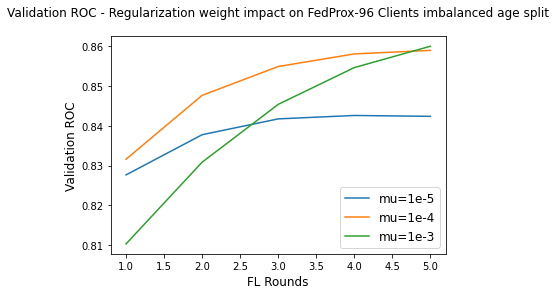

In [37]:
plt.plot(range(1,6),fedprox_1e5['val_roc'][:5], label='mu=1e-5')
plt.plot(range(1,6),fedprox_1e4['val_roc'][:5], label='mu=1e-4')
plt.plot(range(1,6),fedprox_1e3['val_roc'][:5], label='mu=1e-3')

plt.title("Validation ROC - Regularization weight impact on FedProx-96 Clients imbalanced age split",pad=20)

plt.legend(fontsize=12)
plt.xlabel("FL Rounds", fontsize=12)
plt.ylabel("Validation ROC", fontsize=12)
plt.show()

- We can see a good learning performance for FedProx algorthm when regularization parameter is 1e-3. The result is achieved with good communication efficiency.
- The suitable choice of the regularization parameter is 1e-3. This level is higher than the once we observed for 6 workers in the previous section. 
- The higher level of regularization required for large number of clients compared small number of clients could be explained higher dissimilarity of the client gradient compared to scenarios with smaller number of clients